In [492]:
import warnings

# 오류 경고 무시하기
warnings.filterwarnings(action='ignore')


# 데이터 불러오기

In [372]:
import pandas as pd
import os

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)

PATH = 'C:/Users/user/상권분석/data/서울시 상권분석서비스(오탈자 수정)/'

file_list= os.listdir(PATH)
csv_list = list()

for file in file_list:
    if file.split(".")[-1] == 'csv':
        csv_list.append(file)
data = ['rent','small_rent','big_rent','living_popul','indicator','resident_popul', 'income','apartment', 'area', 'store', 'working_popul', 'facilitie', 'estimated_sales']

for name, file in zip(data, csv_list):
    if name == 'rent':
        globals()[name] = pd.read_csv(PATH + file, names = ['기준년코드', '기준분기코드', '행정동코드', '행정동코드명', '임대시세층구분코드', '임대시세층구분명', '보증금평균','월임대료평균','환산임대료평균','임대건수'],encoding = "ansi")
    else:
        globals()[name] = pd.read_csv(PATH + file, encoding = "ansi")

store = store.drop("Unnamed: 0", axis = 1)
estimated_sales = estimated_sales.drop("Unnamed: 0", axis = 1)

# 데이터 전처리

## 시점 통일

In [373]:
years = [20223, 20224, 20231, 20232]

living_popul = living_popul[living_popul['기준_년분기_코드'].isin(years)]
resident_popul = resident_popul[resident_popul['기준_년분기_코드'].isin(years)]
store = store[store['기준_년분기_코드'].isin(years)]
working_popul = working_popul[working_popul['기준_년분기_코드'].isin(years)]
facilitie = facilitie[facilitie['기준_년분기_코드'].isin(years)]
estimated_sales = estimated_sales[estimated_sales['기준_년분기_코드'].isin(years)]

## 관광특구 삭제

In [374]:
living_popul = living_popul[living_popul['상권_구분_코드_명']!='관광특구']
resident_popul = resident_popul[resident_popul['상권_구분_코드_명']!='관광특구']
store = store[store['상권_구분_코드_명']!='관광특구']
working_popul = working_popul[working_popul['상권_구분_코드_명']!='관광특구']
facilitie = facilitie[facilitie['상권_구분_코드_명']!='관광특구']
estimated_sales = estimated_sales[estimated_sales['상권_구분_코드_명']!='관광특구']

## 길단위인구 전처리

### 파생변수 생성
1.시간대_21_06_유동인구_수
  - 21_00시 유동인구의 특징과 00_06시 유동인구의 특징이 비슷하다고 생각하여 합침

2.주중_유동인구_수
  - 월~금 유동인구 수의 합

3.주말_유동인구_수
  - 토,일 유동인구 수의 합

4.30_40, 50_60대 유동인구 수
 합

In [375]:
living_popul['시간대_21_06_유동인구_수'] = living_popul['시간대_00_06_유동인구_수'] + living_popul['시간대_21_24_유동인구_수']
living_popul['주중_유동인구_수'] = living_popul['월요일_유동인구_수'] + living_popul['화요일_유동인구_수'] + living_popul['수요일_유동인구_수'] + living_popul['목요일_유동인구_수'] + living_popul['금요일_유동인구_수']
living_popul['주말_유동인구_수'] = living_popul['토요일_유동인구_수'] + living_popul['일요일_유동인구_수']
living_popul['연령대_30_40_유동인구_수'] = living_popul['연령대_30_유동인구_수'] + living_popul['연령대_40_유동인구_수']
living_popul['연령대_50_60_유동인구_수'] = living_popul['연령대_50_유동인구_수'] + living_popul['연령대_60_이상_유동인구_수']

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 월~일 유동인구 수
- 21~06시 유동인구수
- 30~60대 연령

In [376]:
living_popul = living_popul.drop(['상권_구분_코드','상권_코드','월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수', '시간대_00_06_유동인구_수', '시간대_21_24_유동인구_수','연령대_30_유동인구_수','연령대_40_유동인구_수','연령대_50_유동인구_수','연령대_60_이상_유동인구_수'], axis = 1)

### 결측치 확인 및 제거
- 결측치 없음

In [377]:
living_popul.isnull().sum()

기준_년분기_코드           0
상권_구분_코드_명          0
상권_코드_명             0
총_유동인구_수            0
남성_유동인구_수           0
여성_유동인구_수           0
연령대_10_유동인구_수       0
연령대_20_유동인구_수       0
시간대_06_11_유동인구_수    0
시간대_11_14_유동인구_수    0
시간대_14_17_유동인구_수    0
시간대_17_21_유동인구_수    0
시간대_21_06_유동인구_수    0
주중_유동인구_수           0
주말_유동인구_수           0
연령대_30_40_유동인구_수    0
연령대_50_60_유동인구_수    0
dtype: int64

### 이상치 확인 및 제거
- 하위 5% 제거

In [378]:
living_popul.describe()

기준_년분기_코드    총_유동인구_수   남성_유동인구_수   여성_유동인구_수  연령대_10_유동인구_수  \
count   6573.000    6573.000    6573.000    6573.000       6573.000   
mean   20227.499  819172.761  390059.275  429113.498     105750.179   
std        4.032  860738.310  415405.204  448793.459     112986.973   
min    20223.000      12.000      12.000       0.000          0.000   
25%    20223.000  221071.000  106737.000  113709.000      25585.000   
50%    20224.000  566885.000  269133.000  296501.000      71313.000   
75%    20231.000 1130788.000  534060.000  588669.000     146355.000   
max    20232.000 7942915.000 4000287.000 4032096.000     829062.000   

       연령대_20_유동인구_수  시간대_06_11_유동인구_수  시간대_11_14_유동인구_수  시간대_14_17_유동인구_수  \
count       6573.000          6573.000          6573.000          6573.000   
mean      146463.772        166764.988        104697.384        105734.445   
std       211285.817        172023.931        119372.114        122503.528   
min            0.000             4.000             5.000             0.000   
25%        32148.000         45786.000         28449.000         28568.000   
50%        82738.000        116615.000         71878.000         71921.000   
75%       182991.000        233054.000        139191.000        139491.000   
max      3487417.000       1529921.000       1429461.000       1491003.000   

       시간대_17_21_유동인구_수  시간대_21_06_유동인구_수   주중_유동인구_수   주말_유동인구_수  \
count          6573.000          6573.000    6573.000    6573.000   
mean         141765.368        300210.649  590223.923  228948.919   
std          158734.038        318552.356  625430.046  240185.552   
min               0.000             0.000       0.000       0.000   
25%           38153.000         75518.000  158928.000   60054.000   
50%           95899.000        205337.000  405241.000  158567.000   
75%          193507.000        414441.000  822348.000  311102.000   
max         1793125.000       2942275.000 6236830.000 2124591.000   

       연령대_30_40_유동인구_수  연령대_50_60_유동인구_수  
count          6573.000          6573.000  
mean         276078.394        290880.488  
std          311897.390        293363.299  
min               0.000             0.000  
25%           74201.000         79250.000  
50%          184591.000        205254.000  
75%          369148.000        409490.000  
max         3433420.000       2463853.000

In [379]:
living_popul['총_유동인구_수'].quantile(0.05)

41037.200000000004

In [380]:
living_popul = living_popul[living_popul['총_유동인구_수']>living_popul['총_유동인구_수'].quantile(0.05)]

In [381]:
living_popul.describe()

기준_년분기_코드    총_유동인구_수   남성_유동인구_수   여성_유동인구_수  연령대_10_유동인구_수  \
count   6244.000    6244.000    6244.000    6244.000       6244.000   
mean   20227.500  861007.418  409971.520  451035.914     111144.242   
std        4.031  863096.762  416810.529  449916.683     113389.502   
min    20223.000   41072.000   13408.000   18623.000       1160.000   
25%    20223.750  265570.000  127060.000  139001.500      30543.000   
50%    20227.500  603379.500  289128.000  315265.500      76537.000   
75%    20231.000 1191739.750  559779.750  621915.750     151699.500   
max    20232.000 7942915.000 4000287.000 4032096.000     829062.000   

       연령대_20_유동인구_수  시간대_06_11_유동인구_수  시간대_11_14_유동인구_수  시간대_14_17_유동인구_수  \
count       6244.000          6244.000          6244.000          6244.000   
mean      153997.007        175276.202        110032.630        111122.823   
std       214149.643        172348.288        120132.091        123359.863   
min          558.000          7115.000          3788.000          3588.000   
25%        37973.750         54613.250         33662.500         34618.750   
50%        89099.000        124512.000         76581.000         77453.500   
75%       191301.500        241329.250        145259.500        145725.250   
max      3487417.000       1529921.000       1429461.000       1491003.000   

       시간대_17_21_유동인구_수  시간대_21_06_유동인구_수   주중_유동인구_수   주말_유동인구_수  \
count          6244.000          6244.000    6244.000    6244.000   
mean         149007.149        315568.686  620359.782  240647.721   
std          159612.613        319544.916  627396.371  240819.332   
min            4534.000          5504.000   28199.000    8959.000   
25%           45653.500         89887.250  190333.250   74086.750   
50%          102923.500        221175.500  437589.000  167723.000   
75%          200731.750        432292.250  858979.000  328543.500   
max         1793125.000       2942275.000 6236830.000 2124591.000   

       연령대_30_40_유동인구_수  연령대_50_60_유동인구_수  
count          6244.000          6244.000  
mean         290180.393        305685.847  
std          313738.696        293625.975  
min            8992.000          8232.000  
25%           88205.500         96457.750  
50%          197354.500        221065.000  
75%          383017.750        421936.000  
max         3433420.000       2463853.000

### 중복행 확인 및 제거
- 중복행 없음

In [382]:
living_popul[living_popul.duplicated()]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 총_유동인구_수, 남성_유동인구_수, 여성_유동인구_수, 연령대_10_유동인구_수, 연령대_20_유동인구_수, 시간대_06_11_유동인구_수, 시간대_11_14_유동인구_수, 시간대_14_17_유동인구_수, 시간대_17_21_유동인구_수, 시간대_21_06_유동인구_수, 주중_유동인구_수, 주말_유동인구_수, 연령대_30_40_유동인구_수, 연령대_50_60_유동인구_수]
Index: []

In [383]:
living_popul = living_popul[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','총_유동인구_수']]

### 분기데이터 1년치 데이터로 변환
- 유동인구 -> 4개 분기의 평균

In [384]:
living_popul_year = living_popul.groupby(['상권_구분_코드_명','상권_코드_명'],as_index=False).mean()
living_popul_year = living_popul_year.drop('기준_년분기_코드', axis = 1)

In [385]:
living_popul_year

상권_구분_코드_명              상권_코드_명   총_유동인구_수
0          골목상권         4.19민주묘지역 2번 868030.000
1          골목상권            GS강동자이아파트 839601.250
2          골목상권                  G타워 335492.500
3          골목상권         KB국민은행 망원동지점 836247.500
4          골목상권          KB국민은행 서강지점 193851.250
...         ...                  ...        ...
1564       전통시장         황학동주방가구거리상점가 970941.500
1565       전통시장  황학시장(서울중앙시장, 신중앙시장) 700684.000
1566       전통시장                 회기시장 427918.250
1567       전통시장                 후암시장 137171.500
1568       전통시장                 흑석시장  90347.500

[1569 rows x 3 columns]

## 상주인구 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 총 상주인구 수
- 남성 상주인구 수
- 여성 상주인구 수
- 연령대 10 ~ 60 이상상주인구 수
- 총 가구 수, 아파트 가구 수, 비아파트 가구수

In [386]:
resident_popul[resident_popul['상권_코드_명']=='개포지하차도 북측']

기준_년분기_코드 상권_구분_코드 상권_구분_코드_명    상권_코드    상권_코드_명  총_상주인구_수  남성_상주인구_수  \
16007      20223        A       골목상권  3110993  개포지하차도 북측       234        121   
17640      20224        A       골목상권  3110993  개포지하차도 북측       236        107   
19249      20231        A       골목상권  3110993  개포지하차도 북측       236        107   
20878      20232        A       골목상권  3110993  개포지하차도 북측       236        107   

       여성_상주인구_수  연령대_10_상주인구_수  연령대_20_상주인구_수  연령대_30_상주인구_수  연령대_40_상주인구_수  \
16007        113             27             36             39             33   
17640        129             28             25             45             44   
19249        129             28             25             45             44   
20878        129             28             25             45             44   

       연령대_50_상주인구_수  연령대_60_이상_상주인구_수  남성연령대_10_상주인구_수  남성연령대_20_상주인구_수  \
16007             42                57               14               24   
17640             31                63               17               15   
19249             31                63               17               15   
20878             31                63               17               15   

       남성연령대_30_상주인구_수  남성연령대_40_상주인구_수  남성연령대_50_상주인구_수  남성연령대_60_이상_상주인구_수  \
16007               25               14               21                  23   
17640               19               14               13                  29   
19249               19               14               13                  29   
20878               19               14               13                  29   

       여성연령대_10_상주인구_수  여성연령대_20_상주인구_수  여성연령대_30_상주인구_수  여성연령대_40_상주인구_수  \
16007               13               12               14               19   
17640               11               10               26               30   
19249               11               10               26               30   
20878               11               10               26               30   

       여성연령대_50_상주인구_수  여성연령대_60_이상_상주인구_수  총_가구_수  아파트_가구_수  비_아파트_가구_수  
16007               21                  34     119         0         119  
17640               18                  34     119         0         119  
19249               18                  34     110         0         110  
20878               18                  34     119         0         119

In [387]:
resident_popul = resident_popul[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','총_상주인구_수','남성_상주인구_수','여성_상주인구_수','연령대_10_상주인구_수','연령대_20_상주인구_수','연령대_30_상주인구_수','연령대_40_상주인구_수','연령대_50_상주인구_수','연령대_60_이상_상주인구_수']]

In [388]:
resident_popul = resident_popul[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','총_상주인구_수']]

### 파생변수 생성

In [389]:
resident_popul['상권_구분_코드_명'].unique()

array(['골목상권', '발달상권', '전통시장'], dtype=object)

In [390]:
# resident_popul['연령대_30_40_상주인구_수'] = resident_popul['연령대_30_상주인구_수']+resident_popul['연령대_40_상주인구_수']
# resident_popul['연령대_50_60_상주인구_수'] = resident_popul['연령대_50_상주인구_수']+resident_popul['연령대_60_이상_상주인구_수']

In [391]:
# resident_popul.drop(['연령대_30_상주인구_수','연령대_40_상주인구_수','연령대_50_상주인구_수','연령대_60_이상_상주인구_수'],axis=1,inplace=True)

### 결측치 확인 및 제거
- 결측치 없음

In [392]:
resident_popul.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
총_상주인구_수      0
dtype: int64

### 이상치 확인 및 제거
- 이상치가 없다고 판단됨

In [393]:
resident_popul.describe()

기준_년분기_코드  총_상주인구_수
count   6488.000  6488.000
mean   20227.495  2359.471
std        4.032  2348.110
min    20223.000     1.000
25%    20223.000   657.000
50%    20224.000  1614.000
75%    20231.000  3305.000
max    20232.000 21341.000

In [394]:
# resident_popul[resident_popul['총_상주인구_수']>15000]

In [395]:
# outlier_list = list(resident_popul[resident_popul['총_상주인구_수']<10].상권_코드_명.unique())
# for i in outlier_list:
#     print(resident_popul[resident_popul['상권_코드_명']==i])

### 중복행 확인 및 제거
- 중복행 없음

In [396]:
resident_popul[resident_popul.duplicated()]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 총_상주인구_수]
Index: []

### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 상주인구만 추출

In [397]:
resident_popul_year = resident_popul[resident_popul['기준_년분기_코드'] == 20232]
resident_popul_year = resident_popul_year.drop(['기준_년분기_코드'],axis=1)

## 점포 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 서비스_업종_코드

In [398]:
store.drop(['상권_구분_코드','상권_코드','서비스_업종_코드'],axis=1,inplace=True)

### 파생변수 생성

In [399]:
# food = ['호프-간이주점','중식음식점','패스트푸드점','분식전문점','치킨전문점','일식음식점','양식음식점','한식음식점','제과점','커피-음료']
# edu_service = ['예술학원','컴퓨터학원','일반교습학원','외국어학원','스포츠 강습','스포츠클럽','골프연습장']
# accommodation = ['여관','고시원']
# repair_service = ['자동차수리','가전제품수리','미용실','세탁소','피부관리실','자동차미용','PC방','인테리어','네일숍','노래방','당구장']
# retail = ['편의점','슈퍼마켓','육류판매','수산물판매','일반의류','화장품','컴퓨터및주변장치판매','가구','서적','의약품','조명용품',
#          '미곡판매','화초','문구','청과상','안경','의료기기','운동/경기용품','철물점','시계및귀금속','가방','완구','자전거 및 기타운송장비',
#           '애완동물','섬유제품','신발','가전제품','핸드폰','전자상거래업', '반찬가게']
# medical = ['일반의원','치과의원','한의원']
# real_estate = ['부동산중개업']

In [400]:
# def industry_categoty(df):
#     if df['서비스_업종_코드_명'] in food:
#         return '음식점업'
#     elif df['서비스_업종_코드_명'] in edu_service:
#         return '교육 서비스업'
#     elif df['서비스_업종_코드_명'] in accommodation:
#         return '숙박업'
#     elif df['서비스_업종_코드_명'] in repair_service:
#         return '수리 및 기타 서비스업'
#     elif df['서비스_업종_코드_명'] in retail:
#         return '도매 및 소매업'
#     elif df['서비스_업종_코드_명'] in medical:
#         return '보건업 및 의료 서비스업'
#     elif df['서비스_업종_코드_명'] in real_estate:
#         return '부동산업'

In [401]:
# store['서비스업종_대분류'] = store.apply(industry_categoty, axis=1)

In [402]:
# store['서비스업종_대분류'].unique()

In [403]:
# df[df['서비스업종_대분류'].isna()]['서비스_업종_코드_명'].unique()

In [404]:
# df.head()

In [405]:
service_list = ['한식음식점', '미용실', '커피-음료', '편의점',  '일반의류', '분식전문점', '호프-간이주점', '의약품', '일반교습학원', '치킨전문점', '노래방', '일반의원', '중식음식점',  '패스트푸드점', '제과점', '치과의원', '일식음식점','양식음식점']
store = store[store['서비스_업종_코드_명'].isin(service_list)]

### 중복행 확인 및 제거
- 중복행 없음

In [406]:
store[store.duplicated()]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 서비스_업종_코드_명, 점포_수, 유사_업종_점포_수, 개업_율, 개업_점포_수, 폐업_률, 폐업_점포_수, 프랜차이즈_점포_수]
Index: []

### 결측치 확인 및 제거
- 결측치 없음

In [407]:
store.isnull().sum()

기준_년분기_코드      0
상권_구분_코드_명     0
상권_코드_명        0
서비스_업종_코드_명    0
점포_수           0
유사_업종_점포_수     0
개업_율           0
개업_점포_수        0
폐업_률           0
폐업_점포_수        0
프랜차이즈_점포_수     0
dtype: int64

### 이상치 확인 및 제거
- 점포수 -> 8500개? 이상치 인듯?

In [408]:
store.describe()

기준_년분기_코드      점포_수  유사_업종_점포_수      개업_율   개업_점포_수      폐업_률  \
count  86830.000 86830.000   86830.000 86830.000 86830.000 86830.000   
mean   20227.495     8.195       9.501     3.143     0.284     3.507   
std        4.031    32.456      33.492    11.060     0.896    12.763   
min    20223.000     0.000       0.000     0.000     0.000     0.000   
25%    20223.000     1.000       2.000     0.000     0.000     0.000   
50%    20224.000     3.000       4.000     0.000     0.000     0.000   
75%    20231.000     7.000       8.000     0.000     0.000     0.000   
max    20232.000  2138.000    2142.000   100.000    27.000   300.000   

        폐업_점포_수  프랜차이즈_점포_수  
count 86830.000   86830.000  
mean      0.318       1.306  
std       1.174       3.590  
min       0.000       0.000  
25%       0.000       0.000  
50%       0.000       0.000  
75%       0.000       1.000  
max      71.000     123.000

In [409]:
store[store['점포_수']>1000].head()

기준_년분기_코드 상권_구분_코드_명                       상권_코드_명 서비스_업종_코드_명  점포_수  \
1088295      20223       발달상권                           신당역        일반의류  1749   
1101418      20223       전통시장              평화시장(통일상가, 동화상가)        일반의류  1278   
1118140      20223       전통시장  평화시장(남평화시장, 제일평화시장, 신평화패션타운)        일반의류  1908   
1125326      20223       전통시장                         청평화시장        일반의류  2138   
1136007      20224       발달상권                           신당역        일반의류  1724   

         유사_업종_점포_수  개업_율  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수  
1088295        1754     0        1     4       62           5  
1101418        1282     1       11     3       42           4  
1118140        1909     0        4     4       68           1  
1125326        2142     0        0     3       59           4  
1136007        1729     0        2     2       27           5

In [410]:
store = store[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명','유사_업종_점포_수','개업_점포_수','폐업_점포_수']]

In [411]:
# store.groupby([])

### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [412]:
store_year = store[store['기준_년분기_코드'] == 20232]
store_year = store_year.drop(columns = ['기준_년분기_코드'])

In [413]:
store_year = store_year.groupby(['상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명'],as_index=False).sum()

In [414]:
store_year.describe()

유사_업종_점포_수   개업_점포_수   폐업_점포_수
count   21677.000 21677.000 21677.000
mean        9.496     0.320     0.304
std        32.836     0.987     1.019
min         0.000     0.000     0.000
25%         2.000     0.000     0.000
50%         4.000     0.000     0.000
75%         8.000     0.000     0.000
max      1980.000    23.000    47.000

## 직장인구 전처리

### 필요한 컬럼만 추출
- 기준_년분기_코드
- 상권_구분_코드_명
- 상권_코드_명
- 총_직장_인구_수

In [415]:
working_popul = working_popul[['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '총_직장_인구_수']]


### 결측치 확인 및 제거
- 결측치 없음

In [416]:
working_popul.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
총_직장_인구_수     0
dtype: int64

### 이상치 확인 및 제거
- 이상치 없음

In [417]:
working_popul.describe()

기준_년분기_코드  총_직장_인구_수
count   6468.000   6468.000
mean   20227.500   1660.112
std        4.031   5611.955
min    20223.000      1.000
25%    20223.750    105.000
50%    20227.500    315.000
75%    20231.250    876.000
max    20232.000  81127.000

In [418]:
working_popul[working_popul['총_직장_인구_수']>60000]

기준_년분기_코드 상권_구분_코드_명    상권_코드_명  총_직장_인구_수
7062       20223       발달상권     포스코사거리      61667
8043       20223       발달상권    가산디지털단지      81127
8083       20223       발달상권        강남역      72613
8259       20223       발달상권  여의도역(여의도)      69255
8685       20224       발달상권     포스코사거리      61667
9665       20224       발달상권    가산디지털단지      81127
9706       20224       발달상권        강남역      72613
9882       20224       발달상권  여의도역(여의도)      69255
10293      20231       발달상권     포스코사거리      61667
11271      20231       발달상권    가산디지털단지      81127
11312      20231       발달상권        강남역      72613
11488      20231       발달상권  여의도역(여의도)      69255
11911      20232       발달상권     포스코사거리      61667
12888      20232       발달상권    가산디지털단지      81127
12929      20232       발달상권        강남역      72613
13104      20232       발달상권  여의도역(여의도)      69255

### 중복행 확인 및 제거
- 중복행 없음

In [419]:
working_popul[working_popul.duplicated()]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 총_직장_인구_수]
Index: []

### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [420]:
working_popul_year = working_popul[working_popul['기준_년분기_코드'] == 20232]
working_popul_year = working_popul_year.drop(['기준_년분기_코드'],axis=1)

## 집객시설 전처리

### 불필요한 feature 제거
- 상권_구분_코드
- 상권_코드
- 집객시설_수

In [421]:
facilitie.drop(['상권_구분_코드','상권_코드','집객시설_수','철도_역_수'],axis=1,inplace=True)

### 파생변수 생성

In [422]:
# facilitie['초중고_수'] = facilitie['초등학교_수']+facilitie['중학교_수']+facilitie['고등학교_수']
# facilitie.drop(['초등학교_수','중학교_수','고등학교_수'],axis=1,inplace=True)

### 결측치 확인 및 제거
- 결측치 -> 0으로 처리

In [423]:
facilitie.isnull().sum()

기준_년분기_코드        0
상권_구분_코드_명       0
상권_코드_명          0
관공서_수         3792
은행_수          4364
종합병원_수        6200
일반_병원_수       5764
약국_수          2276
유치원_수         5684
초등학교_수        6244
중학교_수         6276
고등학교_수        6248
대학교_수         5956
백화점_수         6252
슈퍼마켓_수        5884
극장_수          5972
숙박_시설_수       5720
공항_수          6284
버스_터미널_수      6280
지하철_역_수       5528
버스_정거장_수      1232
dtype: int64

In [424]:
facilitie.shape

(6288, 21)

In [425]:
facilitie = facilitie.fillna(0)
facilitie.isnull().sum()

기준_년분기_코드     0
상권_구분_코드_명    0
상권_코드_명       0
관공서_수         0
은행_수          0
종합병원_수        0
일반_병원_수       0
약국_수          0
유치원_수         0
초등학교_수        0
중학교_수         0
고등학교_수        0
대학교_수         0
백화점_수         0
슈퍼마켓_수        0
극장_수          0
숙박_시설_수       0
공항_수          0
버스_터미널_수      0
지하철_역_수       0
버스_정거장_수      0
dtype: int64

In [426]:
facilitie['초중고_수'] = facilitie['초등학교_수']+facilitie['중학교_수']+facilitie['고등학교_수']
facilitie['집객시설수'] = facilitie['관공서_수'] + facilitie['은행_수'] + facilitie['종합병원_수'] + facilitie['일반_병원_수'] + facilitie['약국_수'] + facilitie['유치원_수'] + facilitie['초중고_수'] + facilitie['백화점_수'] + facilitie['슈퍼마켓_수'] + facilitie['극장_수'] + facilitie['숙박_시설_수']
facilitie['교통시설수'] = facilitie['공항_수'] + facilitie['버스_터미널_수'] + facilitie['지하철_역_수'] + facilitie['버스_정거장_수']

### 이상치 확인 및 제거
- 은행 52개 버스정거장수 85 집객 시설 수 594개 이상한데

In [427]:
facilitie.describe()

기준_년분기_코드    관공서_수     은행_수   종합병원_수  일반_병원_수     약국_수    유치원_수  \
count   6288.000 6288.000 6288.000 6288.000 6288.000 6288.000 6288.000   
mean   20227.500    0.678    0.947    0.015    0.107    2.299    0.112   
std        4.031    1.111    2.591    0.125    0.396    3.812    0.386   
min    20223.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%    20223.750    0.000    0.000    0.000    0.000    0.000    0.000   
50%    20227.500    0.000    0.000    0.000    0.000    1.000    0.000   
75%    20231.250    1.000    1.000    0.000    0.000    3.000    0.000   
max    20232.000   10.000   41.000    2.000    4.000   52.000    6.000   

        초등학교_수    중학교_수   고등학교_수    대학교_수    백화점_수   슈퍼마켓_수     극장_수  숙박_시설_수  \
count 6288.000 6288.000 6288.000 6288.000 6288.000 6288.000 6288.000 6288.000   
mean     0.007    0.002    0.006    0.087    0.006    0.094    0.066    0.198   
std      0.083    0.044    0.080    0.466    0.087    0.467    0.321    0.933   
min      0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%      0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
50%      0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
75%      0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
max      1.000    1.000    1.000    7.000    2.000    8.000    4.000   18.000   

          공항_수  버스_터미널_수  지하철_역_수  버스_정거장_수    초중고_수    집객시설수    교통시설수  
count 6288.000  6288.000 6288.000  6288.000 6288.000 6288.000 6288.000  
mean     0.003     0.001    0.167     3.828    0.015    4.536    3.998  
std      0.101     0.036    0.507     4.789    0.133    7.109    5.029  
min      0.000     0.000    0.000     0.000    0.000    0.000    0.000  
25%      0.000     0.000    0.000     1.000    0.000    1.000    1.000  
50%      0.000     0.000    0.000     3.000    0.000    2.000    3.000  
75%      0.000     0.000    0.000     5.000    0.000    5.000    5.000  
max      4.000     1.000    5.000    85.000    2.000   87.000   87.000

In [428]:
facilitie[facilitie['약국_수']==52]

기준_년분기_코드 상권_구분_코드_명 상권_코드_명  관공서_수   은행_수  종합병원_수  일반_병원_수   약국_수  \
2544       20232       발달상권     강남역  7.000 24.000   0.000    0.000 52.000   
2545       20231       발달상권     강남역  7.000 24.000   0.000    0.000 52.000   
14631      20224       발달상권     강남역  7.000 24.000   0.000    0.000 52.000   
14632      20223       발달상권     강남역  7.000 24.000   0.000    0.000 52.000   

       유치원_수  초등학교_수  중학교_수  고등학교_수  대학교_수  백화점_수  슈퍼마켓_수  극장_수  숙박_시설_수  \
2544   0.000   0.000  0.000   0.000  0.000  0.000   0.000 4.000    0.000   
2545   0.000   0.000  0.000   0.000  0.000  0.000   0.000 4.000    0.000   
14631  0.000   0.000  0.000   0.000  0.000  0.000   0.000 4.000    0.000   
14632  0.000   0.000  0.000   0.000  0.000  0.000   0.000 4.000    0.000   

       공항_수  버스_터미널_수  지하철_역_수  버스_정거장_수  초중고_수  집객시설수  교통시설수  
2544  0.000     0.000    2.000    36.000  0.000 87.000 38.000  
2545  0.000     0.000    2.000    36.000  0.000 87.000 38.000  
14631 0.000     0.000    2.000    36.000  0.000 87.000 38.000  
14632 0.000     0.000    2.000    36.000  0.000 87.000 38.000

In [429]:
facilitie[facilitie['버스_정거장_수']>80]

기준_년분기_코드 상권_구분_코드_명  상권_코드_명  관공서_수   은행_수  종합병원_수  일반_병원_수   약국_수  \
2386       20232       발달상권  가산디지털단지  7.000 25.000   0.000    0.000 16.000   
2387       20231       발달상권  가산디지털단지  7.000 25.000   0.000    0.000 16.000   
13920      20224       발달상권  가산디지털단지  7.000 25.000   0.000    0.000 16.000   
13921      20223       발달상권  가산디지털단지  7.000 25.000   0.000    0.000 16.000   

       유치원_수  초등학교_수  중학교_수  고등학교_수  대학교_수  백화점_수  슈퍼마켓_수  극장_수  숙박_시설_수  \
2386   0.000   0.000  0.000   0.000  0.000  0.000   0.000 1.000    3.000   
2387   0.000   0.000  0.000   0.000  0.000  0.000   0.000 1.000    3.000   
13920  0.000   0.000  0.000   0.000  0.000  0.000   0.000 1.000    3.000   
13921  0.000   0.000  0.000   0.000  0.000  0.000   0.000 1.000    3.000   

       공항_수  버스_터미널_수  지하철_역_수  버스_정거장_수  초중고_수  집객시설수  교통시설수  
2386  0.000     0.000    2.000    85.000  0.000 52.000 87.000  
2387  0.000     0.000    2.000    85.000  0.000 52.000 87.000  
13920 0.000     0.000    2.000    85.000  0.000 52.000 87.000  
13921 0.000     0.000    2.000    85.000  0.000 52.000 87.000

In [430]:
area[area['상권_코드_명']=='가산디지털단지']

상권_구분_코드 상권_구분_코드_명    상권_코드  상권_코드_명  엑스좌표_값  와이좌표_값  자치구_코드 자치구_코드_명  \
1235        D       발달상권  3120131  가산디지털단지  189641  441969   11545      금천구   

        행정동_코드 행정동_코드_명    영역_면적  
1235  11545510      가산동  1713620

In [431]:
area[area['상권_코드_명']=='명동 남대문 북창동 다동 무교동 관광특구']

상권_구분_코드 상권_구분_코드_명    상권_코드                 상권_코드_명  엑스좌표_값  와이좌표_값  \
1645        U       관광특구  3001492  명동 남대문 북창동 다동 무교동 관광특구  198397  451614   

      자치구_코드 자치구_코드_명    행정동_코드 행정동_코드_명   영역_면적  
1645   11140       중구  11140520      소공동  983618

In [432]:
area.describe()

상권_코드     엑스좌표_값     와이좌표_값    자치구_코드       행정동_코드       영역_면적
count    1650.000   1650.000   1650.000  1650.000     1650.000    1650.000
mean  3115221.905 198981.845 449875.452 11426.218 11426858.585   99927.952
std     10321.659   7280.721   5590.503   190.534   190548.801  118818.943
min   3001491.000 182509.000 437249.000 11110.000 11110515.000    1854.000
25%   3110407.250 192815.250 445178.500 11260.000 11260575.000   35330.000
50%   3110819.500 200096.000 449849.500 11440.000 11440590.000   71927.500
75%   3120141.750 204366.250 453563.500 11590.000 11590560.000  128147.250
max   3130327.000 215352.000 465573.000 11740.000 11740700.000 2462734.000

### 중복행 확인 및 제거
- 중복행 없음


In [433]:
facilitie[facilitie.duplicated()]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 관공서_수, 은행_수, 종합병원_수, 일반_병원_수, 약국_수, 유치원_수, 초등학교_수, 중학교_수, 고등학교_수, 대학교_수, 백화점_수, 슈퍼마켓_수, 극장_수, 숙박_시설_수, 공항_수, 버스_터미널_수, 지하철_역_수, 버스_정거장_수, 초중고_수, 집객시설수, 교통시설수]
Index: []

In [434]:
facilitie = facilitie[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','집객시설수','교통시설수']]

In [435]:
facilitie.describe()

기준_년분기_코드    집객시설수    교통시설수
count   6288.000 6288.000 6288.000
mean   20227.500    4.536    3.998
std        4.031    7.109    5.029
min    20223.000    0.000    0.000
25%    20223.750    1.000    1.000
50%    20227.500    2.000    3.000
75%    20231.250    5.000    5.000
max    20232.000   87.000   87.000

### 분기데이터 1년치 데이터로 변환
- 마지막 분기인 2023년 2분기의 데이터만 추출

In [436]:
facilitie_year = facilitie[facilitie['기준_년분기_코드'] == 20232]
facilitie_year = facilitie_year.drop(['기준_년분기_코드'],axis=1)

## 추정매출 전처리

### 파생변수 생성
1.시간대_21_06_매출_건수, 시간대_21_06_매출_금액
- 21_00시 유동인구의 특징과 00_06시 유동인구의 특징이 비슷하다고 판단함

In [437]:
estimated_sales['시간대_21~06_매출_금액'] = estimated_sales['시간대_00~06_매출_금액'] + estimated_sales['시간대_21~24_매출_금액']
estimated_sales['시간대_21~06_매출_건수'] = estimated_sales['시간대_건수~06_매출_건수'] + estimated_sales['시간대_건수~24_매출_건수']
estimated_sales['연령대_30_40_매출_금액'] = estimated_sales['연령대_30_매출_금액'] + estimated_sales['연령대_40_매출_금액']
estimated_sales['연령대_50_60_매출_금액'] = estimated_sales['연령대_50_매출_금액'] + estimated_sales['연령대_60_이상_매출_금액']
estimated_sales['연령대_30_40_매출_건수'] = estimated_sales['연령대_30_매출_건수'] + estimated_sales['연령대_40_매출_건수']
estimated_sales['연령대_50_60_매출_건수'] = estimated_sales['연령대_50_매출_건수'] + estimated_sales['연령대_60_이상_매출_건수']

### 불필요한 feature제거
- 상권_구분_코드
- 
상권_코
- 서비스_업종_코드
- 21~06 매출금액, 매출건수
- 월~일 매출금액, 매출건수드

In [438]:
estimated_sales = estimated_sales.drop(columns = ['상권_구분_코드', '상권_코드', '서비스_업종_코드'],
                                       axis = 1)
estimated_sales = estimated_sales.drop(columns = ['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액',
                                                  '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수', '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수'],
                                       axis = 1)
estimated_sales = estimated_sales.drop(columns = ['시간대_00~06_매출_금액', '시간대_21~24_매출_금액', '시간대_건수~06_매출_건수', '시간대_건수~24_매출_건수',
                                                 '연령대_30_매출_금액','연령대_40_매출_금액','연령대_50_매출_금액','연령대_60_이상_매출_금액',
                                                 '연령대_30_매출_건수','연령대_40_매출_건수','연령대_50_매출_건수','연령대_60_이상_매출_건수'],
                                       axis = 1)

### 결측치 확인 및 제거
- 결측치 어떻게 처리하지

In [439]:
estimated_sales.isnull().sum()

기준_년분기_코드          0
상권_구분_코드_명         0
상권_코드_명            0
서비스_업종_코드_명        0
당월_매출_금액           0
당월_매출_건수           0
주중_매출_금액           0
주말_매출_금액           0
시간대_06~11_매출_금액    0
시간대_11~14_매출_금액    0
시간대_14~17_매출_금액    0
시간대_17~21_매출_금액    0
남성_매출_금액           0
여성_매출_금액           0
연령대_10_매출_금액       0
연령대_20_매출_금액       0
주중_매출_건수           0
주말_매출_건수           0
시간대_건수~11_매출_건수    0
시간대_건수~14_매출_건수    0
시간대_건수~17_매출_건수    0
시간대_건수~21_매출_건수    0
남성_매출_건수           0
여성_매출_건수           0
연령대_10_매출_건수       0
연령대_20_매출_건수       0
시간대_21~06_매출_금액    0
시간대_21~06_매출_건수    0
연령대_30_40_매출_금액    0
연령대_50_60_매출_금액    0
연령대_30_40_매출_건수    0
연령대_50_60_매출_건수    0
dtype: int64

### 이상치 확인 및 제거
- 당원매출금액 천억 이상치인듯

In [440]:
estimated_sales.describe()

기준_년분기_코드         당월_매출_금액     당월_매출_건수         주중_매출_금액  \
count  83142.000        83142.000    83142.000        83142.000   
mean   20227.506   1057530630.270    37378.921    800998140.292   
std        4.031   9247199458.539   158825.344   6375468667.307   
min    20223.000           12.000        1.000            0.000   
25%    20224.000     48000000.000      859.000     35761235.750   
50%    20231.000    184854645.500     4585.000    138333420.000   
75%    20232.000    670335090.750    24990.750    508560976.750   
max    20232.000 995677000000.000 12090273.000 669799000000.000   

              주말_매출_금액  시간대_06~11_매출_금액  시간대_11~14_매출_금액  시간대_14~17_매출_금액  \
count        83142.000        83142.000        83142.000        83142.000   
mean     256532440.674    112812620.583    270639855.442    263642589.533   
std     3472245561.224   1170991051.609   2448384035.026   3090139741.176   
min              0.000            0.000            0.000            0.000   
25%        7349956.500       135702.250      5399863.500      7746083.500   
50%       37661145.000      6136944.500     34222861.000     35608985.500   
75%      146729693.250     47316932.250    149821606.500    139409257.750   
max   485357000000.000 107916000000.000 242249000000.000 326543000000.000   

       시간대_17~21_매출_금액         남성_매출_금액         여성_매출_금액   연령대_10_매출_금액  \
count        83142.000        83142.000        83142.000      83142.000   
mean     289522260.989    482553877.888    454435667.863    5388979.464   
std     2707954382.716   4423202984.139   3474196467.177   29279037.589   
min              0.000            0.000            0.000          0.000   
25%       11697304.250     19337881.500     17810972.500          0.000   
50%       49693963.000     82942230.000     74623180.000     160833.000   
75%      182213664.750    307190696.500    282747046.500    2212020.500   
max   386343000000.000 537243000000.000 304162000000.000 1549259735.000   

         연령대_20_매출_금액    주중_매출_건수    주말_매출_건수  시간대_건수~11_매출_건수  \
count       83142.000   83142.000   83142.000        83142.000   
mean    125426918.046   28218.137    9160.785         5231.569   
std     839832564.084  111071.872   54745.766        27854.478   
min             0.000       0.000       0.000            0.000   
25%       1333739.750     646.000     152.000            6.000   
50%      12158489.500    3400.000    1018.000          165.000   
75%      62126169.750   18704.250    5709.750         1965.000   
max   90669553834.000 5827863.000 6262410.000      1474148.000   

       시간대_건수~14_매출_건수  시간대_건수~17_매출_건수  시간대_건수~21_매출_건수    남성_매출_건수  \
count        83142.000        83142.000        83142.000   83142.000   
mean          9703.087         7869.907         9959.027   18572.037   
std          43249.044        41592.007        44177.137   80157.083   
min              0.000           -1.000            0.000       0.000   
25%            107.000          171.000          224.000     386.000   
50%            967.000          966.000         1287.000    2253.000   
75%           6277.000         5095.000         6880.000   11848.000   
max        2611826.000      3245770.000      4287338.000 6708993.000   

         여성_매출_건수  연령대_10_매출_건수  연령대_20_매출_건수  시간대_21~06_매출_금액  \
count   83142.000     83142.000     83142.000        83142.000   
mean    17223.529       559.116      7452.457    120913224.832   
std     76442.682      3521.526     39113.158    983837619.257   
min         0.000         0.000         0.000            0.000   
25%       337.000         0.000        42.000            0.000   
50%      1937.500        12.000       438.000      3981946.500   
75%     11338.000       170.000      3233.750     50244980.000   
max   4615812.000    329040.000   3087414.000 126314287024.000   

       시간대_21~06_매출_건수  연령대_30_40_매출_금액  연령대_50_60_매출_금액  연령대_30_40_매출_건수  \
count        83142.000        83142.000        83142.000        83142.000   
mean          4615.330    406737845.752 

In [441]:
estimated_sales = estimated_sales[estimated_sales['당월_매출_금액'] > estimated_sales['당월_매출_금액'].quantile(0.05)]

In [442]:
# estimated_sales = estimated_sales[estimated_sales['주중_매출_금액']!=0]

In [443]:
estimated_sales.describe()

기준_년분기_코드         당월_매출_금액     당월_매출_건수         주중_매출_금액  \
count  78928.000        78928.000    78928.000        78928.000   
mean   20227.510   1113841172.476    39367.187    843647186.297   
std        4.031   9487552189.528   162770.715   6540709409.978   
min    20223.000      6000485.000        2.000            0.000   
25%    20224.000     60733851.750     1138.000     44920920.000   
50%    20231.000    210227998.000     5349.000    157415394.500   
75%    20232.000    718642257.250    27495.500    545957879.750   
max    20232.000 995677000000.000 12090273.000 669799000000.000   

              주말_매출_금액  시간대_06~11_매출_금액  시간대_11~14_매출_금액  시간대_14~17_매출_금액  \
count        78928.000        78928.000        78928.000        78928.000   
mean     270193934.243    118824937.633    285055108.985    277671702.287   
std     3563217105.487   1201548075.888   2512079201.811   3170947822.321   
min              0.000            0.000            0.000            0.000   
25%       10035309.500       387665.000      7683850.250     10240340.000   
50%       43038376.000      7680995.500     39874696.500     40692349.000   
75%      157386783.250     52294646.000    161737705.250    149911292.500   
max   485357000000.000 107916000000.000 242249000000.000 326543000000.000   

       시간대_17~21_매출_금액         남성_매출_금액         여성_매출_금액   연령대_10_매출_금액  \
count        78928.000        78928.000        78928.000      78928.000   
mean     304933139.815    508253258.229    478617914.935    5675925.150   
std     2778461615.876   4538312010.823   3564117844.219   30023444.451   
min              0.000            0.000            0.000          0.000   
25%       15116632.250     25175694.250     23129796.500          0.000   
50%       56563574.000     94229444.500     85066347.000     233841.000   
75%      195812427.750    330805947.500    305053756.500    2469580.000   
max   386343000000.000 537243000000.000 304162000000.000 1549259735.000   

         연령대_20_매출_금액    주중_매출_건수    주말_매출_건수  시간대_건수~11_매출_건수  \
count       78928.000   78928.000   78928.000        78928.000   
mean    132108337.805   29719.126    9648.061         5510.230   
std     861449755.553  113803.301   56146.524        28561.591   
min             0.000       0.000       0.000            0.000   
25%       2107129.000     848.000     216.000           12.000   
50%      14304849.500    3980.500    1201.500          211.000   
75%      67885500.500   20632.000    6286.000         2239.250   
max   90669553834.000 5827863.000 6262410.000      1474148.000   

       시간대_건수~14_매출_건수  시간대_건수~17_매출_건수  시간대_건수~21_매출_건수    남성_매출_건수  \
count        78928.000        78928.000        78928.000   78928.000   
mean         10219.217         8287.938        10488.641   19559.983   
std          44329.342        42647.484        45280.063   82151.965   
min              0.000            0.000            0.000       0.000   
25%            156.000          230.000          302.000     525.000   
50%           1175.000         1134.000         1506.000    2649.000   
75%           6920.500         5602.250         7572.000   13098.750   
max        2611826.000      3245770.000      4287338.000 6708993.000   

         여성_매출_건수  연령대_10_매출_건수  연령대_20_매출_건수  시간대_21~06_매출_금액  \
count   78928.000     78928.000     78928.000        78928.000   
mean    18139.572       588.867      7849.136    127356200.655   
std     78351.239      3611.892     40105.023   1009354545.678   
min         0.000         0.000         0.000            0.000   
25%       450.000         0.000        64.000            0.000   
50%      2271.000        16.000       536.000      5424718.500   
75%     12399.250       193.000      3605.250     56105212.250   
max   4615812.000    329040.000   3087414.000 126314287024.000   

       시간대_21~06_매출_건수  연령대_30_40_매출_금액  연령대_50_60_매출_금액  연령대_30_40_매출_건수  \
count        78928.000        78928.000        78928.000        78928.000   
mean          4861.162    428396536.976 

In [444]:
estimated_sales['당월_개인_매출_금액'] = estimated_sales['남성_매출_금액'] + estimated_sales['여성_매출_금액']
estimated_sales['당월_법인_매출_금액'] =  estimated_sales['당월_매출_금액'] - estimated_sales['당월_개인_매출_금액']

In [445]:
estimated_sales[estimated_sales['당월_법인_매출_금액'] < 0]

기준_년분기_코드 상권_구분_코드_명                   상권_코드_명 서비스_업종_코드_명  \
123702      20223       골목상권                  수락산디자인거리         미용실   
124584      20223       골목상권                 남가좌동현대아파트        예술학원   
126952      20223       골목상권                  독산2동주민센터        예술학원   
131445      20223       발달상권                       금호역        일반의류   
134214      20223       발달상권                       영중로       스포츠클럽   
134285      20223       발달상권                      보라매역      스포츠 강습   
140165      20223       전통시장                      신원시장         네일숍   
140497      20223       전통시장  문정동 로데오거리 상점가(문정동 로데오거리)      스포츠 강습   
143091      20224       골목상권                    상봉역 4번      스포츠 강습   
146497      20224       골목상권                신한은행 신월동지점      스포츠 강습   
155036      20224       발달상권                     구로전화국       피부관리실   
158186      20224       발달상권                     경찰병원역      일반교습학원   
160623      20224       전통시장            송화벽화시장(송화골목시장)         화장품   
164058      20231       골목상권                    중화역 1번         네일숍   
165324      20231       골목상권                  덕성여대시반거리        예술학원   
170006      20231       골목상권                   사당역 10번        예술학원   
170069      20231       골목상권                    미성초등학교      일반교습학원   
173862      20231       발달상권                    구삼강변맛길        예술학원   
175628      20231       발달상권                       화곡역       스포츠클럽   
176920      20231       발달상권            서래마을카페거리(서래마을)       피부관리실   
176945      20231       발달상권                       방배역       외국어학원   
180076      20231       전통시장                    무학봉상점가        예술학원   
181673      20231       전통시장                    화곡본동시장         노래방   
192773      20232       골목상권                    거여초등학교        예술학원   
193740      20232       발달상권                  대학로(혜화역)         네일숍   
195179      20232       발달상권                    장안동사거리      스포츠 강습   
197706      20232       발달상권           총신대입구역(이수, 총신대)       스포츠클럽   
200506      20232       발달상권                       천호역       피부관리실   

            당월_매출_금액  당월_매출_건수      주중_매출_금액     주말_매출_금액  시간대_06~11_매출_금액  \
123702 128155270.000      3576  77245305.000 50909965.000      4474130.000   
124584  82300920.000       562  74595784.000  7705136.000      2417887.000   
126952  16296020.000       142  16296020.000        0.000            0.000   
131445 110771775.000      1445  82737977.000 28033798.000      1360644.000   
134214  11692459.000        13  11692459.000        0.000            0.000   
134285  68614852.000       249  49224484.000 19390368.000      3847017.000   
140165  31342017.000        62  29170078.000  2171939.000            0.000   
140497  68187459.000       329  58420474.000  9766985.000            0.000   
143091  13335651.000        37  13335651.000        0.000            0.000   
146497  54902259.000       168  54902259.000        0.000            0.000   
155036  12421146.000        43   4168719.000  8252427.000            0.000   
158186 395161404.000      1433 365021829.000 30139575.000     10117418.000   
160623 279644601.000     11957 201775717.000 77868884.000     12839799.000   
164058   6269859.000       144   5616627.000   653232.000            0.000   
165324 113162724.000       594 107167569.000  5995155.000            0.000   
170006 180289586.000       759 158677171.000 21612415.000            0.000   
170069   7389887.000        15   7389887.000        0.000            0.000   
173862 654844039.000      1487 622453447.000 32390592.000    262531005.000   
175628 617307782.000      2550 556129104.000 61178678.000     42925870.000   
176920 295279629.000       449 254756704.000 40522925.000     26287667.000   
176945  87774295.000       281  87611347.000   162948.000      2633028.000   
180076  39263057.000       248  39263057.000        0.000            0.000   
181673  76200358.000      1350  56679952.000 19520406.000            0.000   
192773  18096947.000       107  18096947.000        0.000            0.000   
193740  24502016.000       

In [446]:
def sales_tran(df):
    if df['당월_법인_매출_금액'] < 0:
        return df['당월_매출_금액'] - df['당월_법인_매출_금액']
    else :
        return df['당월_매출_금액']

In [447]:
estimated_sales['당월_매출_금액'] = estimated_sales.apply(lambda x : sales_tran(x) , axis=1)

In [448]:
estimated_sales[estimated_sales['당월_법인_매출_금액'] < 0]

기준_년분기_코드 상권_구분_코드_명                   상권_코드_명 서비스_업종_코드_명  \
123702      20223       골목상권                  수락산디자인거리         미용실   
124584      20223       골목상권                 남가좌동현대아파트        예술학원   
126952      20223       골목상권                  독산2동주민센터        예술학원   
131445      20223       발달상권                       금호역        일반의류   
134214      20223       발달상권                       영중로       스포츠클럽   
134285      20223       발달상권                      보라매역      스포츠 강습   
140165      20223       전통시장                      신원시장         네일숍   
140497      20223       전통시장  문정동 로데오거리 상점가(문정동 로데오거리)      스포츠 강습   
143091      20224       골목상권                    상봉역 4번      스포츠 강습   
146497      20224       골목상권                신한은행 신월동지점      스포츠 강습   
155036      20224       발달상권                     구로전화국       피부관리실   
158186      20224       발달상권                     경찰병원역      일반교습학원   
160623      20224       전통시장            송화벽화시장(송화골목시장)         화장품   
164058      20231       골목상권                    중화역 1번         네일숍   
165324      20231       골목상권                  덕성여대시반거리        예술학원   
170006      20231       골목상권                   사당역 10번        예술학원   
170069      20231       골목상권                    미성초등학교      일반교습학원   
173862      20231       발달상권                    구삼강변맛길        예술학원   
175628      20231       발달상권                       화곡역       스포츠클럽   
176920      20231       발달상권            서래마을카페거리(서래마을)       피부관리실   
176945      20231       발달상권                       방배역       외국어학원   
180076      20231       전통시장                    무학봉상점가        예술학원   
181673      20231       전통시장                    화곡본동시장         노래방   
192773      20232       골목상권                    거여초등학교        예술학원   
193740      20232       발달상권                  대학로(혜화역)         네일숍   
195179      20232       발달상권                    장안동사거리      스포츠 강습   
197706      20232       발달상권           총신대입구역(이수, 총신대)       스포츠클럽   
200506      20232       발달상권                       천호역       피부관리실   

            당월_매출_금액  당월_매출_건수      주중_매출_금액     주말_매출_금액  시간대_06~11_매출_금액  \
123702 128155271.000      3576  77245305.000 50909965.000      4474130.000   
124584  82300921.000       562  74595784.000  7705136.000      2417887.000   
126952  16296021.000       142  16296020.000        0.000            0.000   
131445 110771776.000      1445  82737977.000 28033798.000      1360644.000   
134214  11692460.000        13  11692459.000        0.000            0.000   
134285  68614853.000       249  49224484.000 19390368.000      3847017.000   
140165  31342018.000        62  29170078.000  2171939.000            0.000   
140497  68187460.000       329  58420474.000  9766985.000            0.000   
143091  13335652.000        37  13335651.000        0.000            0.000   
146497  54902260.000       168  54902259.000        0.000            0.000   
155036  12421147.000        43   4168719.000  8252427.000            0.000   
158186 395161405.000      1433 365021829.000 30139575.000     10117418.000   
160623 279644602.000     11957 201775717.000 77868884.000     12839799.000   
164058   6269860.000       144   5616627.000   653232.000            0.000   
165324 113162725.000       594 107167569.000  5995155.000            0.000   
170006 180289587.000       759 158677171.000 21612415.000            0.000   
170069   7389888.000        15   7389887.000        0.000            0.000   
173862 654844040.000      1487 622453447.000 32390592.000    262531005.000   
175628 617307783.000      2550 556129104.000 61178678.000     42925870.000   
176920 295279630.000       449 254756704.000 40522925.000     26287667.000   
176945  87774296.000       281  87611347.000   162948.000      2633028.000   
180076  39263058.000       248  39263057.000        0.000            0.000   
181673  76200359.000      1350  56679952.000 19520406.000            0.000   
192773  18096948.000       107  18096947.000        0.000            0.000   
193740  24502017.000       

In [449]:
estimated_sales.loc[estimated_sales['당월_법인_매출_금액']<0, '당월_법인_매출_금액'] = 0

In [450]:
estimated_sales[estimated_sales['당월_법인_매출_금액']<0]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 서비스_업종_코드_명, 당월_매출_금액, 당월_매출_건수, 주중_매출_금액, 주말_매출_금액, 시간대_06~11_매출_금액, 시간대_11~14_매출_금액, 시간대_14~17_매출_금액, 시간대_17~21_매출_금액, 남성_매출_금액, 여성_매출_금액, 연령대_10_매출_금액, 연령대_20_매출_금액, 주중_매출_건수, 주말_매출_건수, 시간대_건수~11_매출_건수, 시간대_건수~14_매출_건수, 시간대_건수~17_매출_건수, 시간대_건수~21_매출_건수, 남성_매출_건수, 여성_매출_건수, 연령대_10_매출_건수, 연령대_20_매출_건수, 시간대_21~06_매출_금액, 시간대_21~06_매출_건수, 연령대_30_40_매출_금액, 연령대_50_60_매출_금액, 연령대_30_40_매출_건수, 연령대_50_60_매출_건수, 당월_개인_매출_금액, 당월_법인_매출_금액]
Index: []

### 중복행 확인 및 제거
- 중복행 없음

In [451]:
estimated_sales[estimated_sales.duplicated()]

Empty DataFrame
Columns: [기준_년분기_코드, 상권_구분_코드_명, 상권_코드_명, 서비스_업종_코드_명, 당월_매출_금액, 당월_매출_건수, 주중_매출_금액, 주말_매출_금액, 시간대_06~11_매출_금액, 시간대_11~14_매출_금액, 시간대_14~17_매출_금액, 시간대_17~21_매출_금액, 남성_매출_금액, 여성_매출_금액, 연령대_10_매출_금액, 연령대_20_매출_금액, 주중_매출_건수, 주말_매출_건수, 시간대_건수~11_매출_건수, 시간대_건수~14_매출_건수, 시간대_건수~17_매출_건수, 시간대_건수~21_매출_건수, 남성_매출_건수, 여성_매출_건수, 연령대_10_매출_건수, 연령대_20_매출_건수, 시간대_21~06_매출_금액, 시간대_21~06_매출_건수, 연령대_30_40_매출_금액, 연령대_50_60_매출_금액, 연령대_30_40_매출_건수, 연령대_50_60_매출_건수, 당월_개인_매출_금액, 당월_법인_매출_금액]
Index: []

### feature순서 재배치

In [452]:
# cols_1 = ['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']

# cols_2 = ['당월_매출_금액', '주중_매출_금액', '주말_매출_금액',
#          '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~06_매출_금액',
#          '남성_매출_금액', '여성_매출_금액', 
#          '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액']

# cols_3 = ['당월_매출_건수', '주중_매출_건수', '주말_매출_건수',
#          '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수', '시간대_건수~21_매출_건수', '시간대_21~06_매출_건수',
#          '남성_매출_건수', '여성_매출_건수',
#          '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수', '연령대_50_매출_건수', '연령대_60_이상_매출_건수']

# cols_4 = ['당월_건당_매출_금액', '주중_건당_매출_금액', '주말_건당_매출_금액',
#          '시간대_06~11_건당_매출_금액', '시간대_11~14_건당_매출_금액', '시간대_14~17_건당_매출_금액', '시간대_17~21_건당_매출_금액', '시간대_21~06_건당_매출_금액',
#          '남성_건당_매출_금액', '여성_건당_매출_금액',
#          '연령대_10_건당_매출_금액', '연령대_20_건당_매출_금액', '연령대_30_건당_매출_금액', '연령대_40_건당_매출_금액', '연령대_50_건당_매출_금액', '연령대_60_이상_건당_매출_금액']

# cols = [*cols_1, *cols_2, *cols_3, *cols_4]

# estimated_sales = estimated_sales[cols].rename(columns = {'시간대_건수~11_매출_건수' : '시간대_06~11_매출_건수',
#                                                          '시간대_건수~14_매출_건수' : '시간대_11~14_매출_건수',
#                                                          '시간대_건수~17_매출_건수' : '시간대_14~17_매출_건수',
#                                                          '시간대_건수~21_매출_건수' : '시간대_17~21_매출_건수'})

In [453]:
# food = ['호프-간이주점','중식음식점','패스트푸드점','분식전문점','치킨전문점','일식음식점','양식음식점','한식음식점','제과점','커피-음료']
# edu_service = ['예술학원','컴퓨터학원','일반교습학원','외국어학원','스포츠 강습','스포츠클럽','골프연습장']
# accommodation = ['여관','고시원']
# repair_service = ['자동차수리','가전제품수리','미용실','세탁소','피부관리실','자동차미용','PC방','인테리어','네일숍','노래방','당구장']
# retail = ['편의점','슈퍼마켓','육류판매','수산물판매','일반의류','화장품','컴퓨터및주변장치판매','가구','서적','의약품','조명용품',
#          '미곡판매','화초','문구','청과상','안경','의료기기','운동/경기용품','철물점','시계및귀금속','가방','완구','자전거 및 기타운송장비',
#           '애완동물','섬유제품','신발','가전제품','핸드폰','전자상거래업', '반찬가게']
# medical = ['일반의원','치과의원','한의원']
# real_estate = ['부동산중개업']

In [454]:
# def industry_categoty(df):
#     if df['서비스_업종_코드_명'] in food:
#         return '음식점업'
#     elif df['서비스_업종_코드_명'] in edu_service:
#         return '교육 서비스업'
#     elif df['서비스_업종_코드_명'] in accommodation:
#         return '숙박업'
#     elif df['서비스_업종_코드_명'] in repair_service:
#         return '수리 및 기타 서비스업'
#     elif df['서비스_업종_코드_명'] in retail:
#         return '도매 및 소매업'
#     elif df['서비스_업종_코드_명'] in medical:
#         return '보건업 및 의료 서비스업'
#     elif df['서비스_업종_코드_명'] in real_estate:
#         return '부동산업'

In [455]:
# estimated_sales['서비스업종_대분류'] = estimated_sales.apply(industry_categoty, axis=1)

In [456]:
service_list = ['한식음식점', '미용실', '커피-음료', '편의점',  '일반의류', '분식전문점', '호프-간이주점', '의약품', '일반교습학원', '치킨전문점', '노래방', '일반의원', '중식음식점',  '패스트푸드점', '제과점', '치과의원', '일식음식점','양식음식점']
estimated_sales = estimated_sales[estimated_sales['서비스_업종_코드_명'].isin(service_list)]

In [457]:
estimated_sales.columns

Index(['기준_년분기_코드', '상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명', '당월_매출_금액',
       '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '시간대_06~11_매출_금액',
       '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '주중_매출_건수', '주말_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '남성_매출_건수', '여성_매출_건수', '연령대_10_매출_건수',
       '연령대_20_매출_건수', '시간대_21~06_매출_금액', '시간대_21~06_매출_건수', '연령대_30_40_매출_금액',
       '연령대_50_60_매출_금액', '연령대_30_40_매출_건수', '연령대_50_60_매출_건수', '당월_개인_매출_금액',
       '당월_법인_매출_금액'],
      dtype='object')

In [458]:
estimated_sales = estimated_sales[['기준_년분기_코드','상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명','당월_매출_금액','당월_매출_건수']]

### 분기데이터 1년치 데이터로 변환

In [459]:
estimated_sales_year = estimated_sales.drop(columns = ['기준_년분기_코드']).groupby(['상권_구분_코드_명', '상권_코드_명', '서비스_업종_코드_명']).mean().reset_index()

In [460]:
estimated_sales_year.describe()

당월_매출_금액    당월_매출_건수
count        11784.000   11784.000
mean    1114006119.774   48134.382
std     5991851667.366  153026.475
min        6037001.000       6.000
25%       76557930.000    2178.438
50%      257772651.375    9074.125
75%      838835578.562   40341.938
max   507630000000.000 7195324.500

## 임대료 전처리

### 불필요한 feature 제거
- 행정동코드
- 임대시세층구분코드
- 기준년코드
- 기준분기코드
- 임대건수
- 환산임대료평균

In [461]:
rent = rent.rename(columns = {"행정동코드명" : "행정동_코드_명"}).drop(columns = ['행정동코드', '임대시세층구분코드', '기준년코드', '기준분기코드', '임대건수', '환산임대료평균'])[rent['임대시세층구분명'] != '전체층']

In [462]:
rent.head()

행정동_코드_명 임대시세층구분명     보증금평균  월임대료평균
0      내곡동       1층   3286492  124345
1      내곡동      1층외  17778757  110169
3     방배3동      1층외   3590641   92720
5     방배3동       1층   1093228   94289
6     삼성2동      1층외   1312205  164525

### 결측치 확인 및 제거
- 결측치 없음

In [463]:
rent.isnull().sum()

행정동_코드_명    0
임대시세층구분명    0
보증금평균       0
월임대료평균      0
dtype: int64

### 이상치 처리

In [464]:
rent.describe()

보증금평균     월임대료평균
count      849.000    849.000
mean   2290233.134 104758.296
std    1368703.396  54340.249
min          0.000      0.000
25%    1466278.000  66164.000
50%    2003512.000  98072.000
75%    2817322.000 130993.000
max   17778757.000 424738.000

In [465]:
rent[rent['보증금평균']==0]

행정동_코드_명 임대시세층구분명  보증금평균  월임대료평균
11      시흥제4동      1층외      0       0
37       잠실7동       1층      0       0
39       잠실7동      1층외      0       0
51       잠실4동       1층      0       0
93        응봉동       1층      0       0
420     돈암제1동      1층외      0       0
424     정릉제3동      1층외      0       0
555      개포1동      1층외      0       0
557      개포1동       1층      0       0
876     가양제2동       1층      0       0
1030     반포본동       1층      0       0
1043    창신제3동      1층외      0       0
1044    창신제3동       1층      0       0
1121      오륜동      1층외      0       0
1208    이촌제2동      1층외      0       0
1273      난향동       1층      0       0

<AxesSubplot: >

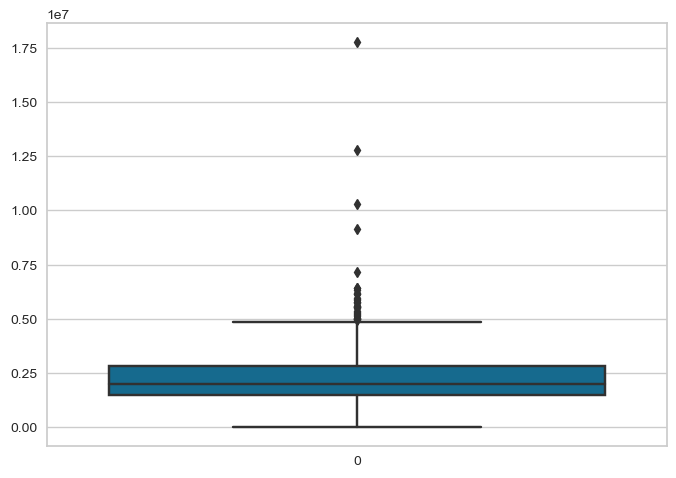

In [466]:
import seaborn as sns
sns.boxplot(rent['보증금평균'])

## 데이터 병합

In [467]:
df = pd.merge(living_popul_year, resident_popul_year, on=['상권_구분_코드_명','상권_코드_명'])
# df = pd.merge(df, area)
df = pd.merge(df, store_year,on=['상권_구분_코드_명','상권_코드_명'])
df = pd.merge(df, working_popul_year,on=['상권_구분_코드_명','상권_코드_명'])
df = pd.merge(df, facilitie_year,on=['상권_구분_코드_명','상권_코드_명'])
df = pd.merge(df, estimated_sales_year,on=['상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명'])

In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11513 entries, 0 to 11512
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상권_구분_코드_명   11513 non-null  object 
 1   상권_코드_명      11513 non-null  object 
 2   총_유동인구_수     11513 non-null  float64
 3   총_상주인구_수     11513 non-null  int64  
 4   서비스_업종_코드_명  11513 non-null  object 
 5   유사_업종_점포_수   11513 non-null  int64  
 6   개업_점포_수      11513 non-null  int64  
 7   폐업_점포_수      11513 non-null  int64  
 8   총_직장_인구_수    11513 non-null  int64  
 9   집객시설수        11513 non-null  float64
 10  교통시설수        11513 non-null  float64
 11  당월_매출_금액     11513 non-null  float64
 12  당월_매출_건수     11513 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 1.2+ MB


In [469]:
df.head()

상권_구분_코드_명       상권_코드_명   총_유동인구_수  총_상주인구_수 서비스_업종_코드_명  유사_업종_점포_수  \
0       골목상권  4.19민주묘지역 2번 868030.000      1247         미용실           3   
1       골목상권  4.19민주묘지역 2번 868030.000      1247       분식전문점           3   
2       골목상권  4.19민주묘지역 2번 868030.000      1247       일식음식점           3   
3       골목상권  4.19민주묘지역 2번 868030.000      1247       치킨전문점           3   
4       골목상권  4.19민주묘지역 2번 868030.000      1247       커피-음료           4   

   개업_점포_수  폐업_점포_수  총_직장_인구_수  집객시설수  교통시설수      당월_매출_금액  당월_매출_건수  
0        0        0         96  1.000  4.000  34384167.000  1306.500  
1        0        0         96  1.000  4.000 116484380.667 11618.333  
2        0        0         96  1.000  4.000  18435727.000  1519.250  
3        0        0         96  1.000  4.000  66483629.000  2189.750  
4        0        0         96  1.000  4.000 366772357.500 44223.750

### 데이터 내보내기

In [470]:
# df.to_csv('./data.csv')

## 상관분석

## 다중공선성

In [471]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def backward_elimination(X, y, significance_level=0.05):
    num_features = len(X.columns)
    for i in range(num_features):
        model = sm.OLS(y, X).fit()
        max_p_value = max(model.pvalues)
        if max_p_value > significance_level:
            remove_feature = model.pvalues.idxmax()
            X = X.drop(remove_feature, axis=1)
            print(f"제거된 특성: {remove_feature} (p-값: {max_p_value})")
        else:
            break
    return X

# 데이터를 X (특성) 및 y (타겟)로 분할
X = df.drop('당월_매출_금액', axis=1)
X = X.select_dtypes(include='number')
y = df['당월_매출_금액']

# 절편을 위한 특성 행렬에 상수 항 추가
X = sm.add_constant(X)

# Backward Elimination 수행
X_eliminated = backward_elimination(X, y)

# 최종 모델 피팅
final_model = sm.OLS(y, X_eliminated)

제거된 특성: 총_상주인구_수 (p-값: 0.13183522866314532)
제거된 특성: 총_직장_인구_수 (p-값: 0.05538876644881089)


In [472]:
X_eliminated

const   총_유동인구_수  유사_업종_점포_수  개업_점포_수  폐업_점포_수  집객시설수  교통시설수  당월_매출_건수
0      1.000 868030.000           3        0        0  1.000  4.000  1306.500
1      1.000 868030.000           3        0        0  1.000  4.000 11618.333
2      1.000 868030.000           3        0        0  1.000  4.000  1519.250
3      1.000 868030.000           3        0        0  1.000  4.000  2189.750
4      1.000 868030.000           4        0        0  1.000  4.000 44223.750
...      ...        ...         ...      ...      ...    ...    ...       ...
11508  1.000 137171.500           4        0        0  3.000  2.000  4986.750
11509  1.000 137171.500           3        0        0  3.000  2.000 58693.250
11510  1.000 137171.500           3        0        0  3.000  2.000    95.500
11511  1.000 137171.500           3        0        0  3.000  2.000 24502.250
11512  1.000 137171.500          16        0        2  3.000  2.000 19777.000

[11513 rows x 8 columns]

## 주성분분석

In [550]:
def pac_function(df,k):
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    
    numeric_columns = df.select_dtypes(include='number')
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_columns)
    
    # PCA 적용
    pca = PCA()
    principal_components = pca.fit_transform(scaled_data)
    
    # 설명된 분산 비율
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 설명된 분산을 그래프로 표시
    plt.plot(np.cumsum(explained_variance_ratio))
    plt.xlabel('주성분 개수')
    plt.ylabel('누적 설명 분산')
    plt.title('주성분 개수 대 누적 설명 분산')
    plt.show()
    
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('주성분 개수')
    plt.ylabel('분산')
    plt.title('주성분 개수 대 분산')
    plt.show()
    
    # 원하는 주성분 수 선택 (예: 2)
    num_components = k
    selected_components = principal_components[:, :num_components]
    
    # 주성분을 포함한 새로운 DataFrame 생성
    pc_df = pd.DataFrame(data=selected_components, columns=[f'PC{i+1}' for i in range(num_components)])
    
    # 주성분을 포함한 결과 DataFrame 표시
    # print(pc_df)
    print(np.sum(pca.explained_variance_ratio_[:k+1]))
    return pc_df

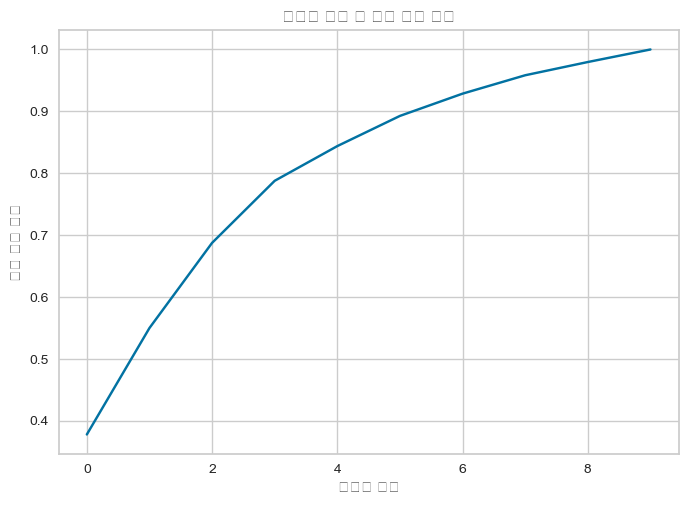

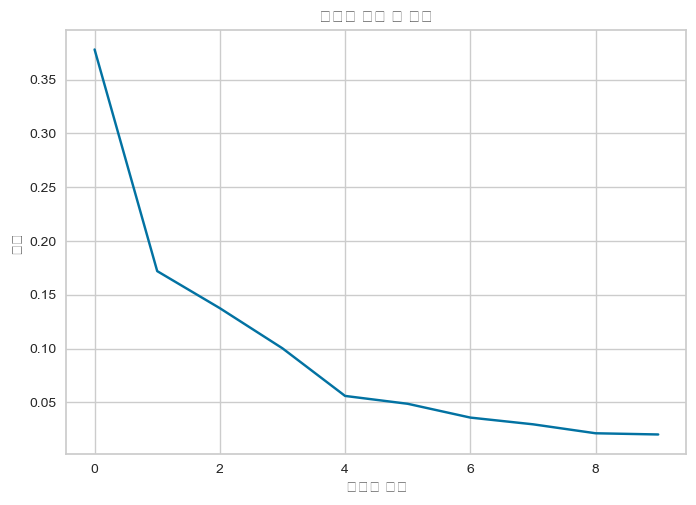

0.8439062439068529


PC1   PC2    PC3    PC4
0     -1.165 0.426 -0.342  0.009
1     -1.138 0.440 -0.354  0.053
2     -1.165 0.425 -0.342  0.008
3     -1.161 0.428 -0.344  0.015
4     -1.044 0.494 -0.387  0.188
...      ...   ...    ...    ...
11508 -1.371 0.872 -0.701 -0.074
11509 -1.241 0.937 -0.767  0.155
11510 -1.396 0.854 -0.699 -0.098
11511 -1.335 0.885 -0.726  0.001
11512 -0.656 1.560 -0.247 -0.384

[11513 rows x 4 columns]

In [734]:
pc_df = pac_function(df,4)
pc_df

In [475]:
import sklearn
sklearn.__version__


'1.2.2'

## 데이터 모델링

In [476]:
def Elbow_function(df):
    from yellowbrick.cluster import KElbowVisualizer
    from sklearn.cluster import KMeans
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1,10))
    visualizer.fit(df)

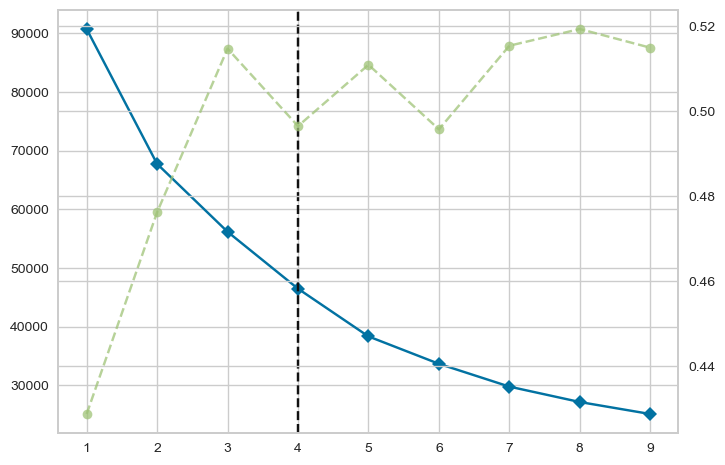

In [731]:
Elbow_function(pc_df)

In [478]:
def kmeans_modeling_function(df,k):
    from sklearn.cluster import KMeans
    # df_scale = pc_df.copy()
    # k = 4
    
    # 그룹 수, random_state 설정
    model = KMeans(n_clusters = k, random_state = 10)
    
    # 정규화된 데이터에 학습
    model.fit(df)
    
    # 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
    df['cluster'] = model.fit_predict(df)

    print(df['cluster'].value_counts())
    
    return df

In [735]:
kmeans_modeling_function(pc_df,4)

0    7985
2    2503
1     981
3      44
Name: cluster, dtype: int64


PC1   PC2    PC3    PC4  cluster
0     -1.165 0.426 -0.342  0.009        0
1     -1.138 0.440 -0.354  0.053        0
2     -1.165 0.425 -0.342  0.008        0
3     -1.161 0.428 -0.344  0.015        0
4     -1.044 0.494 -0.387  0.188        0
...      ...   ...    ...    ...      ...
11508 -1.371 0.872 -0.701 -0.074        0
11509 -1.241 0.937 -0.767  0.155        0
11510 -1.396 0.854 -0.699 -0.098        0
11511 -1.335 0.885 -0.726  0.001        0
11512 -0.656 1.560 -0.247 -0.384        0

[11513 rows x 5 columns]

In [486]:
def Model_performance_evaluation(df,n):
    from sklearn.decomposition import PCA
 
    pca = PCA(n_components = n)
    pca_transformed = pca.fit_transform(df)
    pca_transformed
    
    df['pca_x'] = pca_transformed[:, 0]  #x좌표
    df['pca_y'] = pca_transformed[:, 1]  #y좌표

    import matplotlib.pyplot as plt

    markers = {}  # Create a dictionary to store markers

    for i in range(n):
        markers[f'marker{i}'] = df[df['cluster'] == i].index
        plt.scatter(x=df.loc[markers[f'marker{i}'], 'pca_x'], y=df.loc[markers[f'marker{i}'], 'pca_y'], marker='o')
    
    
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    # plt.title(f'{n} Clusters Visualization by 2 PCA Components')
    plt.legend(['cluster0', 'cluster1', 'cluster2','cluster3'])
    plt.show()

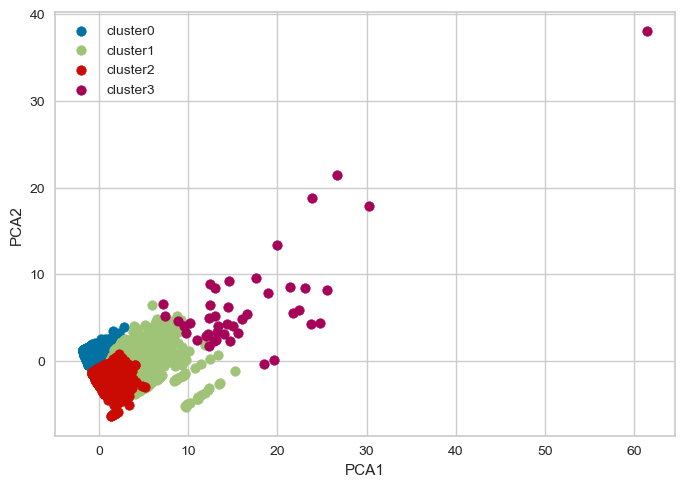

In [736]:
Model_performance_evaluation(pc_df,4)

In [503]:
def DBSCAN_modeling_function(df):
    from sklearn.metrics import silhouette_score
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import DBSCAN
    from sklearn.datasets import make_blobs

    # Example grid search
    eps_values = list(np.linspace(0.5,20,num=40))
    min_samples_values = list(np.arange(2,25,step=2))
    
    best_score = -1
    best_eps = None
    best_min_samples = None
    
    try:
        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(df)

                # Silhouette score is just one possible metric, you may explore other metrics
                score = silhouette_score(df, labels)

                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples
    except:
        pass
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels = dbscan.fit_predict(df)
    
    df['cluster'] = labels

    print(df['cluster'].value_counts())
    print(f'모델 성능 : {best_score}')
    return df
    

In [481]:
list(np.arange(2,25,step=2))

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

In [482]:
DBSCAN_modeling_function(pc_df)

 0    11511
-1        2
Name: cluster, dtype: int64
모델 성능 : 0.9593774346680699


PC1   PC2    PC3    PC4  cluster
0     -1.165 0.426 -0.342  0.009        0
1     -1.138 0.440 -0.354  0.053        0
2     -1.165 0.425 -0.342  0.008        0
3     -1.161 0.428 -0.344  0.015        0
4     -1.044 0.494 -0.387  0.188        0
...      ...   ...    ...    ...      ...
11508 -1.371 0.872 -0.701 -0.074        0
11509 -1.241 0.937 -0.767  0.155        0
11510 -1.396 0.854 -0.699 -0.098        0
11511 -1.335 0.885 -0.726  0.001        0
11512 -0.656 1.560 -0.247 -0.384        0

[11513 rows x 5 columns]

In [483]:
# tensorflow device 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2789501493578462599,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5729419264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4142319246607281867
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [484]:
import tensorflow as tf

print(f'tf.__version__: {tf.__version__}')

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.list_physical_devices('GPU') 이 코드도 가능
for gpu in gpus:
    print(gpu)

tf.__version__: 2.6.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [485]:
pc_df

PC1   PC2    PC3    PC4  cluster
0     -1.165 0.426 -0.342  0.009        0
1     -1.138 0.440 -0.354  0.053        0
2     -1.165 0.425 -0.342  0.008        0
3     -1.161 0.428 -0.344  0.015        0
4     -1.044 0.494 -0.387  0.188        0
...      ...   ...    ...    ...      ...
11508 -1.371 0.872 -0.701 -0.074        0
11509 -1.241 0.937 -0.767  0.155        0
11510 -1.396 0.854 -0.699 -0.098        0
11511 -1.335 0.885 -0.726  0.001        0
11512 -0.656 1.560 -0.247 -0.384        0

[11513 rows x 5 columns]

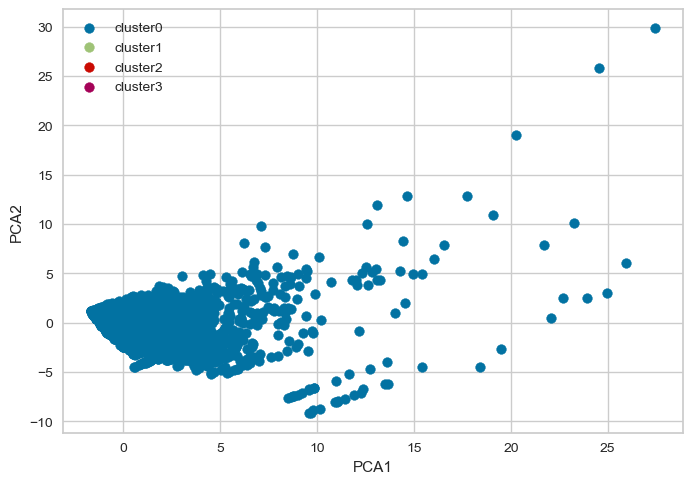

In [487]:
Model_performance_evaluation(pc_df,4)

## 서비스 업종별 모델링

In [488]:
df['서비스_업종_코드_명'].unique()

array(['미용실', '분식전문점', '일식음식점', '치킨전문점', '커피-음료', '패스트푸드점', '편의점',
       '한식음식점', '일반교습학원', '일반의류', '호프-간이주점', '노래방', '일반의원', '치과의원',
       '중식음식점', '의약품', '양식음식점', '제과점'], dtype=object)

### 미용실

In [520]:
df_hair_shop = df[df['서비스_업종_코드_명']=='미용실']
df_hair_shop = df_hair_shop.reset_index(drop=True)
df_hair_shop.shape

(1032, 13)

In [519]:
# df_hair_shop = df_hair_shop.reset_index(drop=True)

상권_구분_코드_명            상권_코드_명   총_유동인구_수  총_상주인구_수 서비스_업종_코드_명  유사_업종_점포_수  \
0       골목상권       4.19민주묘지역 2번 868030.000      1247         미용실           3   
1       골목상권          GS강동자이아파트 839601.250      3443         미용실          15   
2       골목상권       KB국민은행 망원동지점 836247.500      2759         미용실          15   
3       골목상권       KB국민은행 중화동지점 549436.750      2503         미용실           4   
4       골목상권  KT금천빌딩(금천구시설관리공단)  73141.000       225         미용실           7   

   개업_점포_수  폐업_점포_수  총_직장_인구_수  집객시설수  교통시설수      당월_매출_금액  당월_매출_건수  
0        0        0         96  1.000  4.000  34384167.000  1306.500  
1        2        1        411  1.000  3.000 101302033.250  3984.000  
2        0        0        284  4.000  3.000  24236540.750   828.750  
3        0        0        156  1.000  0.000  38464745.750   972.250  
4        0        0        426  3.000  2.000 183481130.750  5771.250

#### 주성분 분석

C:\Users\user\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45572 (\N{HANGUL SYLLABLE NU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.

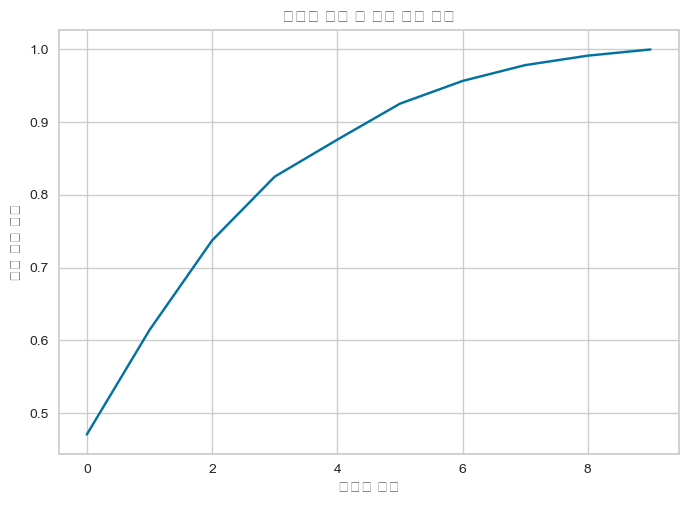

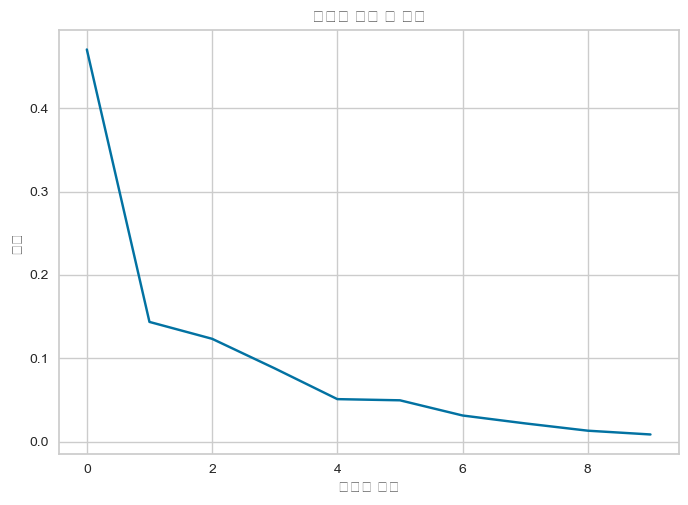

0.737282005225554


PC1    PC2    PC3    PC4
0    -1.400  0.454 -0.056  0.042
1     0.624 -0.657 -1.125 -2.208
2    -0.831 -0.060 -0.018  0.257
3    -1.625  0.087 -0.291  0.119
4    -1.227  1.142 -0.876  0.272
...     ...    ...    ...    ...
1027 -1.440  1.009 -0.406 -0.006
1028 -1.319  0.872 -0.427  0.075
1029 -1.898  0.680 -0.527 -0.033
1030 -1.440  0.395 -0.372  0.099
1031 -1.441  0.600 -0.375  0.057

[1032 rows x 4 columns]

In [490]:
pc_df = pac_function(df_hair_shop,4)
pc_df

#### K-means

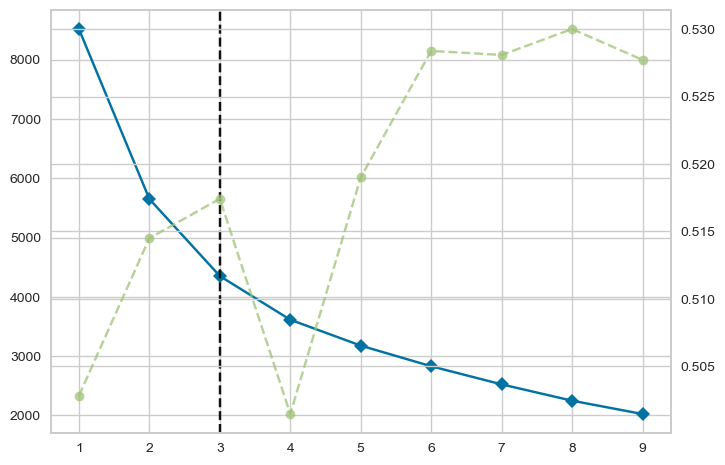

In [493]:
Elbow_function(pc_df)

In [494]:
kmeans_modeling_function(pc_df,3)

0    754
1    254
2     24
Name: cluster, dtype: int64


PC1    PC2    PC3    PC4  cluster
0    -1.400  0.454 -0.056  0.042        0
1     0.624 -0.657 -1.125 -2.208        1
2    -0.831 -0.060 -0.018  0.257        0
3    -1.625  0.087 -0.291  0.119        0
4    -1.227  1.142 -0.876  0.272        0
...     ...    ...    ...    ...      ...
1027 -1.440  1.009 -0.406 -0.006        0
1028 -1.319  0.872 -0.427  0.075        0
1029 -1.898  0.680 -0.527 -0.033        0
1030 -1.440  0.395 -0.372  0.099        0
1031 -1.441  0.600 -0.375  0.057        0

[1032 rows x 5 columns]

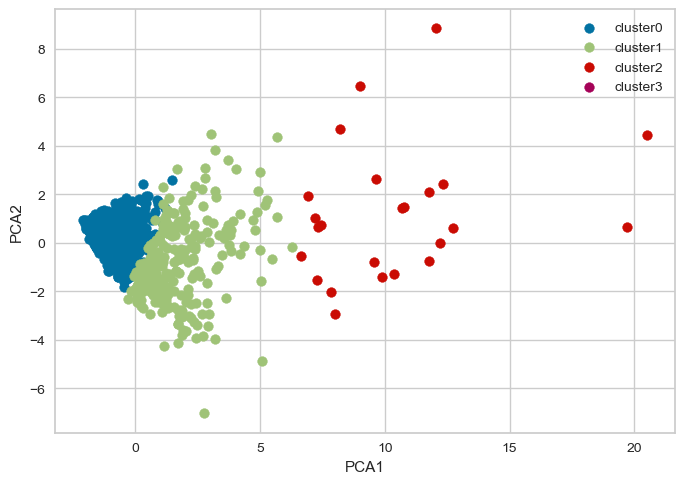

In [496]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [504]:
DBSCAN_modeling_function(pc_df)

 0    1030
-1       2
Name: cluster, dtype: int64
모델 성능 : 0.865660424007426


PC1    PC2    PC3    PC4  cluster  pca_x  pca_y
0    -1.400  0.454 -0.056  0.042        0 -1.434  0.445
1     0.624 -0.657 -1.125 -2.208        0  0.746 -0.667
2    -0.831 -0.060 -0.018  0.257        0 -0.871 -0.052
3    -1.625  0.087 -0.291  0.119        0 -1.653  0.083
4    -1.227  1.142 -0.876  0.272        0 -1.272  1.164
...     ...    ...    ...    ...      ...    ...    ...
1027 -1.440  1.009 -0.406 -0.006        0 -1.479  1.009
1028 -1.319  0.872 -0.427  0.075        0 -1.359  0.876
1029 -1.898  0.680 -0.527 -0.033        0 -1.926  0.674
1030 -1.440  0.395 -0.372  0.099        0 -1.474  0.397
1031 -1.441  0.600 -0.375  0.057        0 -1.477  0.601

[1032 rows x 7 columns]

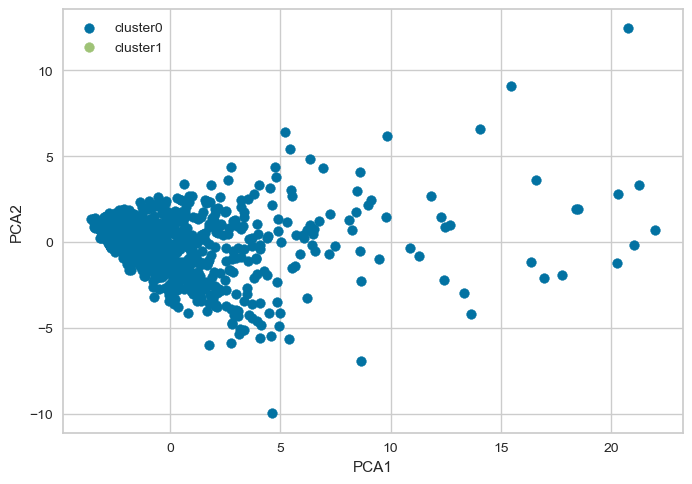

In [506]:
Model_performance_evaluation(pc_df,2)

In [523]:
def df_concat(df):
    df = pd.concat([df.select_dtypes(include=['object']),pc_df['cluster']],axis=1)
    return df

In [526]:
hair_cluster = df_concat(df_hair_shop)
hair_cluster.head()

상권_구분_코드_명            상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권       4.19민주묘지역 2번         미용실        0
1       골목상권          GS강동자이아파트         미용실        0
2       골목상권       KB국민은행 망원동지점         미용실        0
3       골목상권       KB국민은행 중화동지점         미용실        0
4       골목상권  KT금천빌딩(금천구시설관리공단)         미용실        0

### 분식전문점

In [529]:
df_school_food = df[df['서비스_업종_코드_명']=='분식전문점']
df_school_food = df_school_food.reset_index(drop=True)
df_school_food.shape

(785, 13)

#### 주성분분석

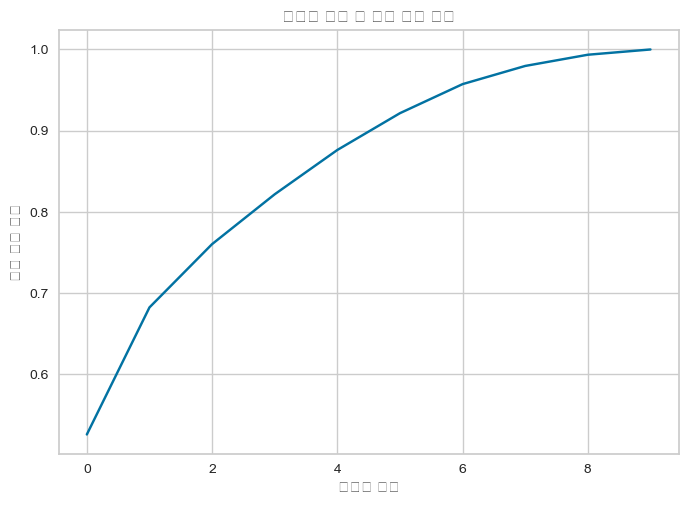

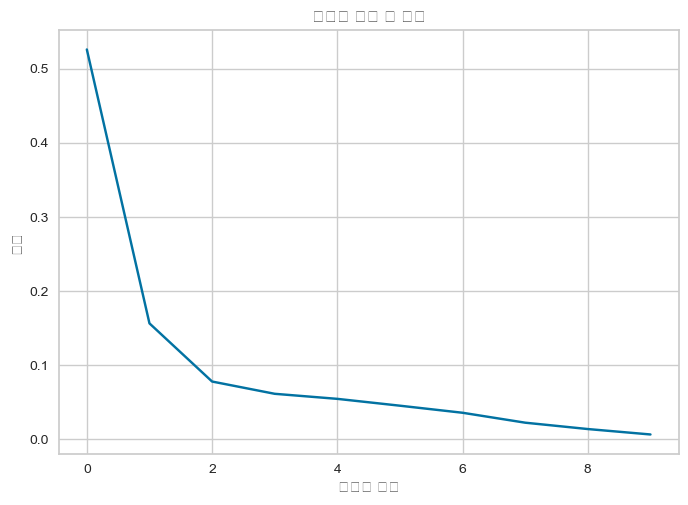

0.5260365354866162


PC1    PC2
0   -1.427 -0.510
1   -1.765 -0.059
2   -0.608  0.040
3   -1.322 -1.118
4   -1.736 -1.116
..     ...    ...
780 -0.974 -0.863
781 -1.624 -1.055
782 -1.491 -0.651
783 -1.160 -0.839
784 -1.618 -1.078

[785 rows x 2 columns]

In [532]:
pc_df = pac_function(df_school_food,2)
pc_df

#### K-means

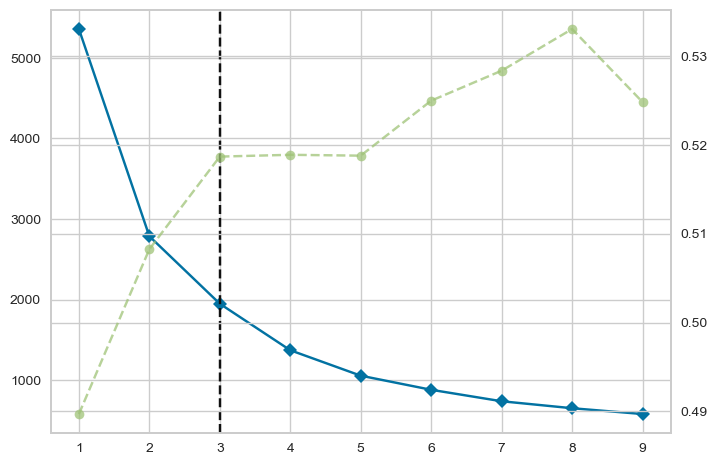

In [533]:
Elbow_function(pc_df)

In [534]:
kmeans_modeling_function(pc_df,3)

0    540
2    211
1     34
Name: cluster, dtype: int64


PC1    PC2  cluster
0   -1.427 -0.510        0
1   -1.765 -0.059        0
2   -0.608  0.040        0
3   -1.322 -1.118        0
4   -1.736 -1.116        0
..     ...    ...      ...
780 -0.974 -0.863        0
781 -1.624 -1.055        0
782 -1.491 -0.651        0
783 -1.160 -0.839        0
784 -1.618 -1.078        0

[785 rows x 3 columns]

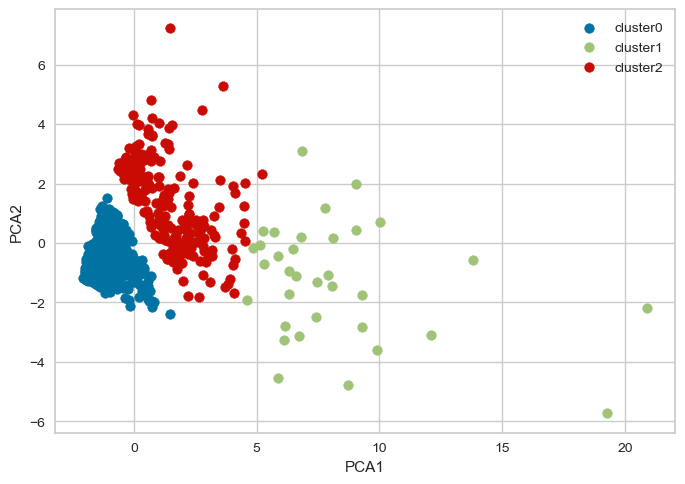

In [536]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [537]:
DBSCAN_modeling_function(pc_df)

 0    783
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.8573945391702777


PC1    PC2  cluster  pca_x  pca_y
0   -1.427 -0.510        0 -1.528 -0.540
1   -1.765 -0.059        0 -1.847 -0.091
2   -0.608  0.040        0 -0.712 -0.122
3   -1.322 -1.118        0 -1.442 -1.110
4   -1.736 -1.116        0 -1.847 -1.065
..     ...    ...      ...    ...    ...
780 -0.974 -0.863        0 -1.095 -0.912
781 -1.624 -1.055        0 -1.736 -1.021
782 -1.491 -0.651        0 -1.595 -0.663
783 -1.160 -0.839        0 -1.276 -0.871
784 -1.618 -1.078        0 -1.731 -1.042

[785 rows x 5 columns]

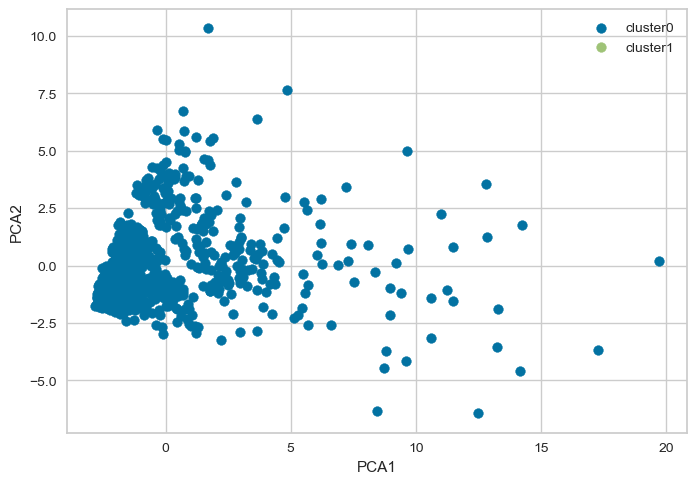

In [538]:
Model_performance_evaluation(pc_df,2)

In [539]:
school_food_cluster = df_concat(df_school_food)
school_food_cluster.head()

상권_구분_코드_명            상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권       4.19민주묘지역 2번       분식전문점        0
1       골목상권                G타워       분식전문점        0
2       골목상권       KB국민은행 망원동지점       분식전문점        0
3       골목상권  KT금천빌딩(금천구시설관리공단)       분식전문점        0
4       골목상권             KT대방빌딩       분식전문점        0

### 한식음식점

In [543]:
df_korean_food = df[df['서비스_업종_코드_명']=='한식음식점']
df_korean_food = df_korean_food.reset_index(drop=True)
df_korean_food.shape

(1345, 13)

#### 주성분분석

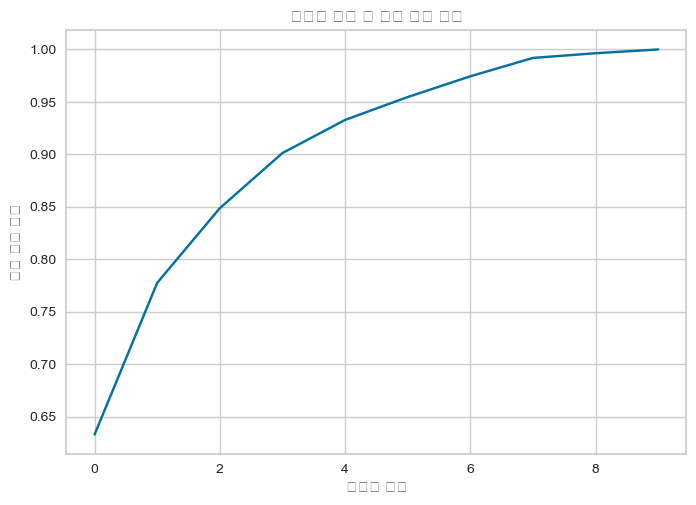

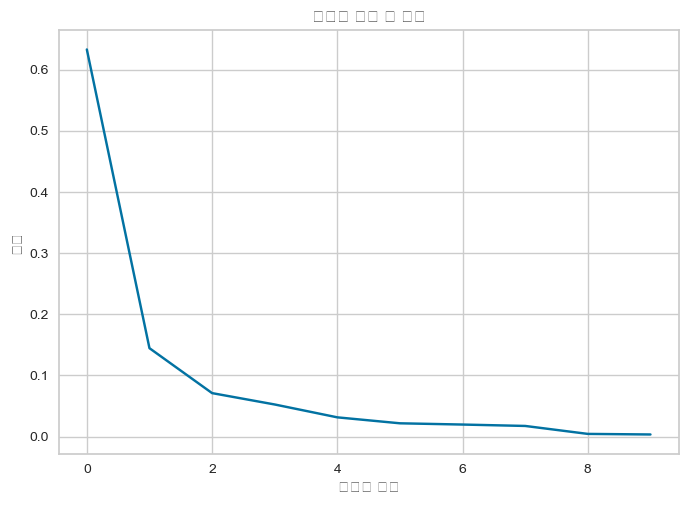

0.8486726725971269


PC1    PC2
0    -0.529 -0.325
1    -1.078  0.414
2    -1.516  0.229
3     0.079  0.060
4    -1.635 -0.896
...     ...    ...
1340 -1.474 -0.824
1341 -1.160 -0.247
1342 -0.669 -0.421
1343 -1.028 -0.571
1344 -1.119 -0.909

[1345 rows x 2 columns]

In [551]:
pc_df = pac_function(df_korean_food,2)
pc_df

#### K-means

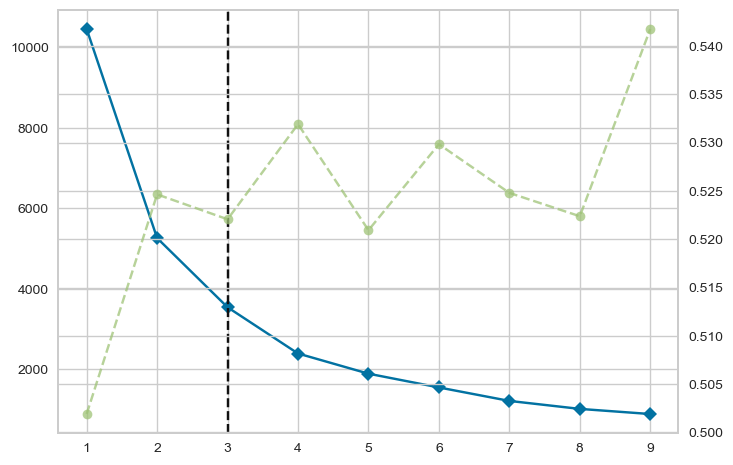

In [552]:
Elbow_function(pc_df)

In [553]:
kmeans_modeling_function(pc_df,3)

2    1009
0     298
1      38
Name: cluster, dtype: int64


PC1    PC2  cluster
0    -0.529 -0.325        2
1    -1.078  0.414        2
2    -1.516  0.229        2
3     0.079  0.060        2
4    -1.635 -0.896        2
...     ...    ...      ...
1340 -1.474 -0.824        2
1341 -1.160 -0.247        2
1342 -0.669 -0.421        2
1343 -1.028 -0.571        2
1344 -1.119 -0.909        2

[1345 rows x 3 columns]

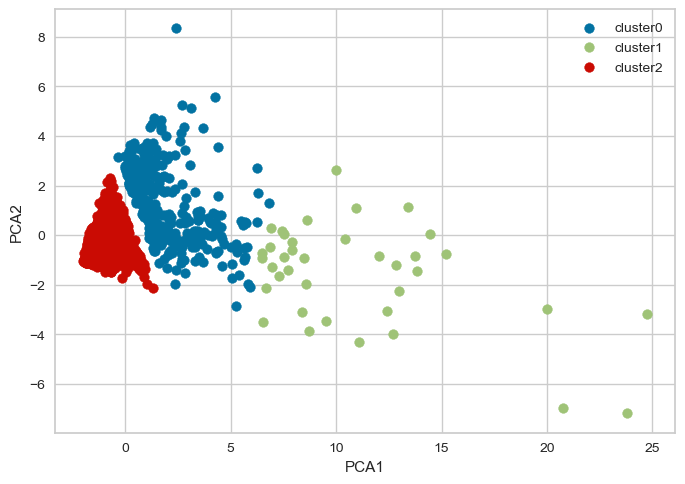

In [555]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [556]:
DBSCAN_modeling_function(pc_df)

 0    1341
-1       4
Name: cluster, dtype: int64
모델 성능 : 0.8741963217201701


PC1    PC2  cluster  pca_x  pca_y
0    -0.529 -0.325        0 -0.612 -0.422
1    -1.078  0.414        0 -1.140  0.315
2    -1.516  0.229        0 -1.574  0.175
3     0.079  0.060        0 -0.010 -0.108
4    -1.635 -0.896        0 -1.707 -0.873
...     ...    ...      ...    ...    ...
1340 -1.474 -0.824        0 -1.548 -0.817
1341 -1.160 -0.247        0 -1.231 -0.299
1342 -0.669 -0.421        0 -0.751 -0.501
1343 -1.028 -0.571        0 -1.106 -0.614
1344 -1.119 -0.909        0 -1.200 -0.924

[1345 rows x 5 columns]

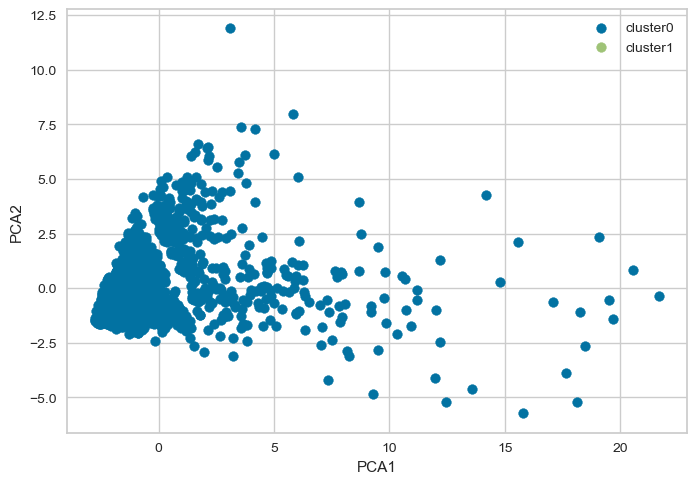

In [557]:
Model_performance_evaluation(pc_df,2)

In [ ]:
korean_food_cluster = df_concat(df_korean_food)
korean_food_cluster.head()

### 커피-음료

In [565]:
df_cafe = df[df['서비스_업종_코드_명']=='커피-음료']
df_cafe = df_cafe.reset_index(drop=True)
df_cafe.shape

(952, 13)

#### 주성분분석

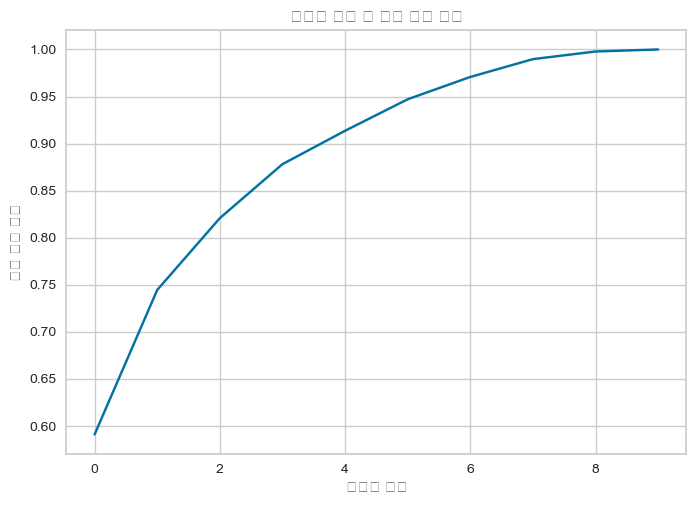

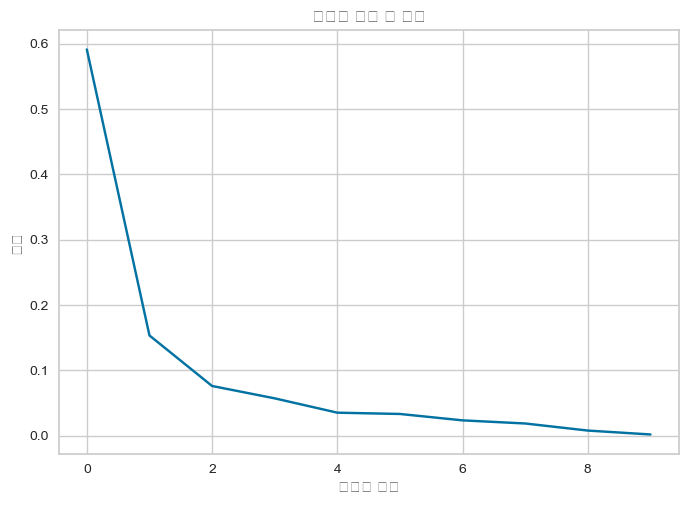

0.820767778279137


PC1    PC2
0   -1.221 -0.561
1   -0.282  0.168
2   -0.288  0.099
3   -0.610 -0.073
4   -0.932 -1.212
..     ...    ...
947 -0.321 -1.260
948 -1.485 -1.147
949 -1.328 -1.030
950 -1.670 -1.015
951 -1.174 -0.809

[952 rows x 2 columns]

In [567]:
pc_df = pac_function(df_cafe,2)
pc_df

#### K-means

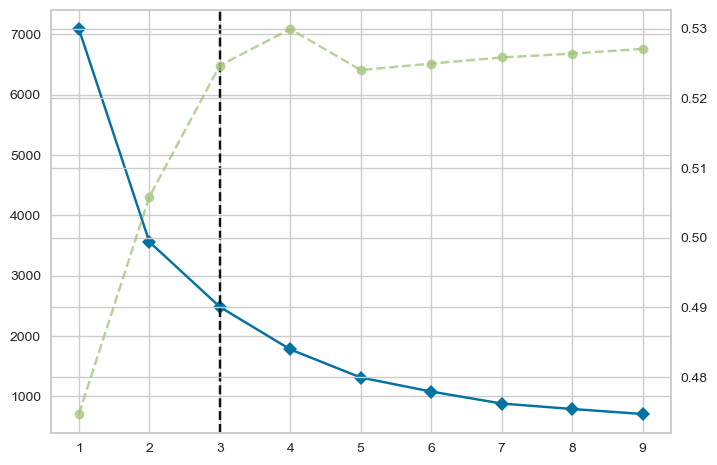

In [568]:
Elbow_function(pc_df)

In [569]:
kmeans_modeling_function(pc_df,3)

0    692
1    229
2     31
Name: cluster, dtype: int64


PC1    PC2  cluster
0   -1.221 -0.561        0
1   -0.282  0.168        0
2   -0.288  0.099        0
3   -0.610 -0.073        0
4   -0.932 -1.212        0
..     ...    ...      ...
947 -0.321 -1.260        0
948 -1.485 -1.147        0
949 -1.328 -1.030        0
950 -1.670 -1.015        0
951 -1.174 -0.809        0

[952 rows x 3 columns]

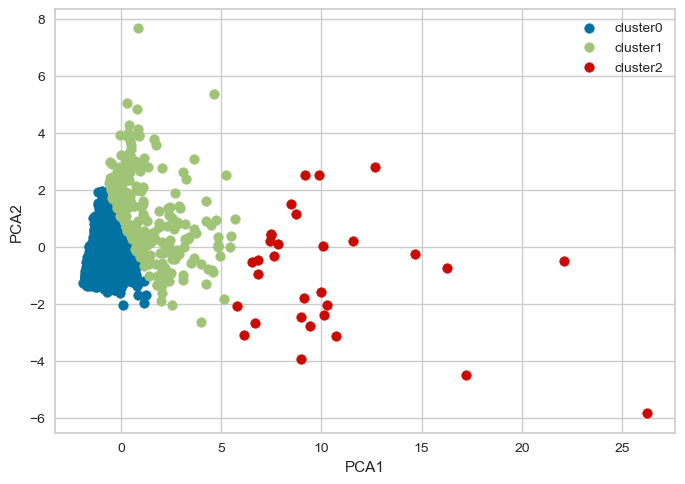

In [570]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [571]:
DBSCAN_modeling_function(pc_df)

 0    951
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.8942405739190175


PC1    PC2  cluster  pca_x  pca_y
0   -1.221 -0.561        0 -1.260 -0.559
1   -0.282  0.168        0 -0.328  0.131
2   -0.288  0.099        0 -0.335  0.063
3   -0.610 -0.073        0 -0.653 -0.097
4   -0.932 -1.212        0 -0.980 -1.213
..     ...    ...      ...    ...    ...
947 -0.321 -1.260        0 -0.378 -1.279
948 -1.485 -1.147        0 -1.525 -1.130
949 -1.328 -1.030        0 -1.369 -1.020
950 -1.670 -1.015        0 -1.705 -0.993
951 -1.174 -0.809        0 -1.215 -0.806

[952 rows x 5 columns]

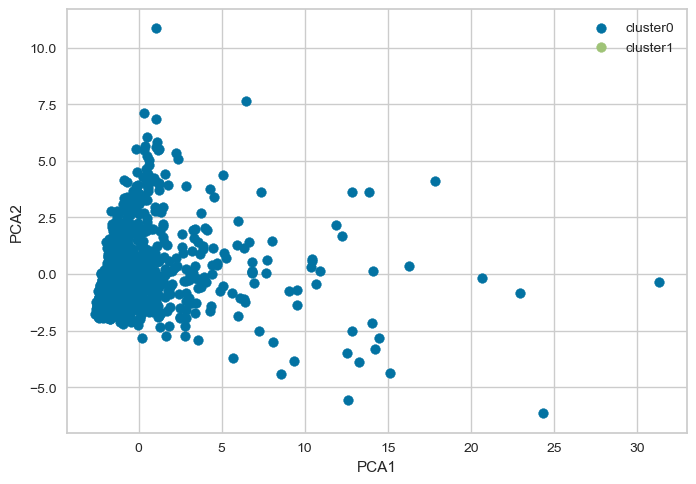

In [572]:
Model_performance_evaluation(pc_df,2)

In [573]:
cafe_cluster = df_concat(df_cafe)
cafe_cluster.head()

상권_구분_코드_명       상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권  4.19민주묘지역 2번       커피-음료        0
1       골목상권     GS강동자이아파트       커피-음료        0
2       골목상권           G타워       커피-음료        0
3       골목상권  KB국민은행 망원동지점       커피-음료        0
4       골목상권   KB국민은행 서강지점       커피-음료        0

### 편의점

In [574]:
df_store = df[df['서비스_업종_코드_명']=='편의점']
df_store = df_store.reset_index(drop=True)
df_store.shape

(868, 13)

#### 주성분분석

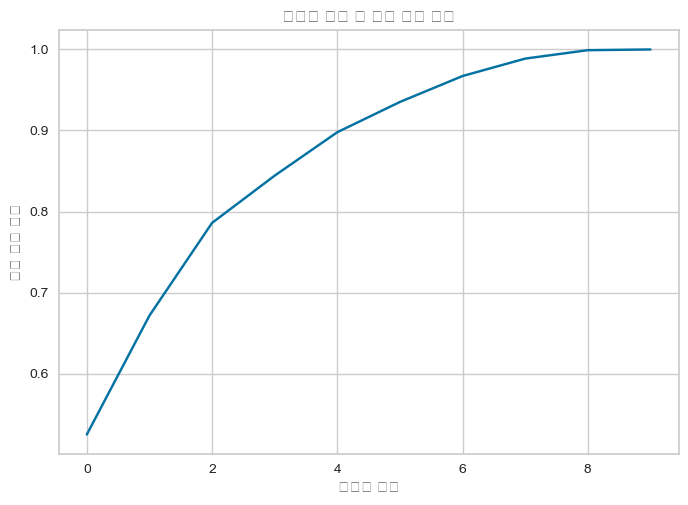

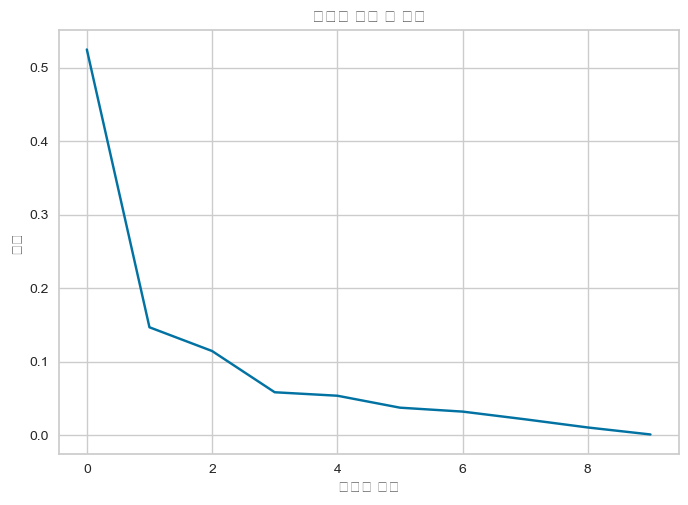

0.8443016161122514


PC1    PC2    PC3
0   -1.048 -0.559  1.127
1   -0.891  0.052  1.043
2   -0.994 -0.224 -0.280
3   -1.098 -0.276  1.070
4   -1.320  0.004 -0.310
..     ...    ...    ...
863 -0.598 -1.079 -0.315
864 -1.135 -0.945  1.105
865 -1.622 -0.571 -0.177
866 -1.599 -0.932 -0.146
867 -1.703 -1.212 -0.058

[868 rows x 3 columns]

In [576]:
pc_df = pac_function(df_store,3)
pc_df

#### K-means

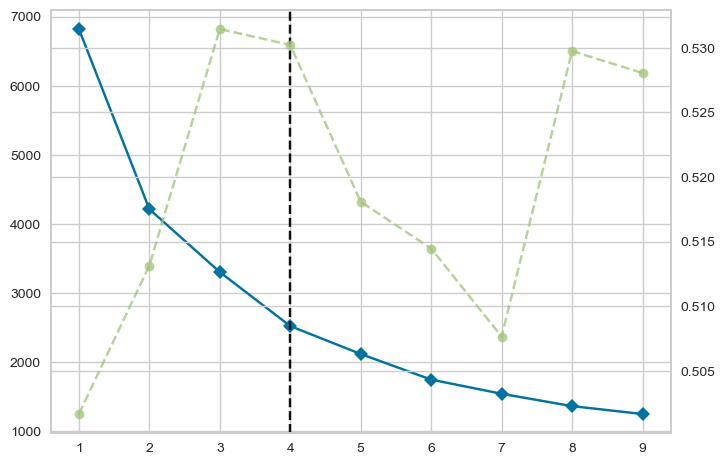

In [577]:
Elbow_function(pc_df)

In [578]:
kmeans_modeling_function(pc_df,4)

0    553
2    214
3     96
1      5
Name: cluster, dtype: int64


PC1    PC2    PC3  cluster
0   -1.048 -0.559  1.127        0
1   -0.891  0.052  1.043        0
2   -0.994 -0.224 -0.280        0
3   -1.098 -0.276  1.070        0
4   -1.320  0.004 -0.310        0
..     ...    ...    ...      ...
863 -0.598 -1.079 -0.315        0
864 -1.135 -0.945  1.105        0
865 -1.622 -0.571 -0.177        0
866 -1.599 -0.932 -0.146        0
867 -1.703 -1.212 -0.058        0

[868 rows x 4 columns]

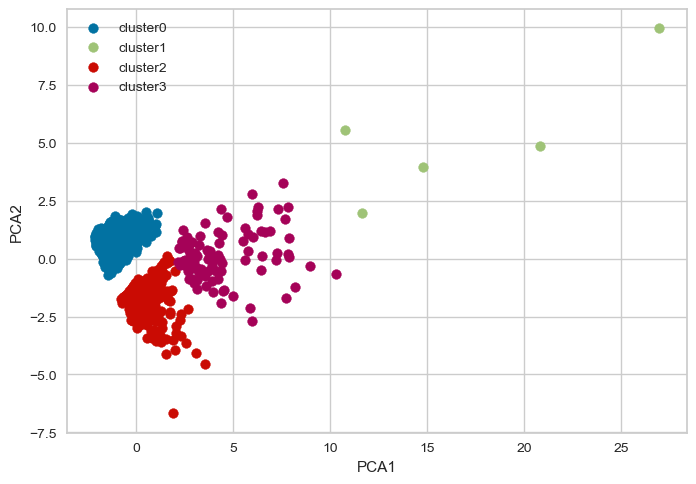

In [579]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [580]:
DBSCAN_modeling_function(pc_df)

 0    867
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.8930695159607996


PC1    PC2    PC3  cluster  pca_x  pca_y
0   -1.048 -0.559  1.127        0 -1.280  0.616
1   -0.891  0.052  1.043        0 -1.105  0.123
2   -0.994 -0.224 -0.280        0 -1.219  0.390
3   -1.098 -0.276  1.070        0 -1.315  0.364
4   -1.320  0.004 -0.310        0 -1.516  0.129
..     ...    ...    ...      ...    ...    ...
863 -0.598 -1.079 -0.315        0 -0.884  1.208
864 -1.135 -0.945  1.105        0 -1.380  0.932
865 -1.622 -0.571 -0.177        0 -1.828  0.560
866 -1.599 -0.932 -0.146        0 -1.823  0.874
867 -1.703 -1.212 -0.058        0 -1.933  1.092

[868 rows x 6 columns]

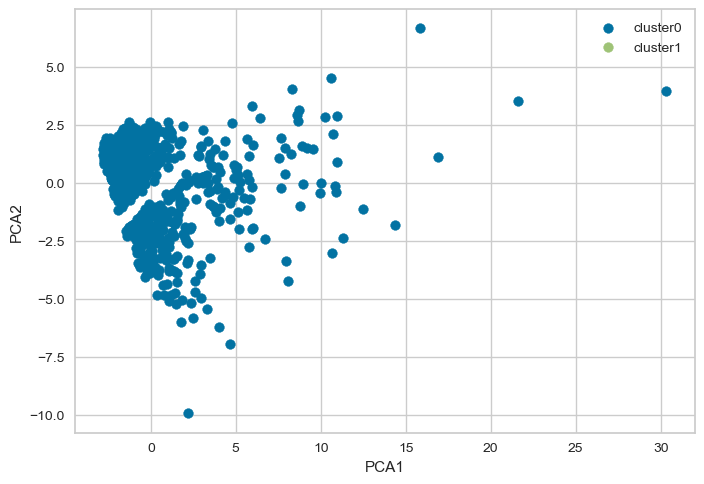

In [581]:
Model_performance_evaluation(pc_df,2)

In [582]:
store_cluster = df_concat(df_store)
store_cluster.head()

상권_구분_코드_명       상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권  4.19민주묘지역 2번         편의점        0
1       골목상권     GS강동자이아파트         편의점        0
2       골목상권           G타워         편의점        0
3       골목상권        KT월곡지사         편의점        0
4       골목상권  NH농협은행 보광동지점         편의점        0

### 일반의류

In [583]:
df_clothes = df[df['서비스_업종_코드_명']=='일반의류']
df_clothes = df_clothes.reset_index(drop=True)
df_clothes.shape

(798, 13)

#### 주성분분석

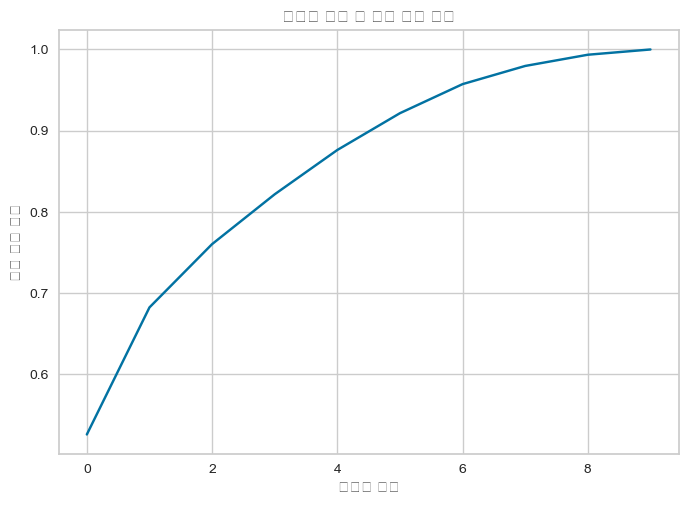

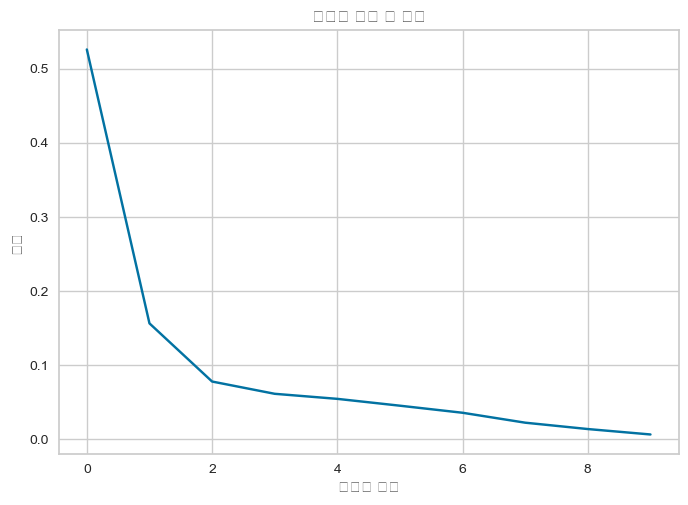

0.7603714108417663


PC1    PC2
0   -1.427 -0.510
1   -1.765 -0.059
2   -0.608  0.040
3   -1.322 -1.118
4   -1.736 -1.116
..     ...    ...
780 -0.974 -0.863
781 -1.624 -1.055
782 -1.491 -0.651
783 -1.160 -0.839
784 -1.618 -1.078

[785 rows x 2 columns]

In [584]:
pc_df = pac_function(df_school_food,2)
pc_df

#### K-means

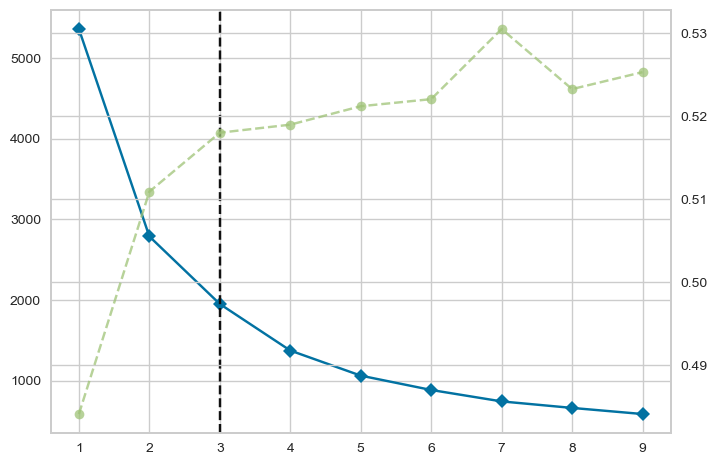

In [585]:
Elbow_function(pc_df)

In [586]:
kmeans_modeling_function(pc_df,3)

0    540
2    211
1     34
Name: cluster, dtype: int64


PC1    PC2  cluster
0   -1.427 -0.510        0
1   -1.765 -0.059        0
2   -0.608  0.040        0
3   -1.322 -1.118        0
4   -1.736 -1.116        0
..     ...    ...      ...
780 -0.974 -0.863        0
781 -1.624 -1.055        0
782 -1.491 -0.651        0
783 -1.160 -0.839        0
784 -1.618 -1.078        0

[785 rows x 3 columns]

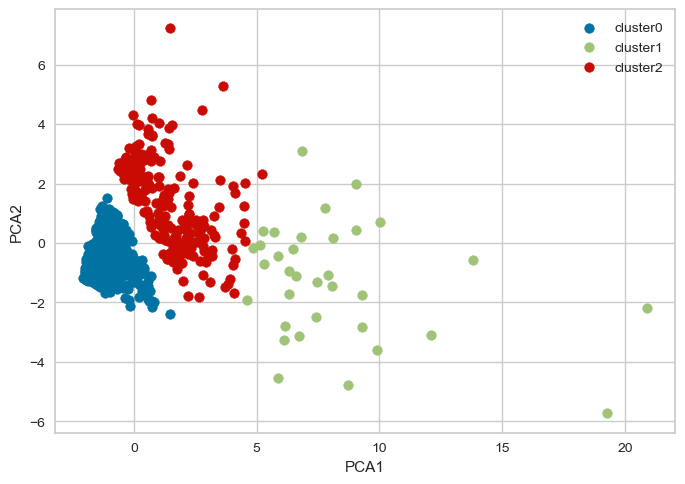

In [588]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [589]:
DBSCAN_modeling_function(pc_df)

 0    783
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.8573945391702777


PC1    PC2  cluster  pca_x  pca_y
0   -1.427 -0.510        0 -1.528 -0.540
1   -1.765 -0.059        0 -1.847 -0.091
2   -0.608  0.040        0 -0.712 -0.122
3   -1.322 -1.118        0 -1.442 -1.110
4   -1.736 -1.116        0 -1.847 -1.065
..     ...    ...      ...    ...    ...
780 -0.974 -0.863        0 -1.095 -0.912
781 -1.624 -1.055        0 -1.736 -1.021
782 -1.491 -0.651        0 -1.595 -0.663
783 -1.160 -0.839        0 -1.276 -0.871
784 -1.618 -1.078        0 -1.731 -1.042

[785 rows x 5 columns]

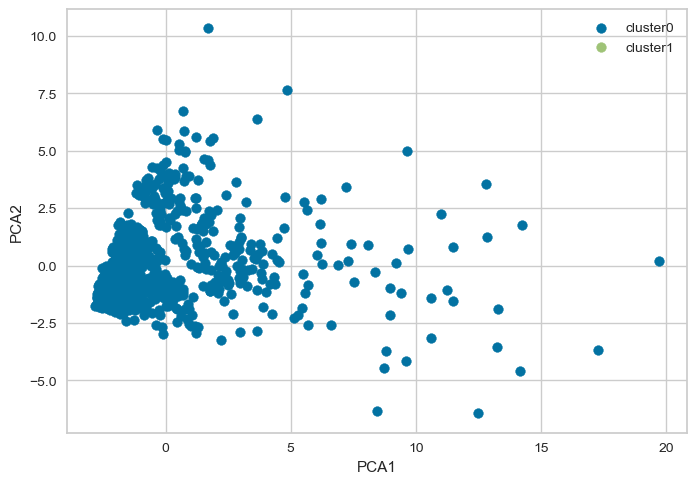

In [590]:
Model_performance_evaluation(pc_df,2)

In [591]:
clothes_cluster = df_concat(df_clothes)
clothes_cluster.head()

상권_구분_코드_명       상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권     GS강동자이아파트        일반의류    0.000
1       골목상권  KB국민은행 망원동지점        일반의류    0.000
2       골목상권  NH농협은행 보광동지점        일반의류    0.000
3       골목상권  NH농협은행 상도동지점        일반의류    0.000
4       골목상권       가산동주민센터        일반의류    0.000

### 호프-간이주점

In [592]:
df_pub = df[df['서비스_업종_코드_명']=='호프-간이주점']
df_pub = df_pub.reset_index(drop=True)
df_pub.shape

(664, 13)

#### 주성분분석

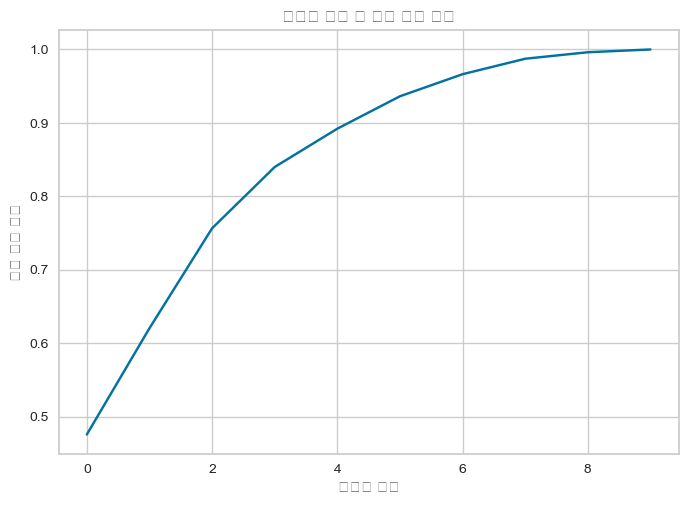

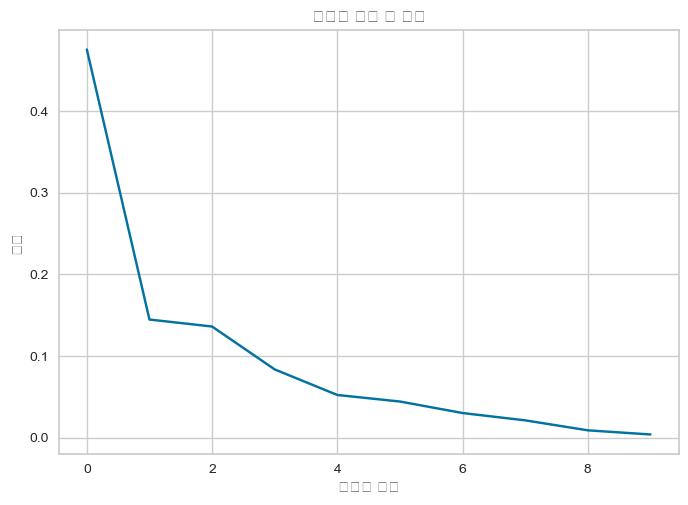

0.756455528382389


PC1    PC2
0   -1.081 -0.370
1   -0.593 -0.270
2   -1.621  0.816
3   -1.433  0.294
4    0.288 -0.152
..     ...    ...
659 -0.958  0.521
660  0.485  0.400
661 -0.106  0.749
662 -1.360  0.991
663 -1.494  0.445

[664 rows x 2 columns]

In [594]:
pc_df = pac_function(df_pub,2)
pc_df

#### K-means

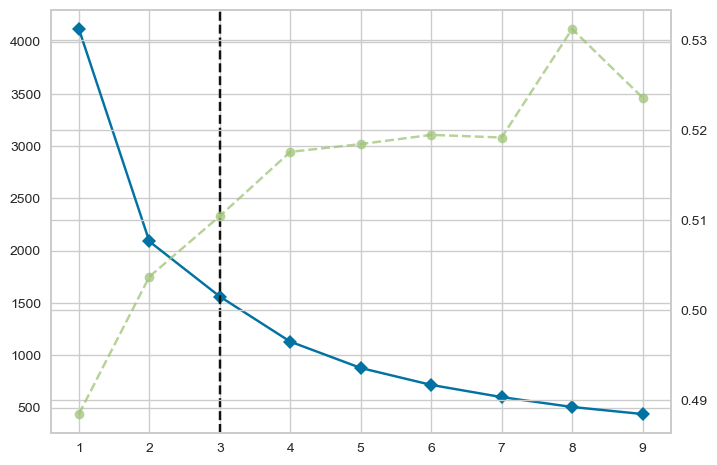

In [595]:
Elbow_function(pc_df)

In [596]:
kmeans_modeling_function(pc_df,3)

0    458
2    171
1     35
Name: cluster, dtype: int64


PC1    PC2  cluster
0   -1.081 -0.370        0
1   -0.593 -0.270        0
2   -1.621  0.816        0
3   -1.433  0.294        0
4    0.288 -0.152        0
..     ...    ...      ...
659 -0.958  0.521        0
660  0.485  0.400        0
661 -0.106  0.749        0
662 -1.360  0.991        0
663 -1.494  0.445        0

[664 rows x 3 columns]

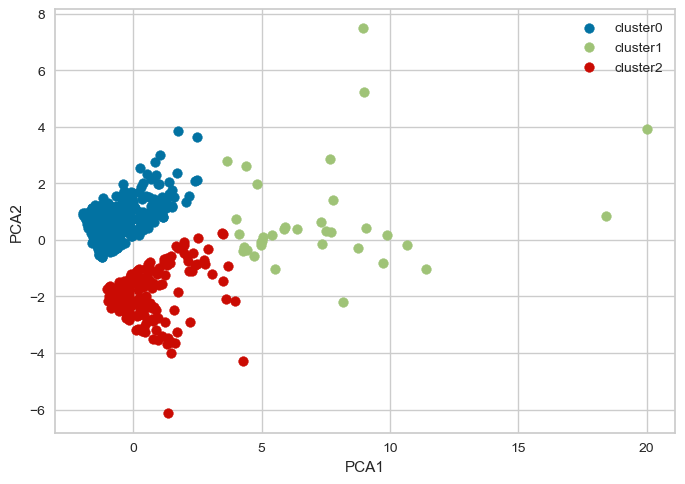

In [597]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [598]:
DBSCAN_modeling_function(pc_df)

 0    662
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.8566923016117595


PC1    PC2  cluster  pca_x  pca_y
0   -1.081 -0.370        0 -1.138 -0.137
1   -0.593 -0.270        0 -0.657 -0.005
2   -1.621  0.816        0 -1.705  0.835
3   -1.433  0.294        0 -1.505  0.402
4    0.288 -0.152        0  0.212  0.179
..     ...    ...      ...    ...    ...
659 -0.958  0.521        0 -1.041  0.643
660  0.485  0.400        0  0.391  0.673
661 -0.106  0.749        0 -0.204  0.919
662 -1.360  0.991        0 -1.452  1.010
663 -1.494  0.445        0 -1.569  0.527

[664 rows x 5 columns]

In [599]:
Model_performance_evaluation(pc_df,2)

In [600]:
pub_cluster = df_concat(df_pub)
pub_cluster.head()

상권_구분_코드_명       상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권     GS강동자이아파트     호프-간이주점        0
1       골목상권  KB국민은행 망원동지점     호프-간이주점        0
2       골목상권     KT&G 북부지사     호프-간이주점        0
3       골목상권  NH농협은행 상도동지점     호프-간이주점        0
4       골목상권        가산동우체국     호프-간이주점        0

### 의약품

In [615]:
df_medic = df[df['서비스_업종_코드_명']=='의약품']
df_medic = df_medic.reset_index(drop=True)
df_medic.shape

(629, 13)

#### 주성분분석

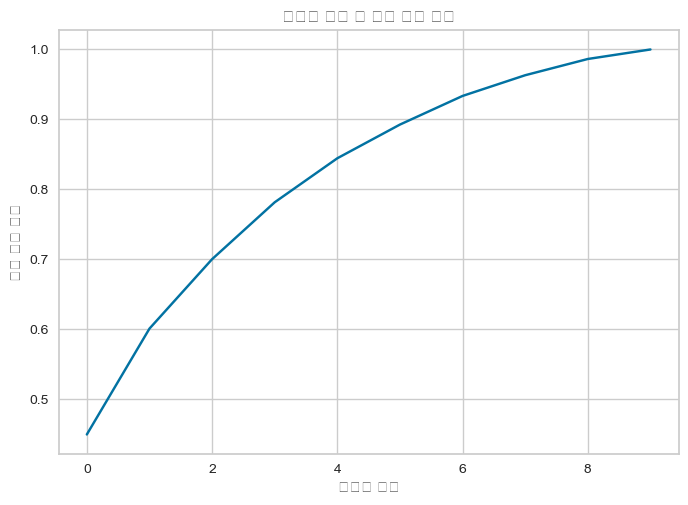

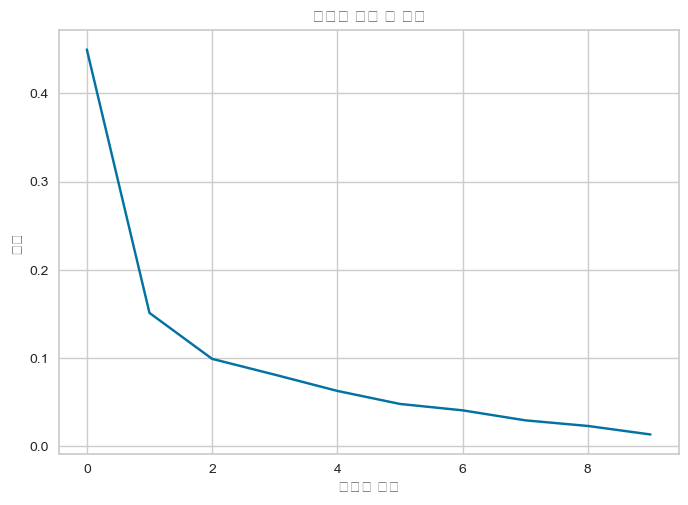

0.7002658234011055


PC1    PC2
0   -1.790 -1.124
1   -1.724 -0.219
2   -1.476  0.118
3   -1.537 -0.419
4   -0.530 -0.405
..     ...    ...
624 -1.441 -1.144
625 -1.281 -1.024
626 -1.885 -0.967
627 -1.742 -0.770
628 -1.631 -1.091

[629 rows x 2 columns]

In [616]:
pc_df = pac_function(df_medic,2)
pc_df

#### K-means

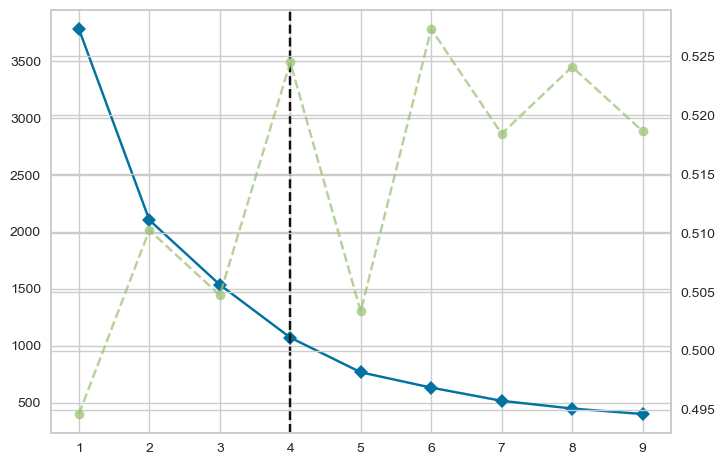

In [617]:
Elbow_function(pc_df)

In [618]:
kmeans_modeling_function(pc_df,4)

0    364
2    119
1    119
3     27
Name: cluster, dtype: int64


PC1    PC2  cluster
0   -1.790 -1.124        0
1   -1.724 -0.219        0
2   -1.476  0.118        0
3   -1.537 -0.419        0
4   -0.530 -0.405        0
..     ...    ...      ...
624 -1.441 -1.144        0
625 -1.281 -1.024        0
626 -1.885 -0.967        0
627 -1.742 -0.770        0
628 -1.631 -1.091        0

[629 rows x 3 columns]

In [621]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [622]:
DBSCAN_modeling_function(pc_df)

 0    627
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.8527344200740131


PC1    PC2  cluster  pca_x  pca_y
0   -1.790 -1.124        0 -2.789  1.395
1   -1.724 -0.219        0 -2.631  0.257
2   -1.476  0.118        0 -2.269 -0.114
3   -1.537 -0.419        0 -2.393  0.557
4   -0.530 -0.405        0 -1.029  0.781
..     ...    ...      ...    ...    ...
624 -1.441 -1.144        0 -2.319  1.505
625 -1.281 -1.024        0 -2.093  1.390
626 -1.885 -0.967        0 -2.906  1.173
627 -1.742 -0.770        0 -2.697  0.955
628 -1.631 -1.091        0 -2.572  1.392

[629 rows x 5 columns]

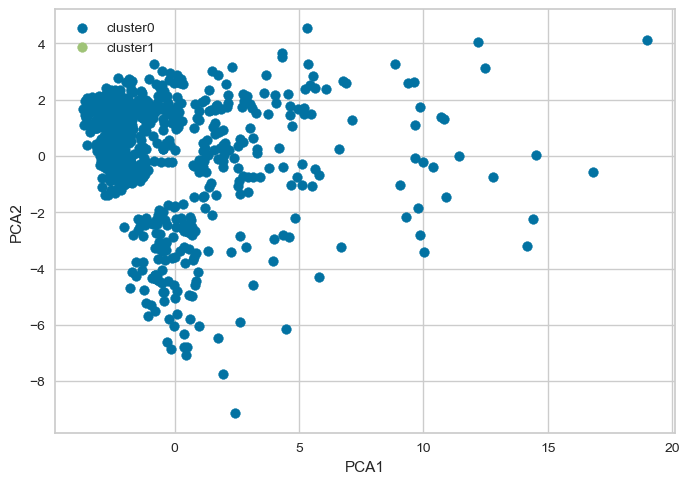

In [623]:
Model_performance_evaluation(pc_df,2)

In [624]:
df_medic = df_concat(df_medic)
df_medic.head()

상권_구분_코드_명       상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권        KT대방빌딩         의약품        0
1       골목상권        KT월곡지사         의약품        0
2       골목상권  NH농협은행 보광동지점         의약품        0
3       골목상권  NH농협은행 상도동지점         의약품        0
4       골목상권        가산동우체국         의약품        0

### 일반교습학원

In [609]:
df_academy = df[df['서비스_업종_코드_명']=='일반교습학원']
df_academy = df_academy.reset_index(drop=True)
df_academy.shape

(564, 13)

#### 주성분분석

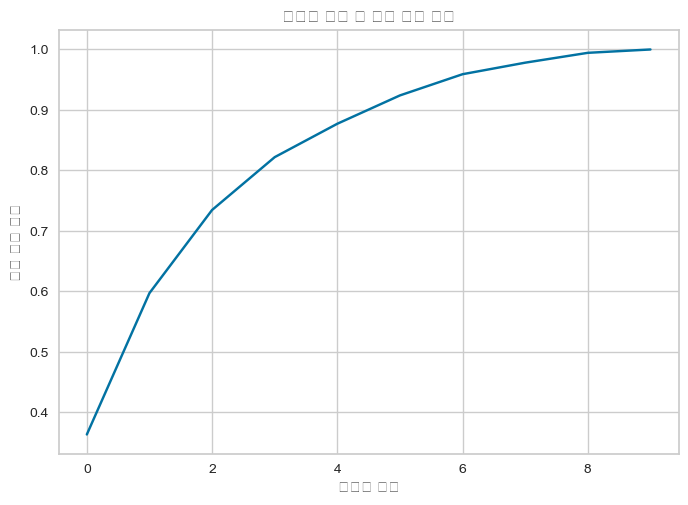

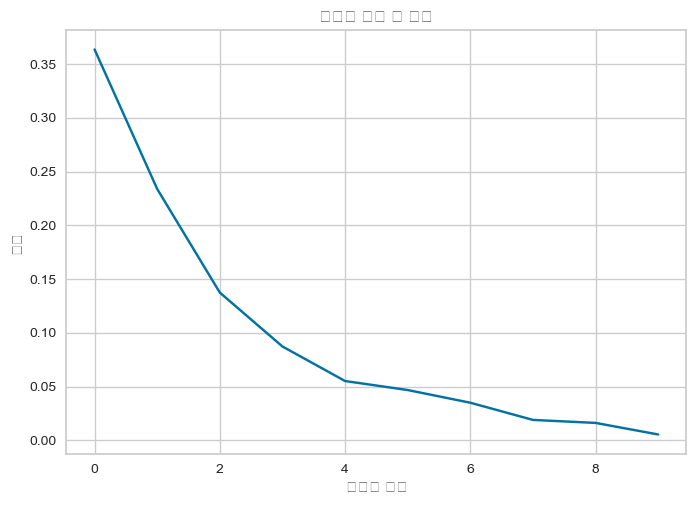

0.734665124574384


PC1    PC2
0   -0.901 -0.482
1   -0.572 -1.349
2   -1.108 -0.993
3   -1.169 -1.042
4   -0.995 -0.437
..     ...    ...
559 -0.807 -0.624
560 -1.109 -1.001
561 -0.744 -0.331
562 -1.021 -0.846
563 -1.136 -0.920

[564 rows x 2 columns]

In [613]:
pc_df = pac_function(df_academy,2)
pc_df

#### K-means

In [625]:
Elbow_function(pc_df)

In [626]:
kmeans_modeling_function(pc_df,4)

2    364
3    119
0    119
1     27
Name: cluster, dtype: int64


PC1    PC2  cluster  pca_x  pca_y
0   -1.790 -1.124        2 -3.310  1.796
1   -1.724 -0.219        2 -3.143  0.350
2   -1.476  0.118        2 -2.704 -0.144
3   -1.537 -0.419        2 -2.841  0.711
4   -0.530 -0.405        2 -1.143  0.889
..     ...    ...      ...    ...    ...
624 -1.441 -1.144        2 -2.723  1.898
625 -1.281 -1.024        2 -2.446  1.737
626 -1.885 -0.967        2 -3.461  1.525
627 -1.742 -0.770        2 -3.208  1.235
628 -1.631 -1.091        2 -3.040  1.775

[629 rows x 5 columns]

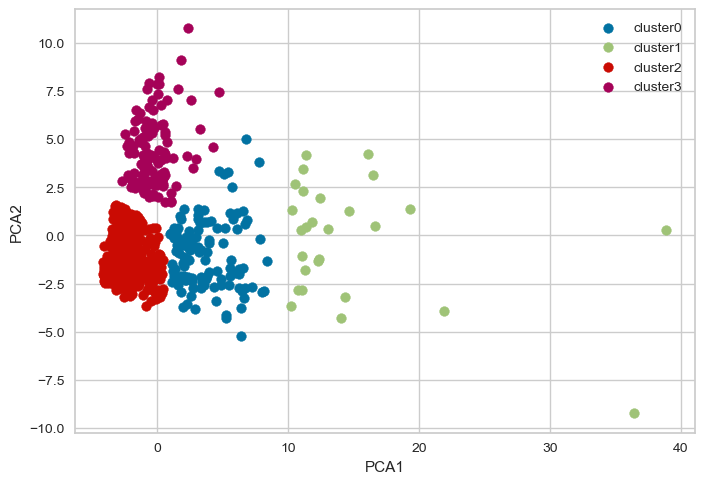

In [627]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [628]:
DBSCAN_modeling_function(pc_df)

 0    627
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.85362732638714


PC1    PC2  cluster  pca_x  pca_y
0   -1.790 -1.124        0 -3.741 -2.158
1   -1.724 -0.219        0 -3.583 -0.478
2   -1.476  0.118        0 -3.088  0.123
3   -1.537 -0.419        0 -3.226 -0.873
4   -0.530 -0.405        0 -1.261 -0.961
..     ...    ...      ...    ...    ...
624 -1.441 -1.144        0 -3.062 -2.235
625 -1.281 -1.024        0 -2.746 -2.029
626 -1.885 -0.967        0 -3.922 -1.855
627 -1.742 -0.770        0 -3.637 -1.503
628 -1.631 -1.091        0 -3.431 -2.115

[629 rows x 5 columns]

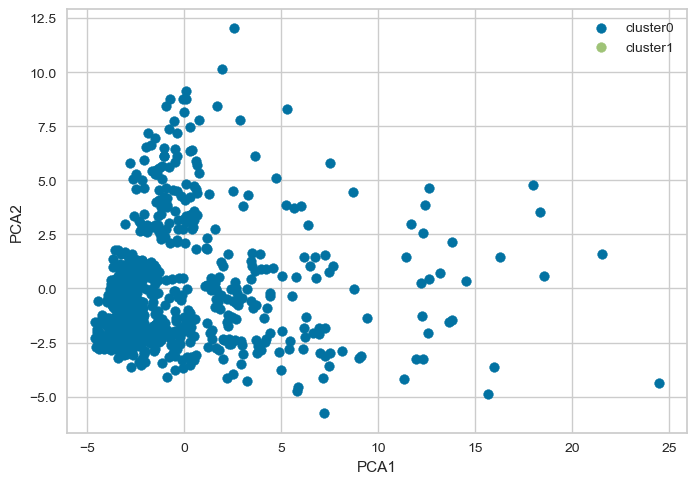

In [629]:
Model_performance_evaluation(pc_df,2)

In [630]:
df_academy = df_concat(df_academy)
df_academy.head()

상권_구분_코드_명            상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권          GS강동자이아파트      일반교습학원        0
1       골목상권        KB국민은행 서강지점      일반교습학원        0
2       골목상권  KT금천빌딩(금천구시설관리공단)      일반교습학원        0
3       골목상권             KT대방빌딩      일반교습학원        0
4       골목상권       NH농협은행 보광동지점      일반교습학원        0

### 치킨전문점

In [631]:
df_chicken = df[df['서비스_업종_코드_명']=='치킨전문점']
df_chicken = df_chicken.reset_index(drop=True)
df_chicken.shape

(529, 13)

#### 주성분분석

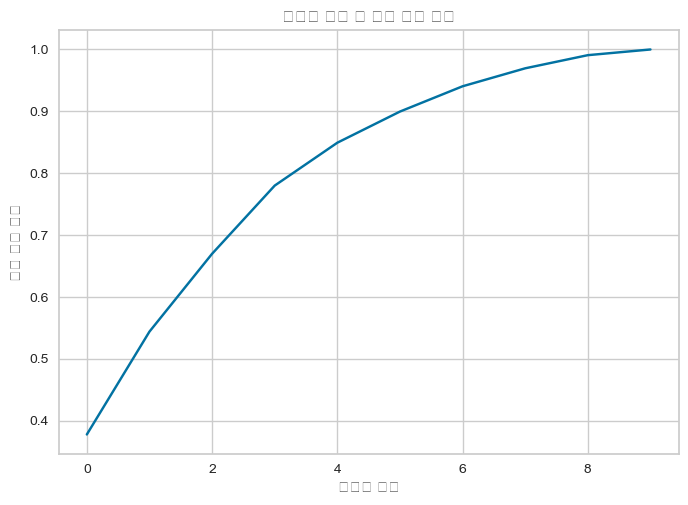

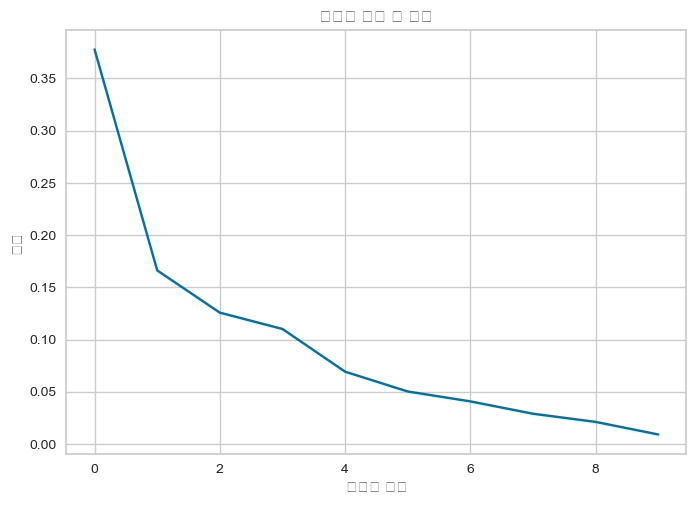

0.849296986652116


PC1    PC2    PC3    PC4
0   -1.554 -0.658  0.189 -0.136
1   -0.423 -0.890 -0.517  1.181
2   -1.429 -0.393  0.303  0.082
3   -1.817 -1.236 -0.030 -0.444
4   -1.446  0.354 -0.545 -0.409
..     ...    ...    ...    ...
524  0.567 -2.272 -1.556  1.627
525 -0.787  0.269 -0.696 -1.126
526  0.175 -2.084 -1.326  1.414
527 -1.797 -0.861 -0.028 -0.259
528 -1.209 -0.175 -0.946 -1.208

[529 rows x 4 columns]

In [633]:
pc_df = pac_function(df_chicken,4)
pc_df

#### K-means

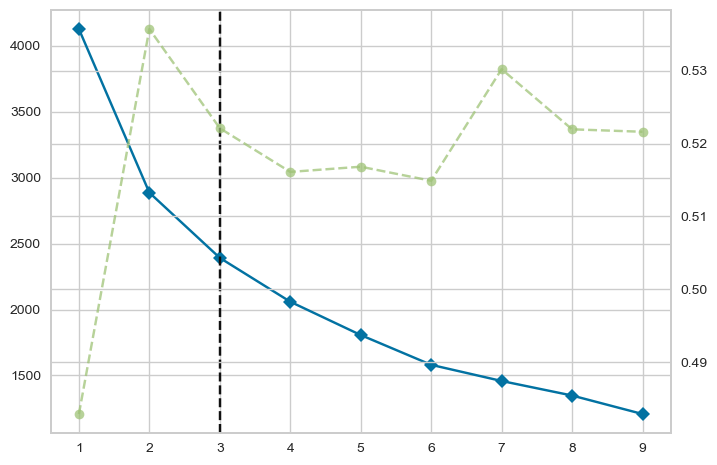

In [634]:
Elbow_function(pc_df)

In [635]:
kmeans_modeling_function(pc_df,3)

0    375
2    114
1     40
Name: cluster, dtype: int64


PC1    PC2    PC3    PC4  cluster
0   -1.554 -0.658  0.189 -0.136        0
1   -0.423 -0.890 -0.517  1.181        0
2   -1.429 -0.393  0.303  0.082        0
3   -1.817 -1.236 -0.030 -0.444        0
4   -1.446  0.354 -0.545 -0.409        0
..     ...    ...    ...    ...      ...
524  0.567 -2.272 -1.556  1.627        0
525 -0.787  0.269 -0.696 -1.126        0
526  0.175 -2.084 -1.326  1.414        0
527 -1.797 -0.861 -0.028 -0.259        0
528 -1.209 -0.175 -0.946 -1.208        0

[529 rows x 5 columns]

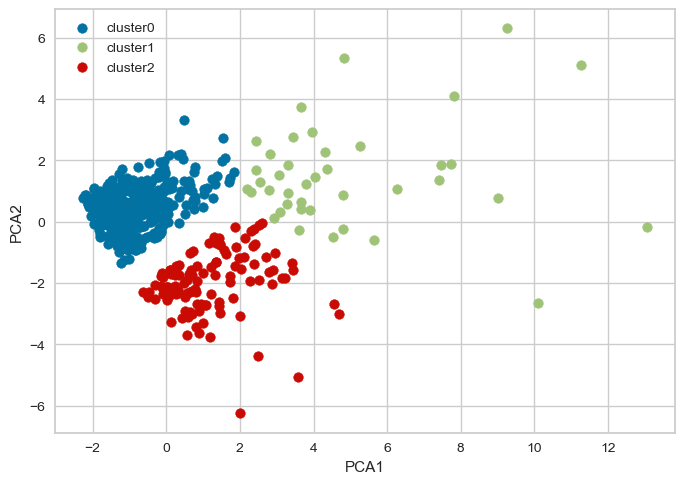

In [636]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [637]:
DBSCAN_modeling_function(pc_df)

 0    527
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.7699737848545378


PC1    PC2    PC3    PC4  cluster  pca_x  pca_y
0   -1.554 -0.658  0.189 -0.136        0 -1.668  0.582
1   -0.423 -0.890 -0.517  1.181        0 -0.567  0.864
2   -1.429 -0.393  0.303  0.082        0 -1.530  0.358
3   -1.817 -1.236 -0.030 -0.444        0 -1.960  1.066
4   -1.446  0.354 -0.545 -0.409        0 -1.496 -0.358
..     ...    ...    ...    ...      ...    ...    ...
524  0.567 -2.272 -1.556  1.627        0  0.323  2.183
525 -0.787  0.269 -0.696 -1.126        0 -0.863 -0.167
526  0.175 -2.084 -1.326  1.414        0 -0.050  1.977
527 -1.797 -0.861 -0.028 -0.259        0 -1.915  0.722
528 -1.209 -0.175 -0.946 -1.208        0 -1.299  0.162

[529 rows x 7 columns]

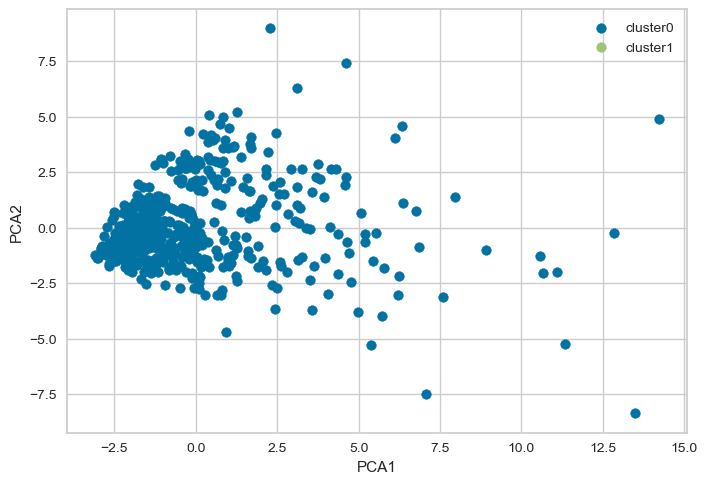

In [638]:
Model_performance_evaluation(pc_df,2)

In [639]:
chicken_cluster = df_concat(df_chicken)
chicken_cluster.head()

상권_구분_코드_명            상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권       4.19민주묘지역 2번       치킨전문점        0
1       골목상권          GS강동자이아파트       치킨전문점        0
2       골목상권       KB국민은행 망원동지점       치킨전문점        0
3       골목상권  KT금천빌딩(금천구시설관리공단)       치킨전문점        0
4       골목상권       NH농협은행 보광동지점       치킨전문점        0

### 노래방

In [640]:
df_sing = df[df['서비스_업종_코드_명']=='노래방']
df_sing = df_sing.reset_index(drop=True)
df_sing.shape

(528, 13)

#### 주성분분석

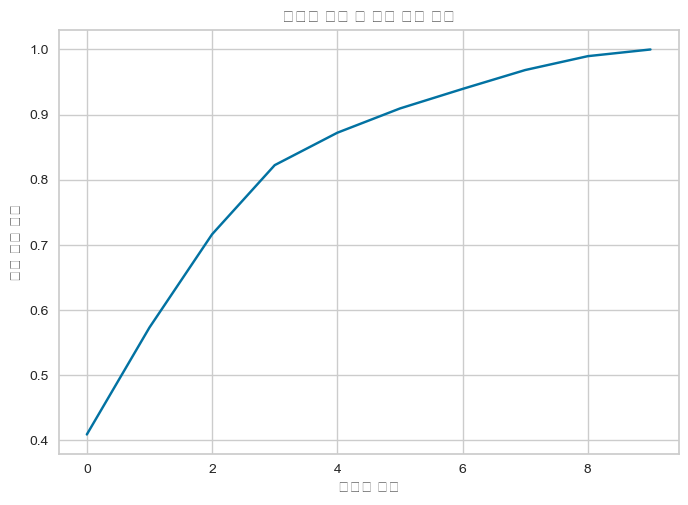

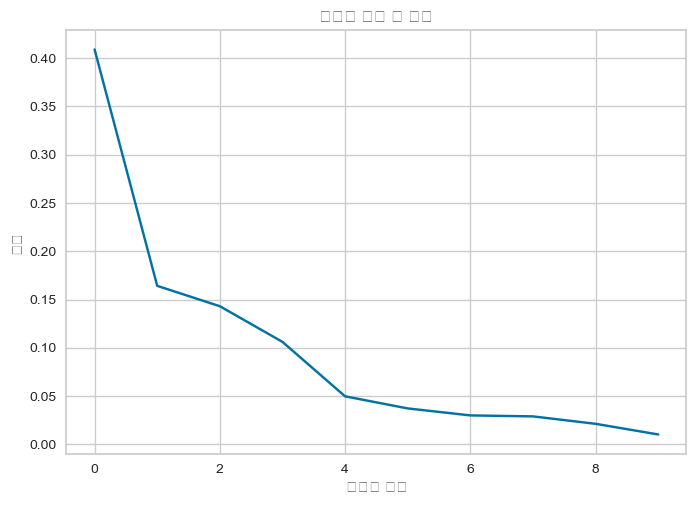

0.8722078468762166


PC1    PC2   PC3    PC4
0   -1.112  0.033 0.320 -0.248
1   -1.695  0.331 1.314  0.024
2   -1.494  0.130 0.495 -0.140
3   -0.506 -0.124 0.630 -0.183
4   -0.729  1.949 0.551  0.903
..     ...    ...   ...    ...
523  0.847  2.201 1.000 -0.987
524 -0.549  0.083 0.831 -0.626
525 -0.413  1.301 0.913 -0.548
526 -1.701  0.321 0.980 -0.175
527 -1.535  0.254 1.219 -0.001

[528 rows x 4 columns]

In [642]:
pc_df = pac_function(df_sing,4)
pc_df

#### K-means

In [643]:
Elbow_function(pc_df)

In [644]:
kmeans_modeling_function(pc_df,3)

0    351
2    133
1     44
Name: cluster, dtype: int64


PC1    PC2   PC3    PC4  cluster
0   -1.112  0.033 0.320 -0.248        0
1   -1.695  0.331 1.314  0.024        0
2   -1.494  0.130 0.495 -0.140        0
3   -0.506 -0.124 0.630 -0.183        0
4   -0.729  1.949 0.551  0.903        0
..     ...    ...   ...    ...      ...
523  0.847  2.201 1.000 -0.987        0
524 -0.549  0.083 0.831 -0.626        0
525 -0.413  1.301 0.913 -0.548        0
526 -1.701  0.321 0.980 -0.175        0
527 -1.535  0.254 1.219 -0.001        0

[528 rows x 5 columns]

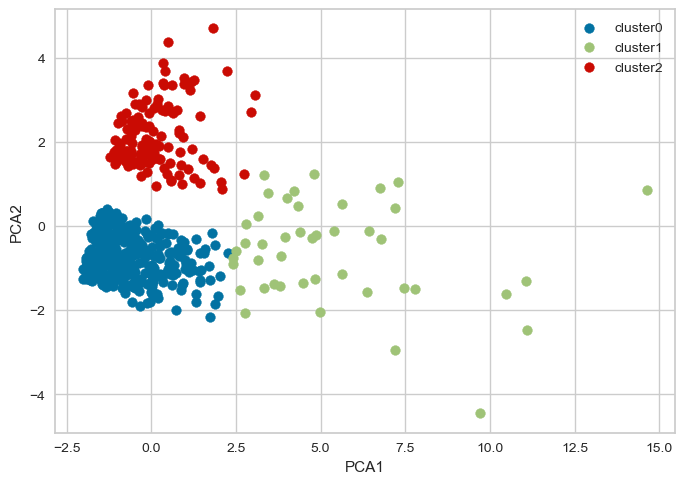

In [645]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [646]:
DBSCAN_modeling_function(pc_df)

 0    527
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.7910721389553453


PC1    PC2   PC3    PC4  cluster  pca_x  pca_y
0   -1.112  0.033 0.320 -0.248        0 -1.183 -0.445
1   -1.695  0.331 1.314  0.024        0 -1.798 -1.264
2   -1.494  0.130 0.495 -0.140        0 -1.569 -0.584
3   -0.506 -0.124 0.630 -0.183        0 -0.590 -0.670
4   -0.729  1.949 0.551  0.903        0 -0.836 -1.479
..     ...    ...   ...    ...      ...    ...    ...
523  0.847  2.201 1.000 -0.987        0  0.715 -1.986
524 -0.549  0.083 0.831 -0.626        0 -0.640 -0.883
525 -0.413  1.301 0.913 -0.548        0 -0.523 -1.456
526 -1.701  0.321 0.980 -0.175        0 -1.793 -1.003
527 -1.535  0.254 1.219 -0.001        0 -1.635 -1.176

[528 rows x 7 columns]

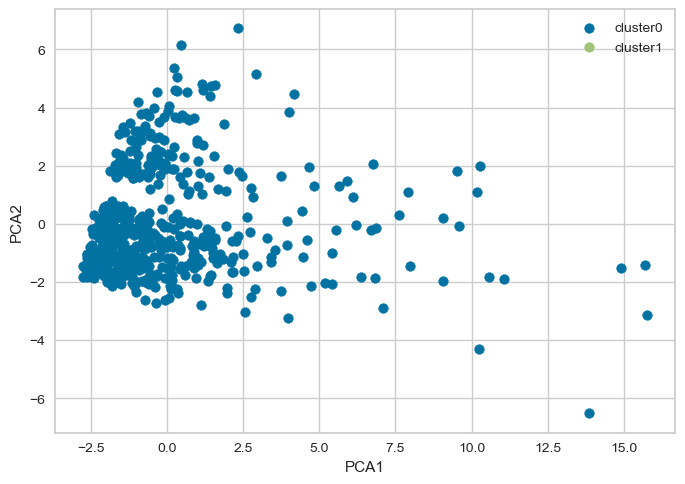

In [647]:
Model_performance_evaluation(pc_df,2)

In [648]:
sing_cluster = df_concat(df_sing)
sing_cluster.head()

상권_구분_코드_명            상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권       KB국민은행 망원동지점         노래방        0
1       골목상권  KT금천빌딩(금천구시설관리공단)         노래방        0
2       골목상권       NH농협은행 상도동지점         노래방        0
3       골목상권             가산동우체국         노래방        0
4       골목상권            가산동주민센터         노래방        0

### 일반의원

In [649]:
df_hospital = df[df['서비스_업종_코드_명']=='일반의원']
df_hospital = df_hospital.reset_index(drop=True)
df_hospital.shape

(489, 13)

#### 주성분분석

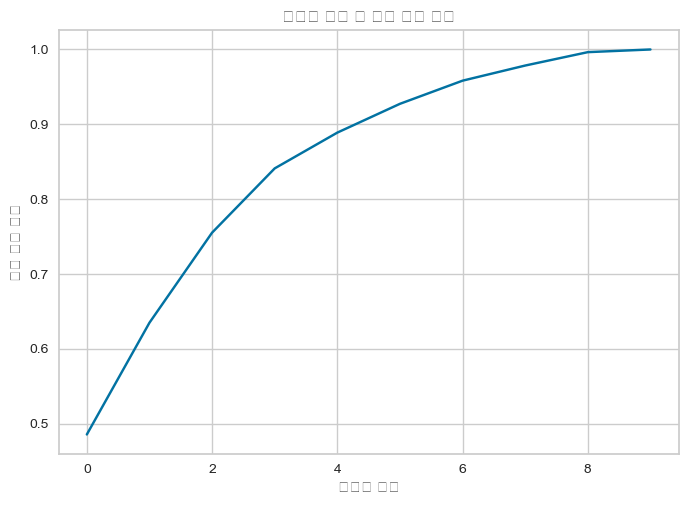

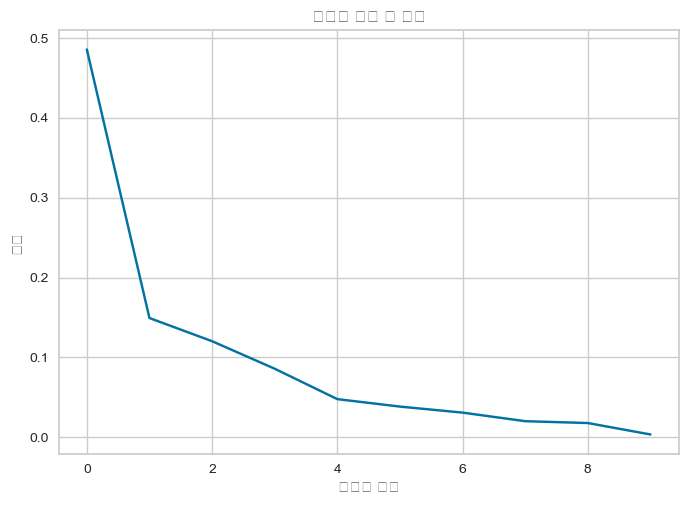

0.8889211114262089


PC1    PC2    PC3    PC4
0   -1.229 -0.232 -0.343  0.313
1   -1.304 -0.078 -0.614  0.362
2   -1.088 -0.350  0.216  0.216
3   -1.531 -1.164 -0.018  0.572
4   -1.370 -0.396 -0.353  0.520
..     ...    ...    ...    ...
484 -1.749 -1.298 -0.259  0.554
485 -0.432 -0.783 -0.277 -0.415
486 -1.233 -1.233  0.026 -0.175
487 -1.014 -1.212 -0.126 -0.572
488 -1.037 -1.103 -0.561  0.752

[489 rows x 4 columns]

In [651]:
pc_df = pac_function(df_hospital,4)
pc_df

#### K-means

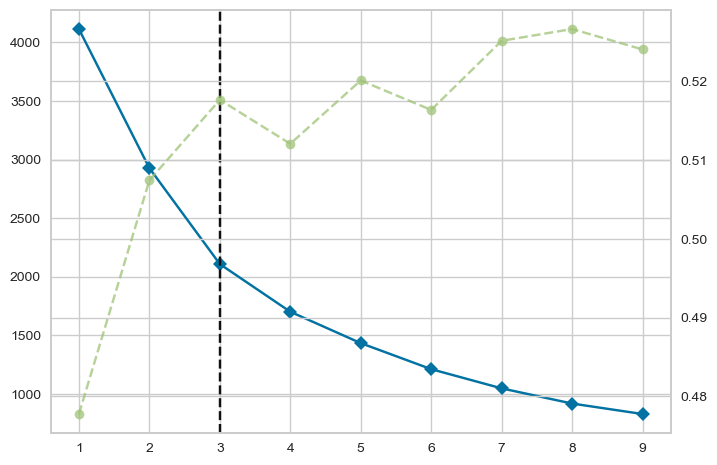

In [652]:
Elbow_function(pc_df)

In [653]:
kmeans_modeling_function(pc_df,3)

0    403
1     83
2      3
Name: cluster, dtype: int64


PC1    PC2    PC3    PC4  cluster
0   -1.229 -0.232 -0.343  0.313        0
1   -1.304 -0.078 -0.614  0.362        0
2   -1.088 -0.350  0.216  0.216        0
3   -1.531 -1.164 -0.018  0.572        0
4   -1.370 -0.396 -0.353  0.520        0
..     ...    ...    ...    ...      ...
484 -1.749 -1.298 -0.259  0.554        0
485 -0.432 -0.783 -0.277 -0.415        0
486 -1.233 -1.233  0.026 -0.175        0
487 -1.014 -1.212 -0.126 -0.572        0
488 -1.037 -1.103 -0.561  0.752        0

[489 rows x 5 columns]

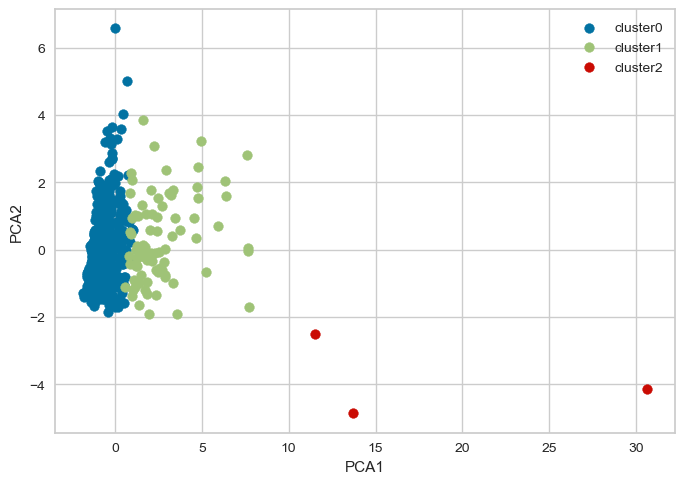

In [654]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [655]:
DBSCAN_modeling_function(pc_df)

 0    488
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.9116163143703421


PC1    PC2    PC3    PC4  cluster  pca_x  pca_y
0   -1.229 -0.232 -0.343  0.313        0 -1.244 -0.232
1   -1.304 -0.078 -0.614  0.362        0 -1.320 -0.078
2   -1.088 -0.350  0.216  0.216        0 -1.103 -0.350
3   -1.531 -1.164 -0.018  0.572        0 -1.543 -1.164
4   -1.370 -0.396 -0.353  0.520        0 -1.385 -0.397
..     ...    ...    ...    ...      ...    ...    ...
484 -1.749 -1.298 -0.259  0.554        0 -1.760 -1.298
485 -0.432 -0.783 -0.277 -0.415        0 -0.452 -0.783
486 -1.233 -1.233  0.026 -0.175        0 -1.246 -1.233
487 -1.014 -1.212 -0.126 -0.572        0 -1.029 -1.212
488 -1.037 -1.103 -0.561  0.752        0 -1.056 -1.104

[489 rows x 7 columns]

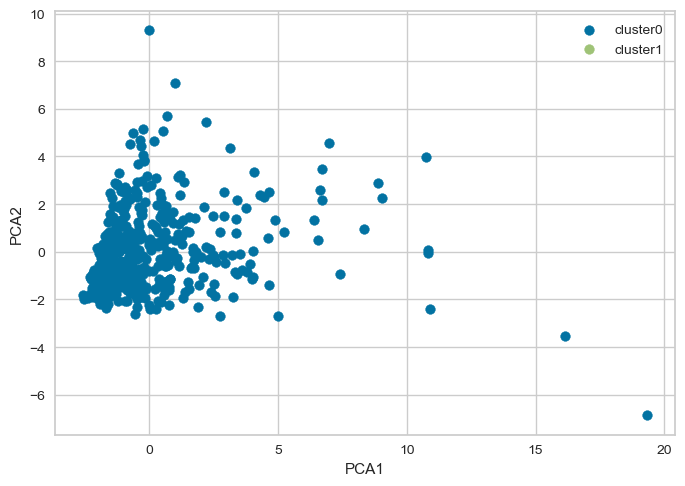

In [656]:
Model_performance_evaluation(pc_df,2)

In [657]:
hospital_cluster = df_concat(df_hospital)
hospital_cluster.head()

상권_구분_코드_명        상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권   KB국민은행 망원동지점        일반의원        0
1       골목상권   NH농협은행 보광동지점        일반의원        0
2       골목상권  가산초등학교(세일중학교)        일반의원        0
3       골목상권        가양역 10번        일반의원        0
4       골목상권        가오리역 1번        일반의원        0

### 중식음식점

In [658]:
df_chinese_food = df[df['서비스_업종_코드_명']=='중식음식점']
df_chinese_food = df_chinese_food.reset_index(drop=True)
df_chinese_food.shape

(447, 13)

#### 주성분분석

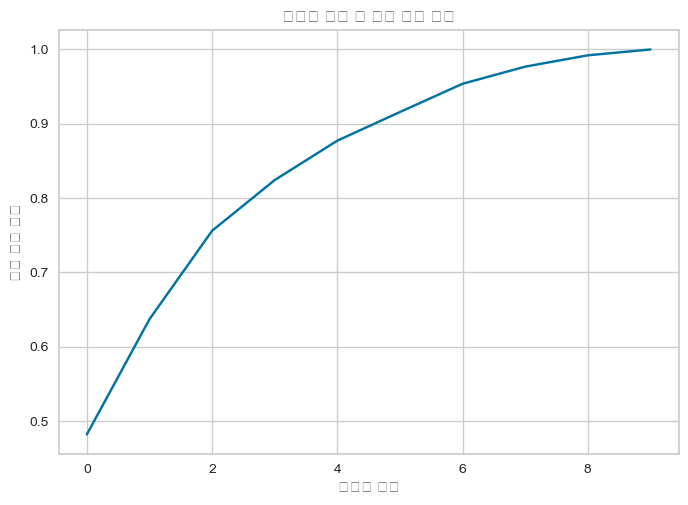

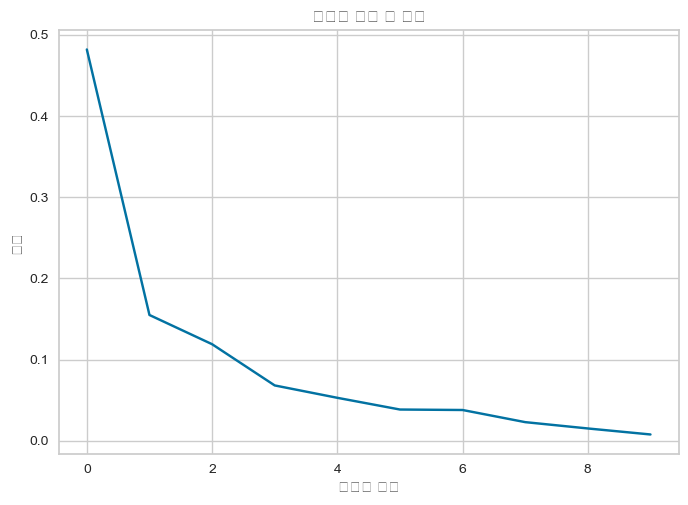

0.8243079180957812


PC1    PC2    PC3
0   -1.601 -0.024  0.177
1   -1.384 -1.243 -0.005
2   -1.302 -1.144  0.717
3   -0.846 -0.563  0.571
4   -0.184  3.320  0.296
..     ...    ...    ...
442 -1.473  0.454 -0.007
443 -0.588 -1.151  0.927
444 -0.886 -0.675  0.467
445  1.512 -1.477  2.601
446 -1.540 -1.028  0.083

[447 rows x 3 columns]

In [661]:
pc_df = pac_function(df_chinese_food,3)
pc_df

#### K-means

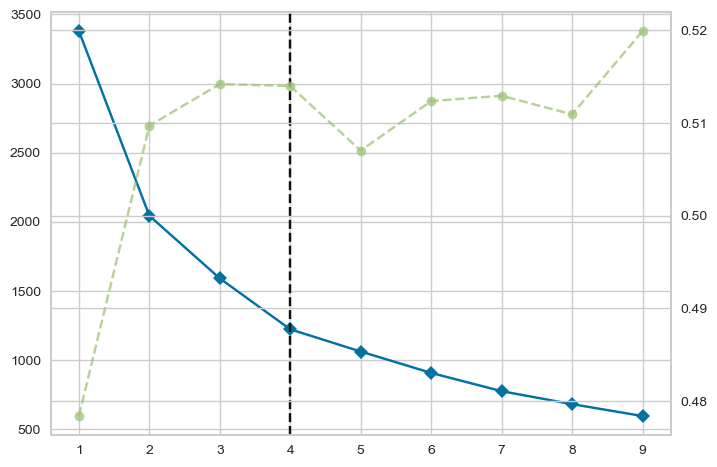

In [662]:
Elbow_function(pc_df)

In [663]:
kmeans_modeling_function(pc_df,4)

0    270
2     83
3     82
1     12
Name: cluster, dtype: int64


PC1    PC2    PC3  cluster
0   -1.601 -0.024  0.177        0
1   -1.384 -1.243 -0.005        0
2   -1.302 -1.144  0.717        0
3   -0.846 -0.563  0.571        0
4   -0.184  3.320  0.296        2
..     ...    ...    ...      ...
442 -1.473  0.454 -0.007        0
443 -0.588 -1.151  0.927        0
444 -0.886 -0.675  0.467        0
445  1.512 -1.477  2.601        3
446 -1.540 -1.028  0.083        0

[447 rows x 4 columns]

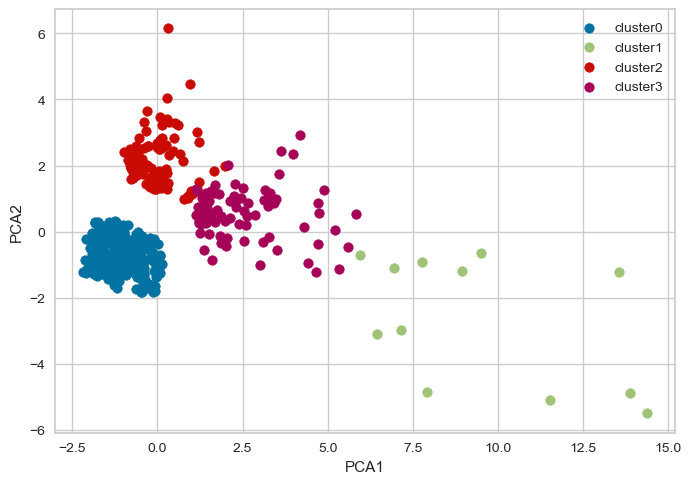

In [664]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [665]:
DBSCAN_modeling_function(pc_df)

 0    446
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.8062933875847532


PC1    PC2    PC3  cluster  pca_x  pca_y
0   -1.601 -0.024  0.177        0 -1.818 -0.166
1   -1.384 -1.243 -0.005        0 -1.679 -1.206
2   -1.302 -1.144  0.717        0 -1.595 -1.142
3   -0.846 -0.563  0.571        0 -1.132 -0.774
4   -0.184  3.320  0.296        0  0.339  3.304
..     ...    ...    ...      ...    ...    ...
442 -1.473  0.454 -0.007        0 -1.670  0.192
443 -0.588 -1.151  0.927        0 -0.919 -1.309
444 -0.886 -0.675  0.467        0 -1.176 -0.857
445  1.512 -1.477  2.601        0  2.002 -0.432
446 -1.540 -1.028  0.083        0 -1.815 -0.996

[447 rows x 6 columns]

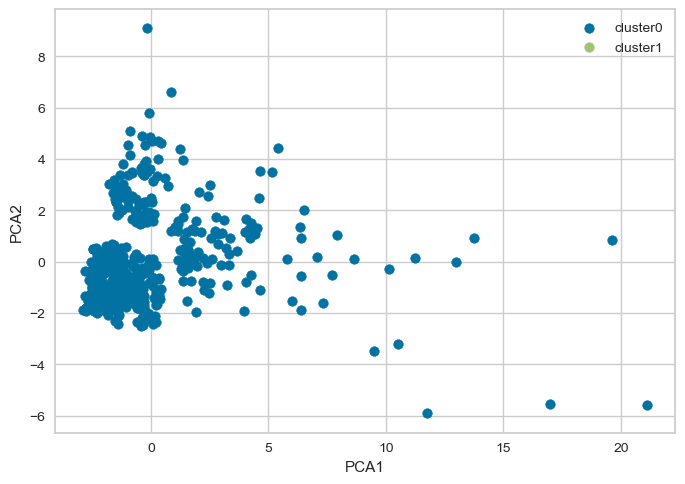

In [666]:
Model_performance_evaluation(pc_df,2)

In [667]:
chinese_food_cluster = df_concat(df_chinese_food)
chinese_food_cluster.head()

상권_구분_코드_명          상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권           KT구로지사       중식음식점        0
1       골목상권          가산동주민센터       중식음식점        0
2       골목상권  가산디지털단지역 1번 출입구       중식음식점        0
3       골목상권    가산초등학교(세일중학교)       중식음식점        0
4       골목상권   강동역 4번(강풀만화거리)       중식음식점        0

### 패스트푸드점

In [668]:
df_fastfood = df[df['서비스_업종_코드_명']=='패스트푸드점']
df_fastfood = df_fastfood.reset_index(drop=True)
df_fastfood.shape

(414, 13)

#### 주성분분석

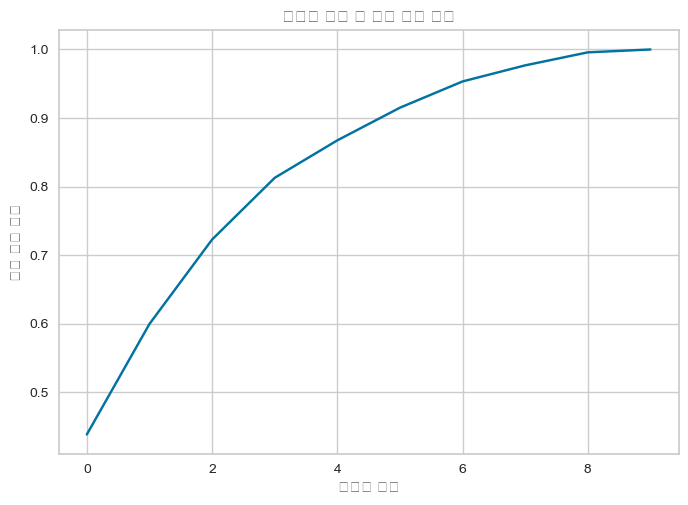

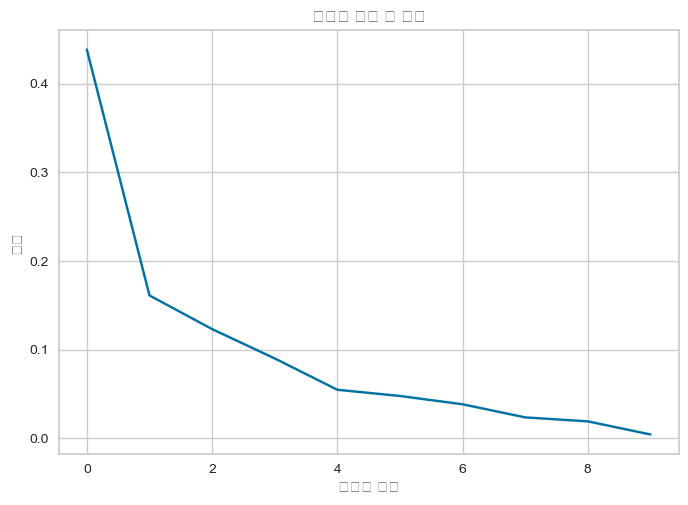

0.8675056415364253


PC1    PC2    PC3    PC4
0   -1.616 -0.615  0.066 -0.075
1   -0.970 -1.344  0.974  0.405
2   -1.632 -0.892  0.191 -0.377
3   -1.638  0.690 -0.523  0.464
4   -1.129 -1.377  0.244 -0.112
..     ...    ...    ...    ...
409 -1.376 -0.982  1.533  0.305
410 -0.982 -0.552  0.730 -0.453
411 -1.261 -1.683  0.313  0.319
412 -1.618 -0.925  0.266 -0.050
413 -1.424 -0.938  0.299  0.122

[414 rows x 4 columns]

In [671]:
pc_df = pac_function(df_fastfood,4)
pc_df

#### K-means

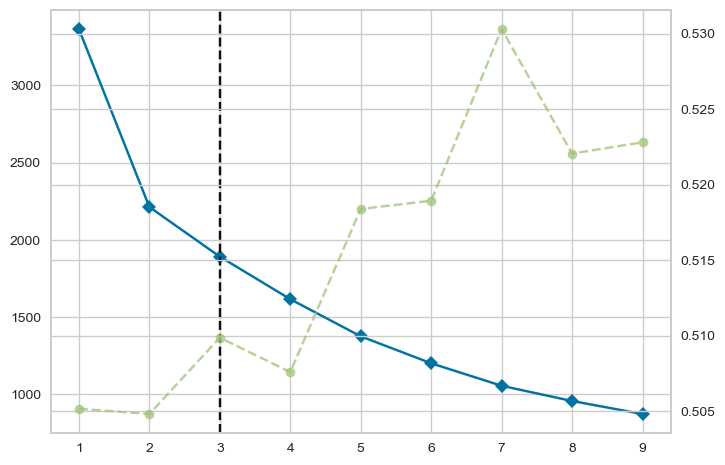

In [672]:
Elbow_function(pc_df)

In [673]:
kmeans_modeling_function(pc_df,3)

0    253
2    109
1     52
Name: cluster, dtype: int64


PC1    PC2    PC3    PC4  cluster
0   -1.616 -0.615  0.066 -0.075        0
1   -0.970 -1.344  0.974  0.405        0
2   -1.632 -0.892  0.191 -0.377        0
3   -1.638  0.690 -0.523  0.464        2
4   -1.129 -1.377  0.244 -0.112        0
..     ...    ...    ...    ...      ...
409 -1.376 -0.982  1.533  0.305        0
410 -0.982 -0.552  0.730 -0.453        0
411 -1.261 -1.683  0.313  0.319        0
412 -1.618 -0.925  0.266 -0.050        0
413 -1.424 -0.938  0.299  0.122        0

[414 rows x 5 columns]

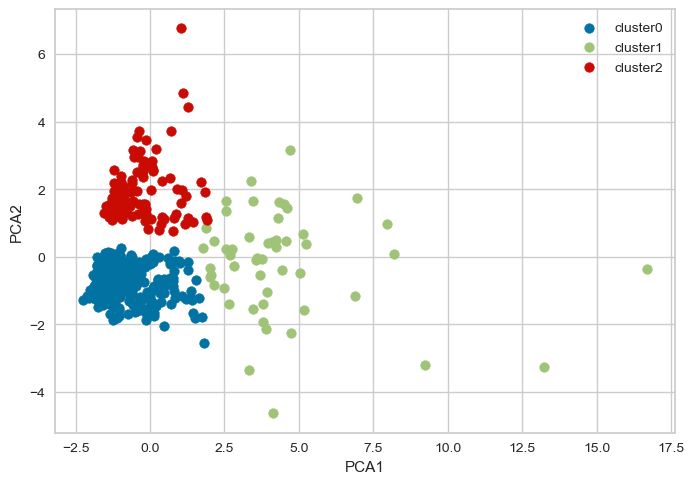

In [674]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [675]:
DBSCAN_modeling_function(pc_df)

 0    412
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.7944399407504478


PC1    PC2    PC3    PC4  cluster  pca_x  pca_y
0   -1.616 -0.615  0.066 -0.075        0 -1.680 -0.755
1   -0.970 -1.344  0.974  0.405        0 -1.056 -1.563
2   -1.632 -0.892  0.191 -0.377        0 -1.703 -1.039
3   -1.638  0.690 -0.523  0.464        0 -1.493  1.494
4   -1.129 -1.377  0.244 -0.112        0 -1.211 -1.466
..     ...    ...    ...    ...      ...    ...    ...
409 -1.376 -0.982  1.533  0.305        0 -1.460 -1.366
410 -0.982 -0.552  0.730 -0.453        0 -1.054 -0.919
411 -1.261 -1.683  0.313  0.319        0 -1.348 -1.692
412 -1.618 -0.925  0.266 -0.050        0 -1.689 -1.056
413 -1.424 -0.938  0.299  0.122        0 -1.496 -1.072

[414 rows x 7 columns]

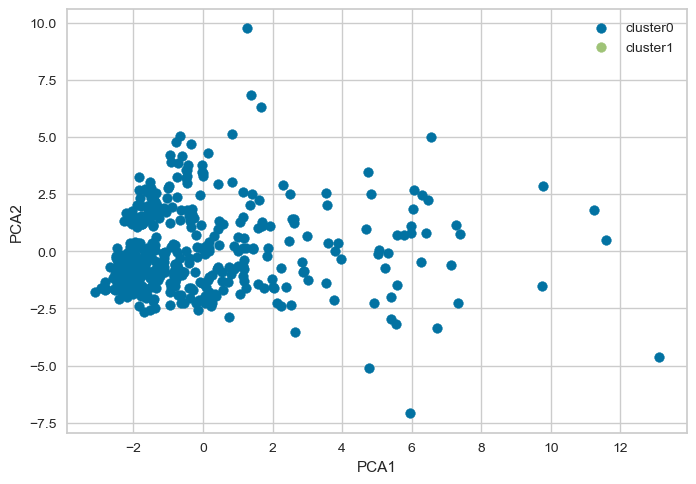

In [676]:
Model_performance_evaluation(pc_df,2)

In [677]:
fastfood_cluster = df_concat(df_fastfood)
fastfood_cluster.head()

상권_구분_코드_명            상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권       4.19민주묘지역 2번      패스트푸드점        0
1       골목상권  KT금천빌딩(금천구시설관리공단)      패스트푸드점        0
2       골목상권             가인초등학교      패스트푸드점        0
3       골목상권         강동구립 천호도서관      패스트푸드점        0
4       골목상권            강일동주민센터      패스트푸드점        0

### 제과점

In [694]:
df_bread = df[df['서비스_업종_코드_명']=='제과점']
df_bread = df_bread.reset_index(drop=True)
df_bread.shape

(393, 13)

#### 주성분분석

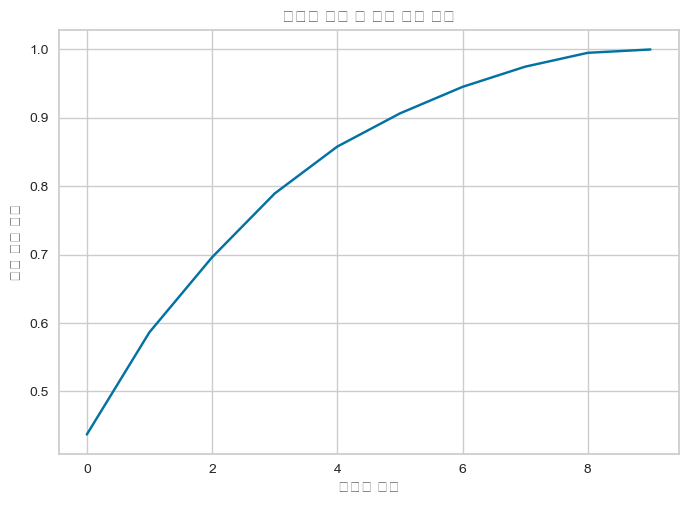

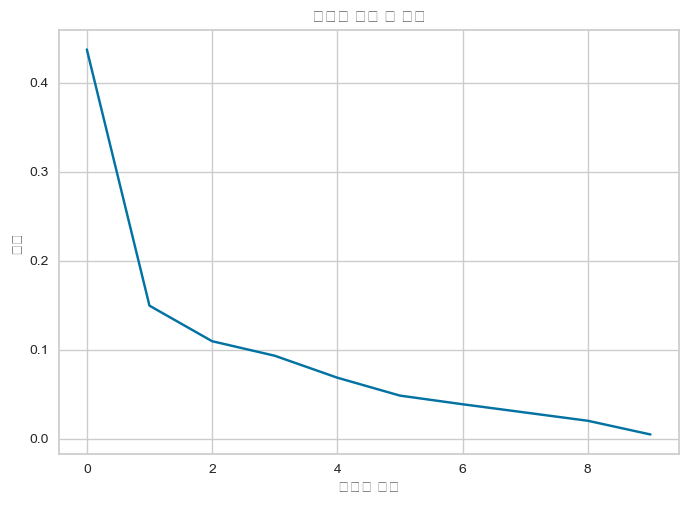

0.7894576372048356


PC1    PC2    PC3
0   -1.050  2.499 -0.898
1   -0.363  3.773  0.052
2   -1.170 -1.410 -0.245
3    0.280 -1.561 -1.611
4   -0.658  0.218  1.344
..     ...    ...    ...
388 -1.565 -0.553 -0.143
389 -1.561 -0.454 -0.044
390 -1.522 -0.876  1.193
391 -1.600 -0.999  1.215
392 -1.129 -1.585 -0.559

[393 rows x 3 columns]

In [695]:
pc_df = pac_function(df_bread,3)
pc_df

#### K-means

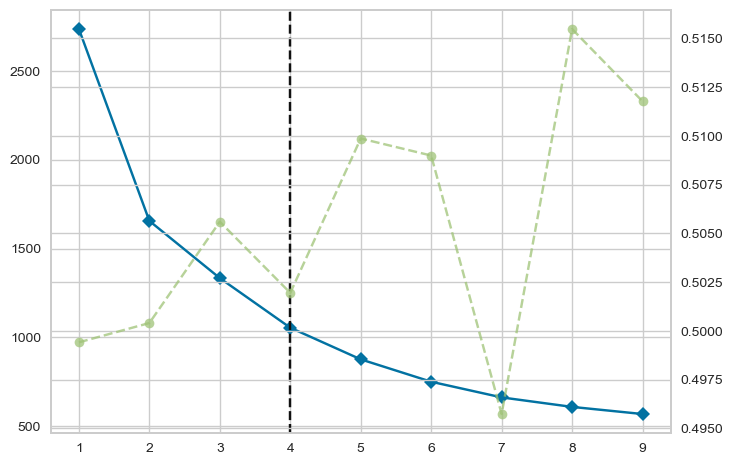

In [696]:
Elbow_function(pc_df)

In [697]:
kmeans_modeling_function(pc_df,4)

3    243
1     71
0     71
2      8
Name: cluster, dtype: int64


PC1    PC2    PC3  cluster
0   -1.050  2.499 -0.898        1
1   -0.363  3.773  0.052        1
2   -1.170 -1.410 -0.245        3
3    0.280 -1.561 -1.611        3
4   -0.658  0.218  1.344        3
..     ...    ...    ...      ...
388 -1.565 -0.553 -0.143        3
389 -1.561 -0.454 -0.044        3
390 -1.522 -0.876  1.193        3
391 -1.600 -0.999  1.215        3
392 -1.129 -1.585 -0.559        3

[393 rows x 4 columns]

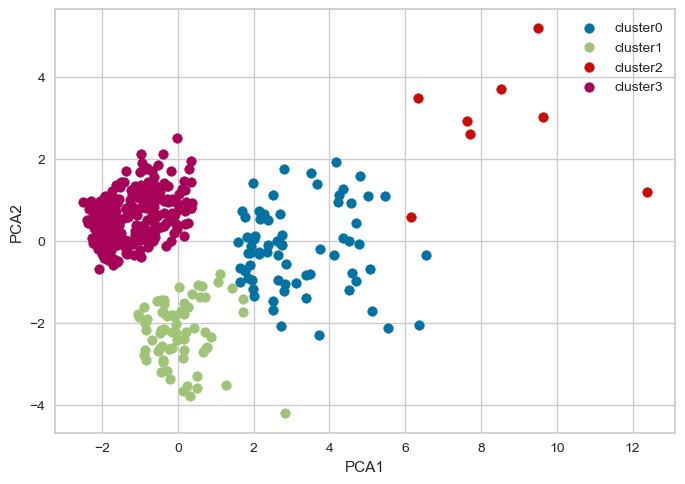

In [698]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [699]:
DBSCAN_modeling_function(pc_df)

 0    392
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.7348921467383698


PC1    PC2    PC3  cluster  pca_x  pca_y
0   -1.050  2.499 -0.898        0 -0.387 -2.942
1   -0.363  3.773  0.052        0  0.316 -3.777
2   -1.170 -1.410 -0.245        0 -1.519  1.308
3    0.280 -1.561 -1.611        0 -0.177  1.705
4   -0.658  0.218  1.344        0 -0.962  0.175
..     ...    ...    ...      ...    ...    ...
388 -1.565 -0.553 -0.143        0 -1.829  0.492
389 -1.561 -0.454 -0.044        0 -1.821  0.416
390 -1.522 -0.876  1.193        0 -1.824  0.871
391 -1.600 -0.999  1.215        0 -1.904  0.957
392 -1.129 -1.585 -0.559        0 -1.488  1.445

[393 rows x 6 columns]

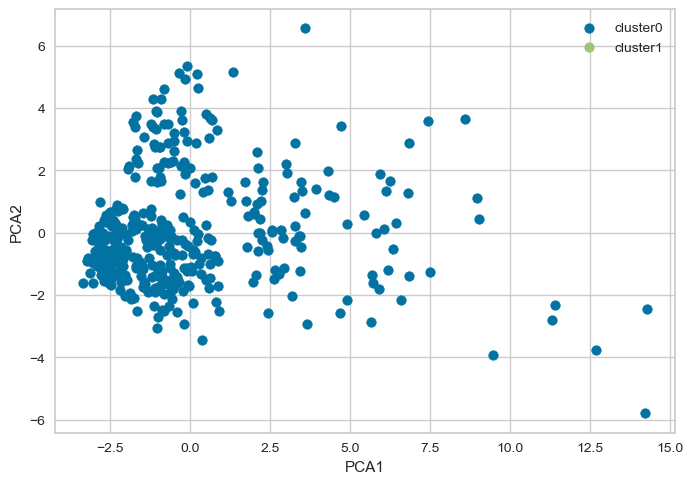

In [700]:
Model_performance_evaluation(pc_df,2)

In [701]:
bread_cluster = df_concat(df_bread)
bread_cluster.head()

상권_구분_코드_명         상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권       강동구립성내도서관         제과점        0
1       골목상권  강동역 4번(강풀만화거리)         제과점        0
2       골목상권         강일동주민센터         제과점        0
3       골목상권             개봉역         제과점        0
4       골목상권          경리단길남측         제과점        0

### 치과의원

In [702]:
df_dental = df[df['서비스_업종_코드_명']=='치과의원']
df_dental = df_dental.reset_index(drop=True)
df_dental.shape

(373, 13)

#### 주성분분석

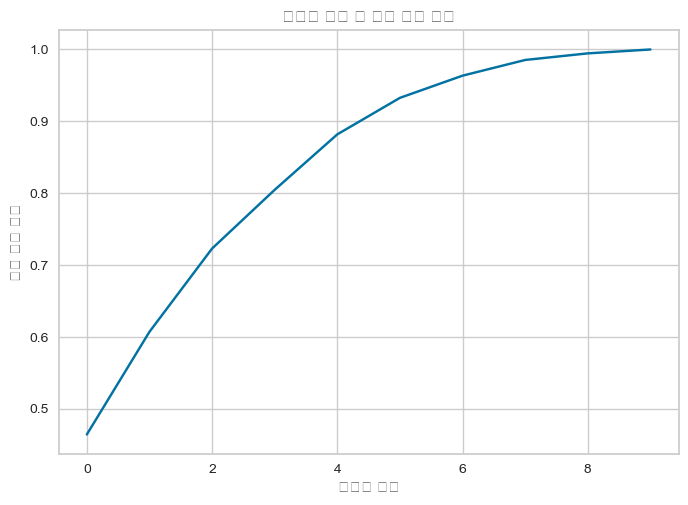

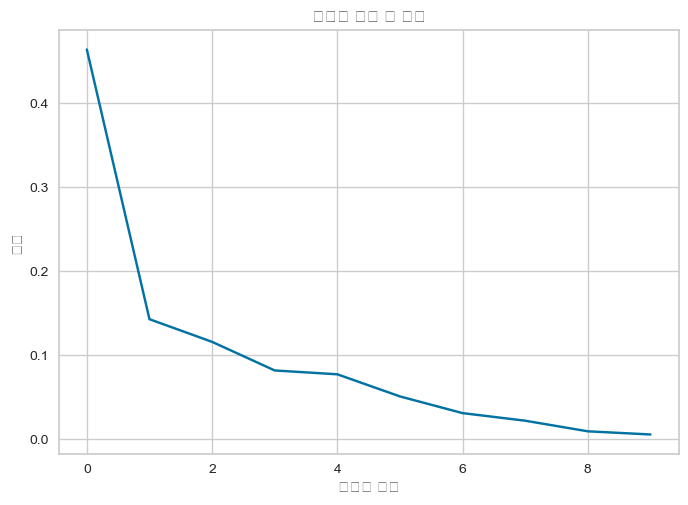

0.8047889520362335


PC1    PC2    PC3
0   -1.444 -0.090 -0.273
1   -1.275 -1.281 -0.290
2   -1.659 -0.807  0.035
3   -1.294 -1.136  0.050
4   -1.208 -0.340  0.147
..     ...    ...    ...
368 -1.521 -1.204 -0.034
369 -2.107 -1.101 -0.054
370 -1.386  0.759 -0.502
371 -1.036 -0.512 -0.205
372 -1.872 -0.683 -0.174

[373 rows x 3 columns]

In [705]:
pc_df = pac_function(df_dental,3)
pc_df

#### K-means

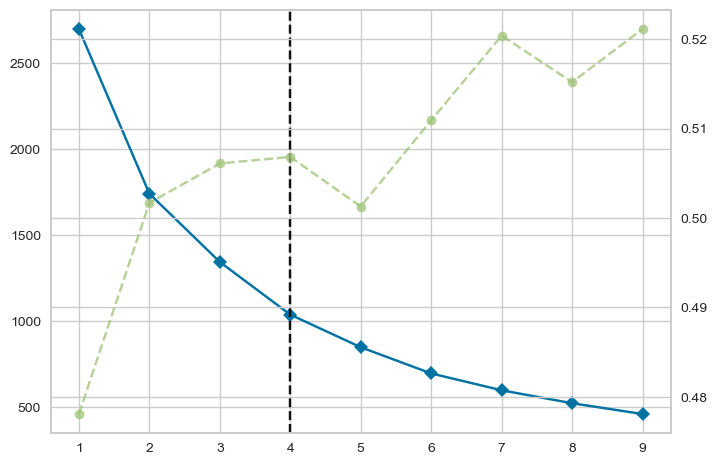

In [706]:
Elbow_function(pc_df)

In [707]:
kmeans_modeling_function(pc_df,4)

0    228
3     76
1     63
2      6
Name: cluster, dtype: int64


PC1    PC2    PC3  cluster
0   -1.444 -0.090 -0.273        0
1   -1.275 -1.281 -0.290        0
2   -1.659 -0.807  0.035        0
3   -1.294 -1.136  0.050        0
4   -1.208 -0.340  0.147        0
..     ...    ...    ...      ...
368 -1.521 -1.204 -0.034        0
369 -2.107 -1.101 -0.054        0
370 -1.386  0.759 -0.502        3
371 -1.036 -0.512 -0.205        0
372 -1.872 -0.683 -0.174        0

[373 rows x 4 columns]

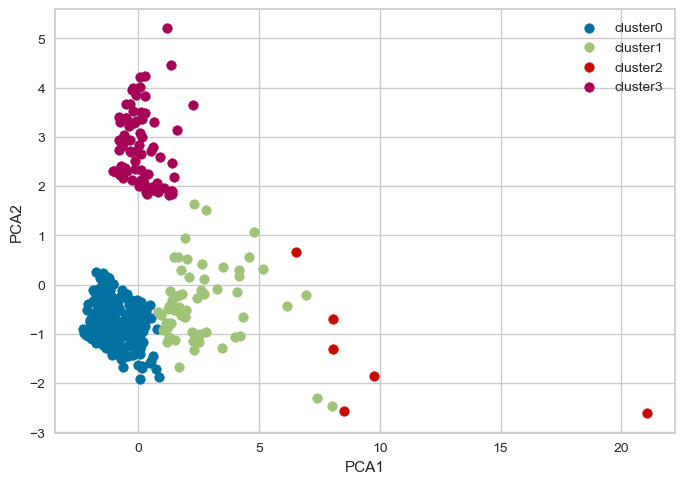

In [708]:
Model_performance_evaluation(pc_df,4)

#### DBSCAN

In [710]:
DBSCAN_modeling_function(pc_df)

 0    372
-1      1
Name: cluster, dtype: int64
모델 성능 : 0.8497187841379322


PC1    PC2    PC3  cluster  pca_x  pca_y
0   -1.444 -0.090 -0.273        0 -1.564 -0.353
1   -1.275 -1.281 -0.290        0 -1.461 -1.230
2   -1.659 -0.807  0.035        0 -1.816 -0.862
3   -1.294 -1.136  0.050        0 -1.476 -1.157
4   -1.208 -0.340  0.147        0 -1.350 -0.611
..     ...    ...    ...      ...    ...    ...
368 -1.521 -1.204 -0.034        0 -1.702 -1.162
369 -2.107 -1.101 -0.054        0 -2.272 -0.992
370 -1.386  0.759 -0.502        0 -0.933  2.287
371 -1.036 -0.512 -0.205        0 -1.186 -0.727
372 -1.872 -0.683 -0.174        0 -2.017 -0.718

[373 rows x 6 columns]

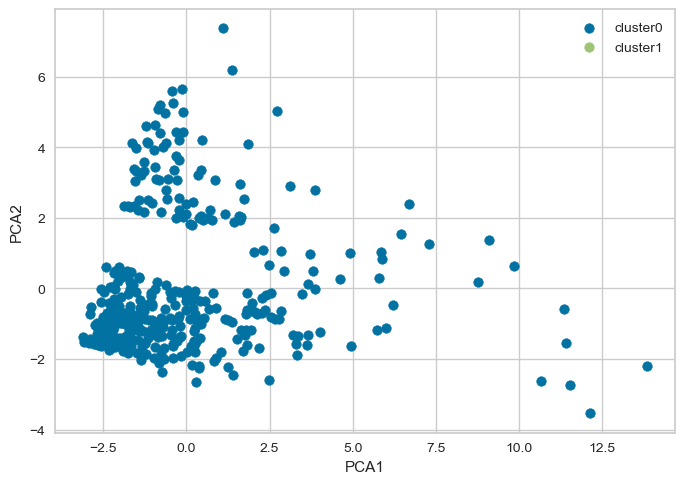

In [711]:
Model_performance_evaluation(pc_df,2)

In [712]:
dental_cluster = df_concat(df_dental)
dental_cluster.head()

상권_구분_코드_명       상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권  KB국민은행 망원동지점        치과의원        0
1       골목상권       가양역 10번        치과의원        0
2       골목상권        가인초등학교        치과의원        0
3       골목상권       강일동주민센터        치과의원        0
4       골목상권           개봉역        치과의원        0

### 일식음식점

In [713]:
df_japanese_food = df[df['서비스_업종_코드_명']=='일식음식점']
df_japanese_food = df_japanese_food.reset_index(drop=True)
df_japanese_food.shape

(358, 13)

#### 주성분분석

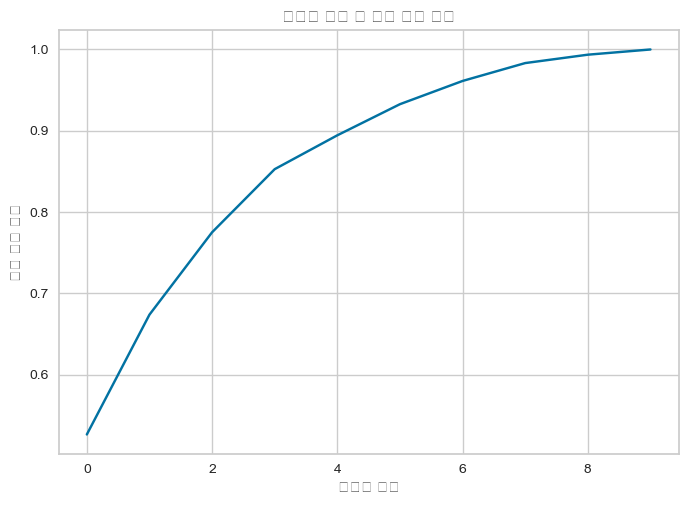

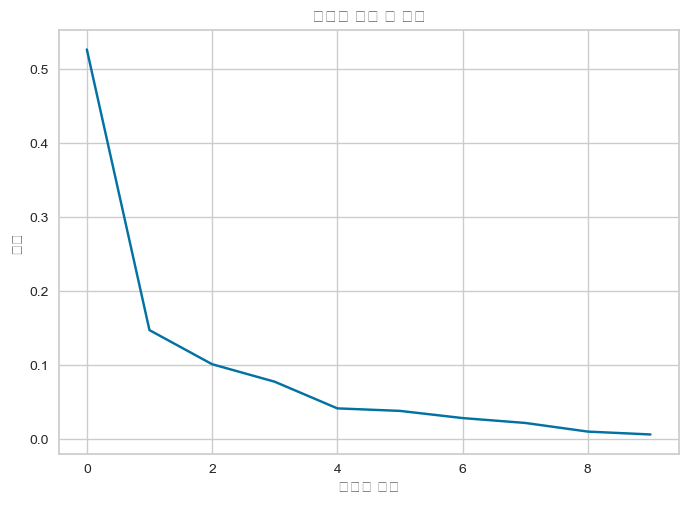

0.852779029029628


PC1    PC2    PC3
0   -1.730 -0.557  0.087
1   -1.859 -0.120  0.150
2   -1.668 -0.943  0.015
3   -0.321  3.355 -0.254
4   -1.666 -1.165 -0.050
..     ...    ...    ...
353 -1.361 -0.535 -0.069
354 -0.239 -1.162  0.708
355 -0.926 -1.196  0.251
356 -1.769 -0.961  0.066
357 -1.790 -0.822  0.127

[358 rows x 3 columns]

In [714]:
pc_df = pac_function(df_japanese_food,3)
pc_df

#### K-means

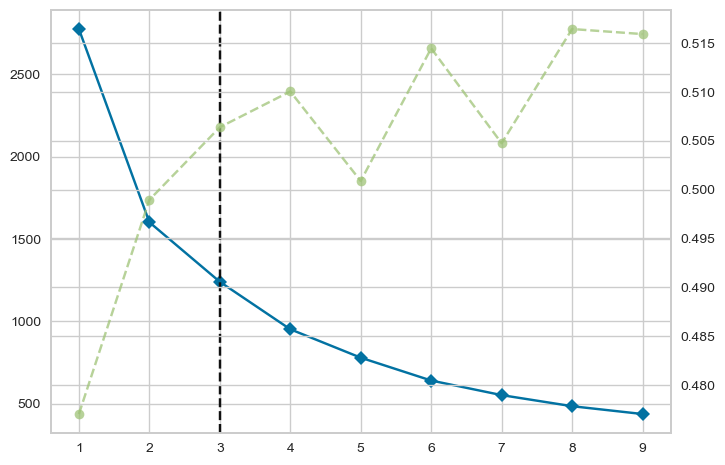

In [715]:
Elbow_function(pc_df)

In [716]:
kmeans_modeling_function(pc_df,3)

0    290
2     62
1      6
Name: cluster, dtype: int64


PC1    PC2    PC3  cluster
0   -1.730 -0.557  0.087        0
1   -1.859 -0.120  0.150        0
2   -1.668 -0.943  0.015        0
3   -0.321  3.355 -0.254        0
4   -1.666 -1.165 -0.050        0
..     ...    ...    ...      ...
353 -1.361 -0.535 -0.069        0
354 -0.239 -1.162  0.708        0
355 -0.926 -1.196  0.251        0
356 -1.769 -0.961  0.066        0
357 -1.790 -0.822  0.127        0

[358 rows x 4 columns]

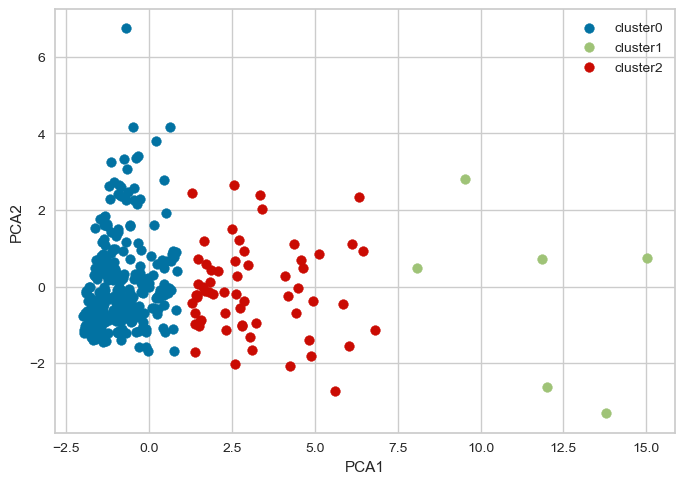

In [717]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [718]:
DBSCAN_modeling_function(pc_df)

 0    353
-1      5
Name: cluster, dtype: int64
모델 성능 : 0.7845220981368728


PC1    PC2    PC3  cluster  pca_x  pca_y
0   -1.730 -0.557  0.087        0 -1.766 -0.561
1   -1.859 -0.120  0.150        0 -1.892 -0.125
2   -1.668 -0.943  0.015        0 -1.705 -0.946
3   -0.321  3.355 -0.254        0 -0.401  3.360
4   -1.666 -1.165 -0.050        0 -1.703 -1.167
..     ...    ...    ...      ...    ...    ...
353 -1.361 -0.535 -0.069        0 -1.407 -0.536
354 -0.239 -1.162  0.708        0 -0.313 -1.157
355 -0.926 -1.196  0.251        0 -0.982 -1.194
356 -1.769 -0.961  0.066        0 -1.804 -0.965
357 -1.790 -0.822  0.127        0 -1.824 -0.827

[358 rows x 6 columns]

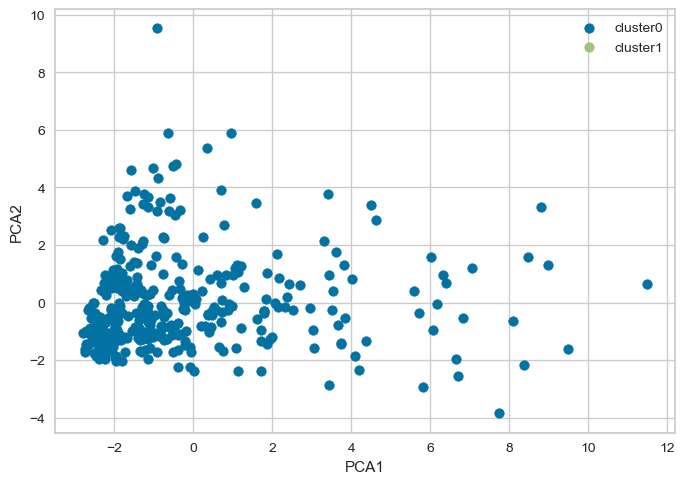

In [719]:
Model_performance_evaluation(pc_df,2)

In [720]:
japanese_food_cluster = df_concat(df_japanese_food)
japanese_food_cluster.head()

상권_구분_코드_명         상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권    4.19민주묘지역 2번       일식음식점        0
1       골목상권             G타워       일식음식점        0
2       골목상권          가인초등학교       일식음식점        0
3       골목상권  강동역 4번(강풀만화거리)       일식음식점        0
4       골목상권         강일동주민센터       일식음식점        0

### 양식음식점

In [721]:
df_western_food = df[df['서비스_업종_코드_명']=='양식음식점']
df_western_food = df_western_food.reset_index(drop=True)
df_western_food.shape

(345, 13)

#### 주성분분석

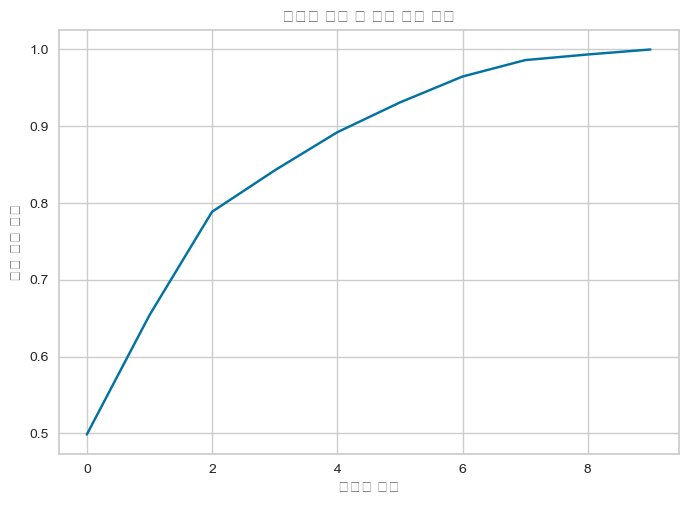

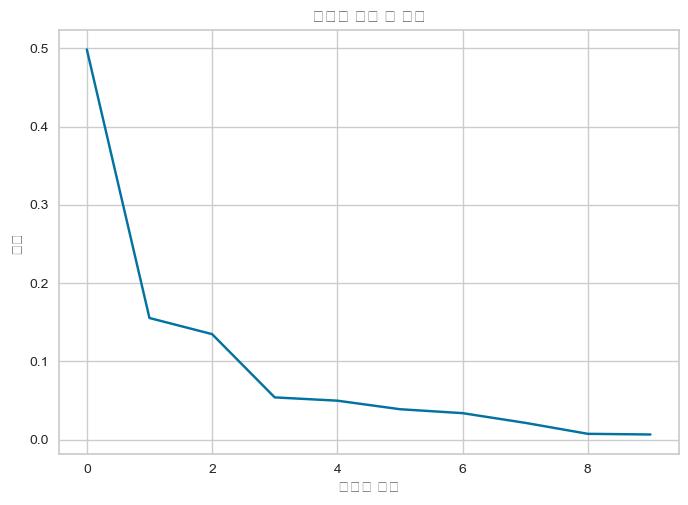

0.7886368118702721


PC1    PC2
0   -1.542  0.277
1   -1.368  0.038
2    0.702  0.548
3    1.389  1.241
4   -0.079 -1.631
..     ...    ...
340 -1.889  1.116
341 -1.677  0.752
342 -1.346  1.015
343 -0.396  1.790
344 -1.710  0.696

[345 rows x 2 columns]

In [723]:
pc_df = pac_function(df_western_food,2)
pc_df

#### K-means

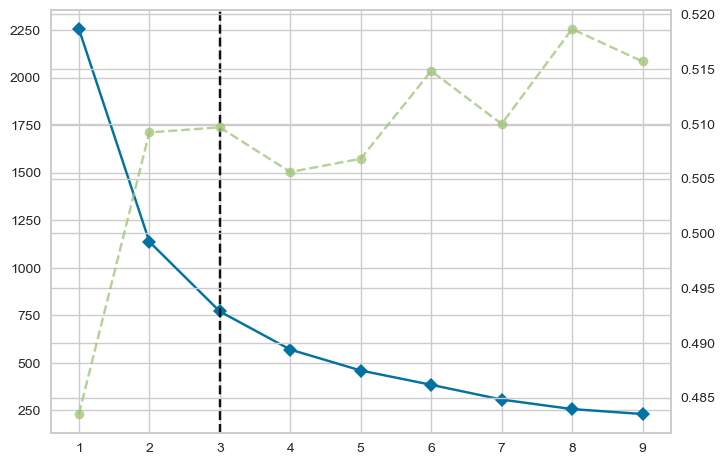

In [724]:
Elbow_function(pc_df)

In [725]:
kmeans_modeling_function(pc_df,3)

0    292
1     44
2      9
Name: cluster, dtype: int64


PC1    PC2  cluster
0   -1.542  0.277        0
1   -1.368  0.038        0
2    0.702  0.548        0
3    1.389  1.241        0
4   -0.079 -1.631        0
..     ...    ...      ...
340 -1.889  1.116        0
341 -1.677  0.752        0
342 -1.346  1.015        0
343 -0.396  1.790        0
344 -1.710  0.696        0

[345 rows x 3 columns]

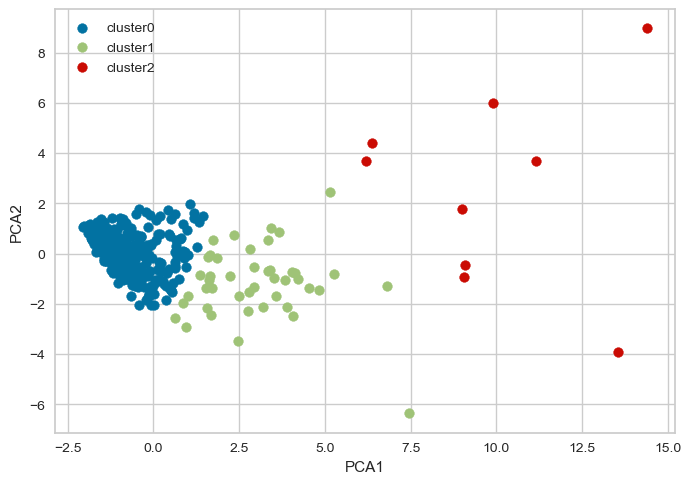

In [726]:
Model_performance_evaluation(pc_df,3)

#### DBSCAN

In [727]:
DBSCAN_modeling_function(pc_df)

 0    343
-1      2
Name: cluster, dtype: int64
모델 성능 : 0.8284486529055245


PC1    PC2  cluster  pca_x  pca_y
0   -1.542  0.277        0 -1.550  0.276
1   -1.368  0.038        0 -1.379  0.037
2    0.702  0.548        0  0.660  0.551
3    1.389  1.241        0  1.336  1.246
4   -0.079 -1.631        0 -0.108 -1.630
..     ...    ...      ...    ...    ...
340 -1.889  1.116        0 -1.892  1.113
341 -1.677  0.752        0 -1.684  0.750
342 -1.346  1.015        0 -1.358  1.014
343 -0.396  1.790        0 -0.423  1.791
344 -1.710  0.696        0 -1.716  0.694

[345 rows x 5 columns]

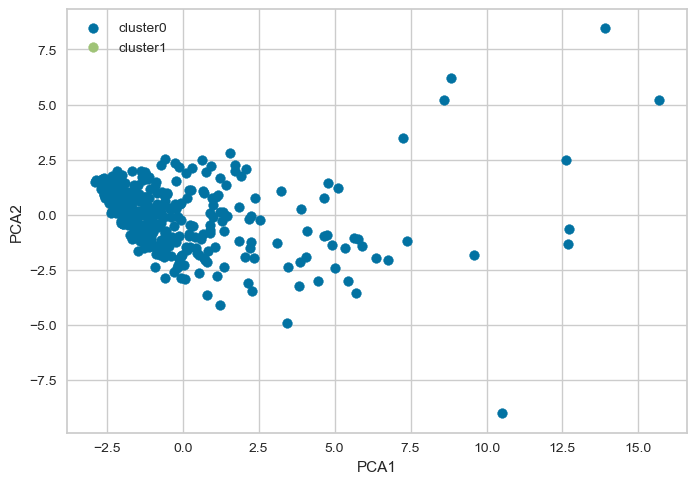

In [728]:
Model_performance_evaluation(pc_df,2)

In [729]:
western_food_cluster = df_concat(df_western_food)
western_food_cluster.head()

상권_구분_코드_명   상권_코드_명 서비스_업종_코드_명  cluster
0       골목상권  강남구청역 4번       양식음식점        0
1       골목상권  건대입구역 1번       양식음식점        0
2       골목상권    경리단길남측       양식음식점        0
3       골목상권    경리단길북측       양식음식점        0
4       골목상권    경성고등학교       양식음식점        0